# 3D Quasidynamic earthquake cycle modelling. First steps: a square fault in a full space.

I've been working to get functioning 3D quasidynamic earthquake cycle simulation set up for the last month. It's been an interesting puzzle working through some of the bugs and misunderstandings that have cropped up and I just figured I'd share the story.

During this process, I've read through a lot of the literature on quasidynamic rupture modeling. I've also read a bit about fully dynamic modeling, because it has many of the same complexities when simulating through multiple earthquake cycles! But, the two main sources that I returned to again and again are:

* Lapusta and Liu, *Three-dimensional boundary integral modeling of spontaneous earthquake sequences and aseismic slip*, 2009.
* Erickson and Dunham, *An efficient numerical method for earthquake cycles in heterogeneous media: Alternating sub-basin and surface-rupturing events on faults crossing a sedimentary basin*, 2014.

The Lapusta and Liu paper goes into substantial and directly useful detail on their implementation. As a complement, the Erickson and Dunham paper is nice because it's focused on a finite difference formulation that is in the time and space domain rather than the Fourier domain setting of the Lapusta and Liu paper. My boundary element method (BEM) implementation is also a time and space domain implementation. 

For an intro to the type of problems I'm solving here, checking out [my post on doing a similar 1D "spring-block-slider" model](http://tbenthompson.com/post/block_slider/). The difference is that, here, I'm modeling a fault surface in 3D domain, rather than a point contact in a 1D domain. That adds a lot more complexity to the implementation and . Primarily, doing this in 3D requires an "elastic solver", that will take the current total slip on the fault surface, any other non-fault boundary conditions, and return the traction on the fault surface. As I mentioned in the 1D post, at a high level, the problem is a simple feedback where I loop:

```
while not done:
    slip += velocity * dt
    traction = elastic_solver(slip)
    velocity = rate_state_solver(traction)
```

However, instead of the simple forward Euler method, I'm using a Runge-Kutta (4,5) method to automatically use the largest accurate time step.

# Slip vs Slip-deficit

This is a critical distinction. When calculating the traction on the fault surface, what we care about is the relative motion of the fault with respect to its surroundings. 

# Failure to impose continuity between adjacent elements.

If there is a discontinuity in slip between two adjacent elements, a stress singularity arises at the boundary between those elements. Infinite stress then passes through the friction law, and fundamentally, results in infinite slip. That's no good. So, imposing slip continuity is essential to having reasonable behavior. And it makes fundamental physical sense too. It's unlikely that large voids are forming deep in the Earth.

This is not a problem for most other quasidynamic earthquake modeling software. If you are using the Fourier domain formulation, you get slip continuity for free by virtue of each Fourier component being continuous in space and thus the sum of those components also being continuous. On the other hand, most Okada-dislocation based approaches (e.g. [QDyn](https://github.com/ydluo/qdyn)) evaluate the stress at the centers of elements. Thus, although the model has stress singularities, the stress is never evaluated in a singular region and the problem is partially avoided. On the other hand, I'm curious how the existence of those singularities affects the final results. In general, I believe the linear (or higher order) slip interpolation that I am using on element is better for this set of problems because it allows continuity.

# Inability to trigger ruptures. 

If I initialize the model with zero slip and a initial steady state parameter, and have $a-b < 0$ everywhere, I initially expected that the model would produce ruptures. Surprisingly, that did not happen. The slip rate evolved 



In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import tectosaur.mesh.mesh_gen

from scipy.integrate import RK45
from scipy.optimize import fsolve
from qd_helpers import *

Define the material, frictional, mesh and boundary condition parameters.

The parameters in `tectosaur_cfg` determine how the integration and evaluating of the integral equations are done. I'll get into the details of Tectosaur some time in the future. For the moment, just trust that Tectosaur does actually solve linear elastic boundary value problems. It's been around the block and has been tested thoroughly, especially for the type of dislocation problems I'm solving here.

In [2]:
n_fault = 60
L = 10 * 1000 # 10 km
W = 10 * 1000 # 10 km
m = tectosaur.mesh.mesh_gen.make_rect(n_fault, n_fault, [
    [-L, 0, W], [-L, 0, -W],
    [L, 0, -W], [L, 0, W]
])
qdm = QDMeshData(m)

qd_cfg = dict(
    # Material properties
    sm = 3e10,          # Shear modulus (Pa)
    pr = 0.25,          # Poisson ratio 
    density = 2700,     # rock density (kg/m^3)

    # Frictional properties
    Dc = 0.01,         # state evolution length scale (m)
    f0 = 0.6,           # baseline coefficient of friction
    V0 = 1e-6,          # when V = V0, f = f0, V is (m/s)

    # Boundary conditions
    plate_rate = 1e-9,  # (m/s), equivalent to ~31.5 mm/yr
    
    # This is only necessary because this is a full space model and there's no concept of depth or gravity
    additional_normal_stress = 50e6, 
    
    tectosaur_cfg = dict(
        quad_mass_order = 4,       
        quad_vertadj_order = 8,
        quad_far_order = 3,
        quad_near_order = 5,
        quad_near_threshold = 2.5,
        float_type = np.float32,
        use_fmm = False,
        fmm_order = 150,
        fmm_mac = 3.0,
        pts_per_cell = 450,
        log_level = logging.INFO
    )
)
plate_boundary_width = 1 * 1000
qd_cfg['driving_rate'] = qd_cfg['plate_rate'] * qd_cfg['sm'] / plate_boundary_width
qd_cfg['cs'] = np.sqrt(qd_cfg['sm'] / qd_cfg['density'])# Shear wave speed (m/s)
qd_cfg['eta'] = qd_cfg['sm'] / (2 * qd_cfg['cs'])       # The radiation damping coefficient (kg / (m^2 * s))

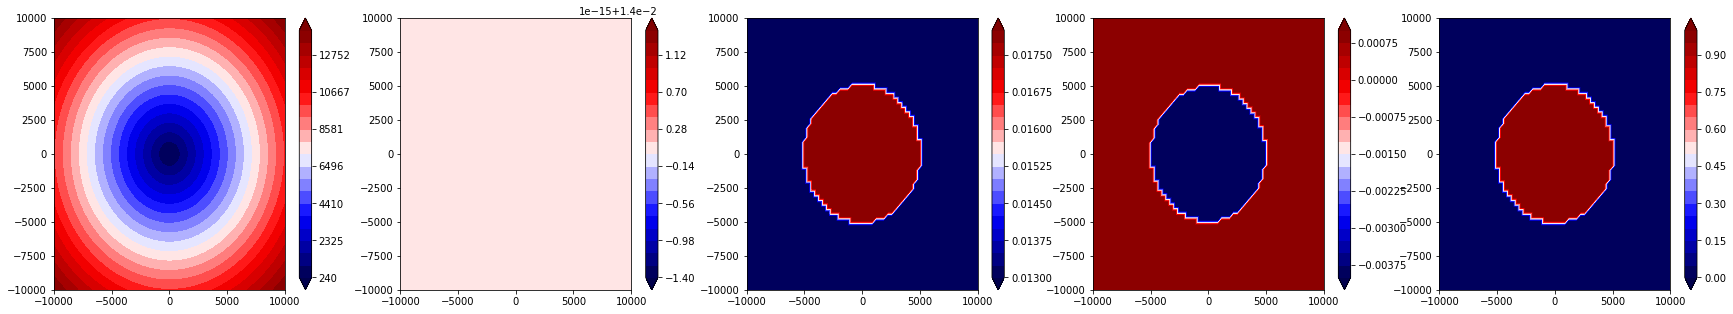

In [3]:
dof_pts = m[0][m[1]].reshape((-1,3))
distance_from_center = np.linalg.norm(dof_pts, axis = 1)

def gen_peaks(n_peaks, amplitude, width):
    n_peaks = 150
    centers = (np.random.rand(n_peaks, 2) - 0.5) * 2 * L * 0.8
    As = (np.random.rand(n_peaks) - 0.5) * 0.007
    width = 1000
    r2 = (dof_pts[:,0][:,np.newaxis] - centers[:,0]) ** 2 + (dof_pts[:,2][:,np.newaxis] - centers[:,1]) ** 2
    -r2 / (width ** 2)
    Q = np.sum(As * np.exp(-r2 / (width ** 2)), axis = 1)
    plot_fields(qdm.m, Q)
    return Q

lin_dist = L / 2
lin_slope = 0.02 / L
b = np.where(distance_from_center < lin_dist, 0.018, 0.013)#-1 * (lin_dist - distance_from_center) * lin_slope + 0.014)
a = np.ones_like(b) * 0.014
# a += gen_peaks(75, 0.003, 2000)
# b += gen_peaks(75, 0.007, 2000)
qd_cfg['a'] = a
qd_cfg['b'] = b
all_fields = np.vstack((distance_from_center, qd_cfg['a'], qd_cfg['b'], qd_cfg['a'] - qd_cfg['b'], qd_cfg['a'] - qd_cfg['b'] < 0)).T
plot_fields(qdm.m, all_fields)

Check that the "process zone" and $k_{crit}$ are good. See section 6 in Erickson et al 2014

In [4]:
mesh_L = min(L, W) / n_fault
Lb = qd_cfg['sm'] * qd_cfg['Dc'] / (qd_cfg['additional_normal_stress'] * qd_cfg['b'])
hstar = (np.pi * qd_cfg['sm'] * qd_cfg['Dc']) / (qd_cfg['additional_normal_stress'] * (qd_cfg['b'] - qd_cfg['a']))
# all_fields = np.vstack((Lb, hstar, np.ones_like(hstar) * mesh_L)).T
# plot_fields(qdm.m, all_fields)
np.min(np.abs(hstar)), np.min(Lb), mesh_L

(4712.3889803846914, 333.33333333333337, 166.66666666666666)

Setup the (slip -> traction) operator

Set up initial conditions. The edges of the fault should move at the plate rate and the interior should be moving at 1/1000th the plate rate. Then, solve for the corresponding steady state.

In [5]:
# def steady_state(V_mag):
#     # This could just be analytically solved, but why not just do it numerically...
#     def f(state):
#         return aging_law(qd_cfg, V_mag, state)
#     return fsolve(f, 0.0, maxfev = 10000)
initial_state = 0.8 * np.ones(qdm.m.tris.shape[0] * 3)

In [6]:
initial_state

array([ 0.8,  0.8,  0.8, ...,  0.8,  0.8,  0.8])

In [7]:
def separate_slip_state(y):
    n_total_dofs = y.shape[0]
    n_slip_dofs = n_total_dofs // 4 * 3
    return y[:n_slip_dofs], y[n_slip_dofs:]

def rate_state_solve(qdm, qd_cfg, traction, state):
    V = np.empty_like(qdm.slip100)
    qd_newton.rate_state_solver(
        qdm.tri_normals, traction, state, V,
        qd_cfg['a'], qd_cfg['eta'], qd_cfg['V0'],
        qd_cfg['additional_normal_stress'],
        1e-12, 50
    )
    return V

# State evolution law -- aging law.
def aging_law(qd_cfg, V, state):
    return (qd_cfg['b'] * qd_cfg['V0'] / qd_cfg['Dc']) * (
        np.exp((qd_cfg['f0'] - state) / qd_cfg['b']) - (V / qd_cfg['V0'])
    )

def state_evolution(qd_cfg, V, state):
    V_mag = np.linalg.norm(V.reshape(-1,3), axis = 1)
    return aging_law(qd_cfg, V_mag, state)

def solve_for_full_state(qdm, qd_cfg, slip_to_traction, t, y):
    tm = Timer()
    slip, state = separate_slip_state(y)
    tm.report('sep')

    traction = slip_to_traction(slip)
    traction += qdm.slip100 * qd_cfg['driving_rate'] * t
    
    tm.report('slip_to_traction')
    V = rate_state_solve(qdm, qd_cfg, traction, state)
    tm.report('rate_state_solve')
    dstatedt = state_evolution(qd_cfg, V, state)
    tm.report('state_evolution')
    return slip, state, traction, V, dstatedt

def make_qd_derivs(qdm, qd_cfg, slip_to_traction):
    def qd_derivs(t, y):
        slip, state, traction, V, dstatedt = solve_for_full_state(
            qdm, qd_cfg, slip_to_traction, t, y
        )
        #print('Vmax', np.max(V.reshape((-1,3)), axis = 0))
        #TODO: CHECK THE DIMENSIONS ON V AND dstatedt
        return np.concatenate((V, dstatedt))
    return qd_derivs

def plot_setting(t, y, qdm, qd_cfg, slip_to_traction):
    slip, state, traction, V, dstatedt = solve_for_full_state(
        qdm, qd_cfg, slip_to_traction, t, y
    )
    #print('slip')
    #plot_signs(slip)
    #plot_fields(np.log10(np.abs(slip) + 1e-40))
    #print('deficit')
    #plot_signs(slip_deficit)
    #plot_fields(np.log10(np.abs(slip_deficit) + 1e-40))
    print('V')
    #plot_signs(V)
    plot_fields(qdm.m, np.log10(np.abs(V) + 1e-40))
    print('traction')
    plot_fields(qdm.m, traction)
    print('state')
    plot_fields(qdm.m, state)

In [8]:
import os
os.environ['CUDA_DEVICE'] = '1'

In [9]:
slip_to_traction = get_slip_to_traction(qdm, qd_cfg)
derivs = make_qd_derivs(qdm, qd_cfg, slip_to_traction)

[4093:INFO:tectosaur.util.cuda]
    Initialized CUDA on gpu: 1


In [10]:
initial_conditions = np.concatenate((np.zeros(qdm.m.n_dofs()), initial_state))
integrator = RK45(derivs, 0, initial_conditions, 1e20, atol = 1e-5, rtol = 1e-5)

0 3.1688087814e-12
V


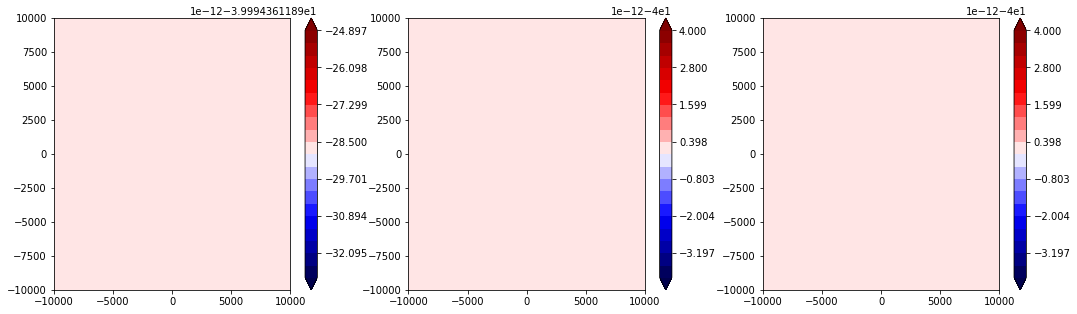

traction


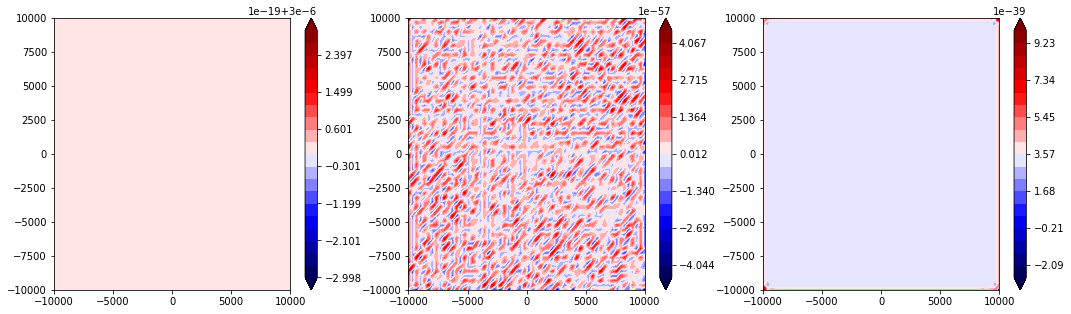

state


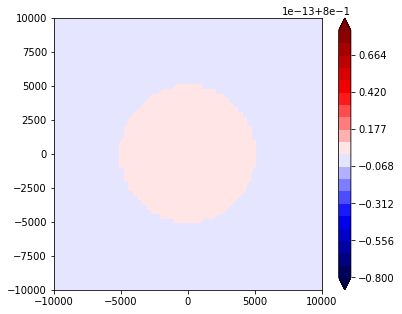

1 3.48568965954e-11
2 3.51737774736e-10
3 3.52054655614e-09
4 3.52086343702e-08
5 3.5208951251e-07
6 3.52089829391e-06
7 3.52089861079e-05
8 0.000352089864248
9 0.00352089864565
10 0.0352089864597
V


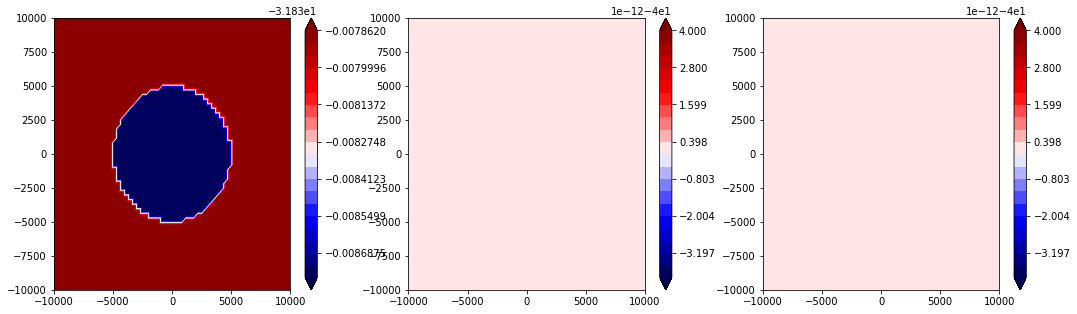

traction


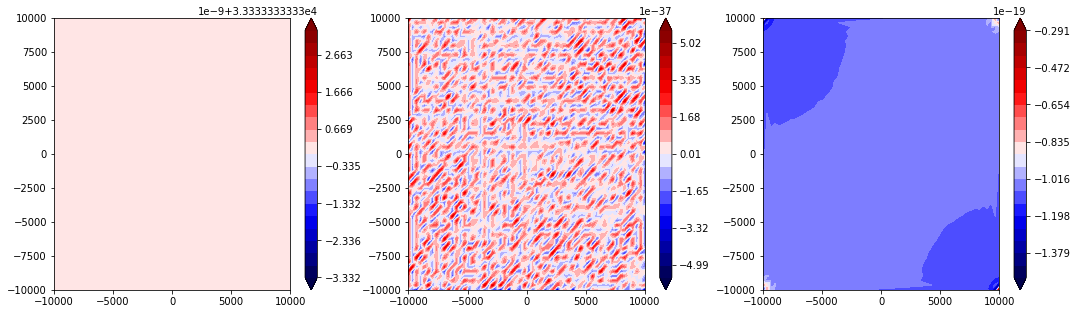

state


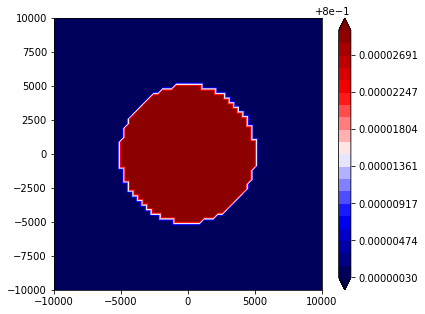

11 0.3520898646
12 3.520898646
13 9.85851620881
14 18.1943748498
15 28.721532894


/home/tthompson/tools/pyenv/versions/miniconda3-4.3.11/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


16 31.1453994686
17 33.1694060807
18 34.5293831835
19 34.9800546156
20 35.1628874135
V


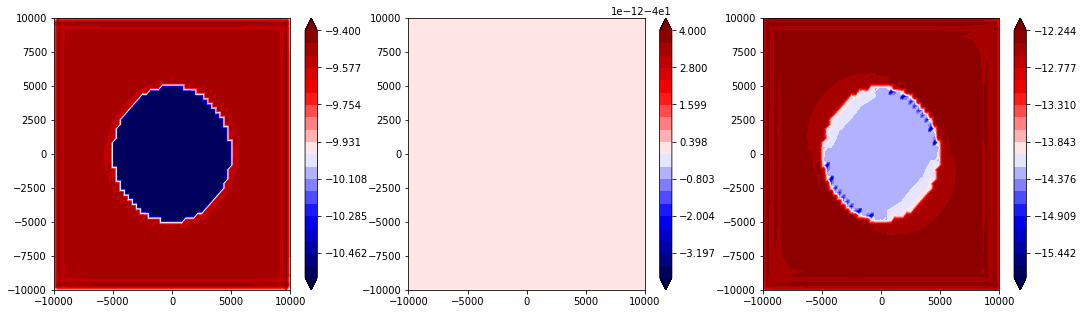

traction


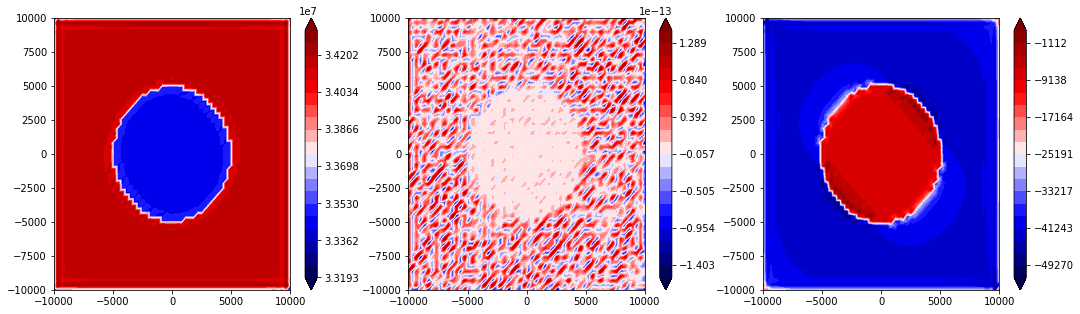

state


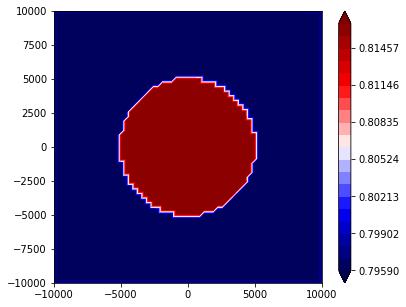

21 35.2467637205
22 35.2878045688
23 35.2964666309
24 35.3050270535
25 35.3054700851
26 35.305778292
27 35.3058044126
28 35.3058527943
29 35.3058559603
30 35.3058600818
V


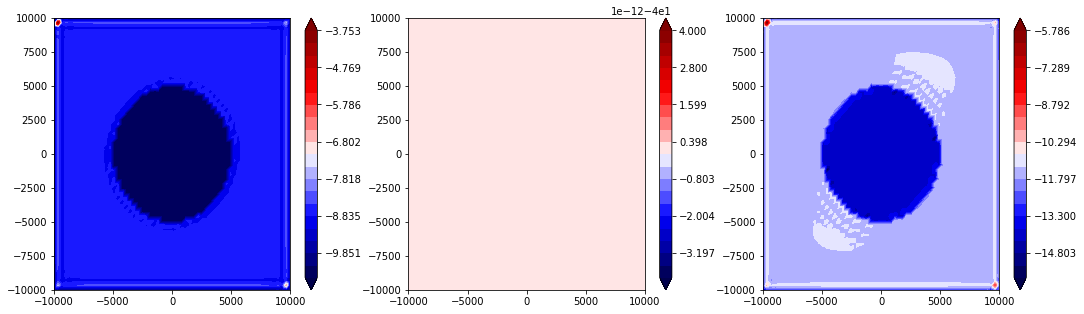

traction


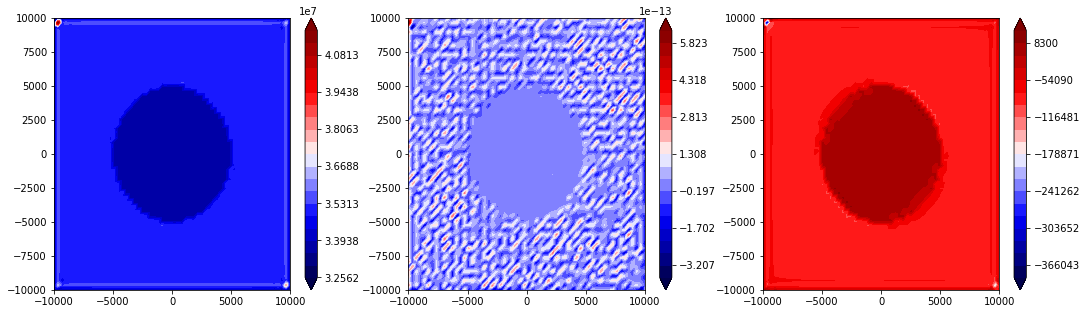

state


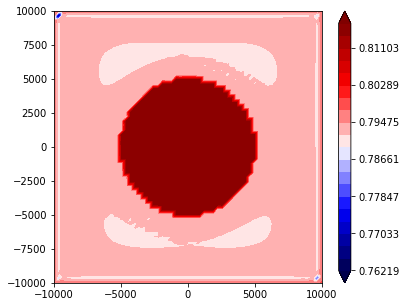

31 35.3058602946
32 35.305860386
33 35.305860425
34 35.3058604415
35 35.3058604481
36 35.3058604506
37 35.3058604512
38 35.3058604514
39 35.3058604515
40 35.3058604517
V


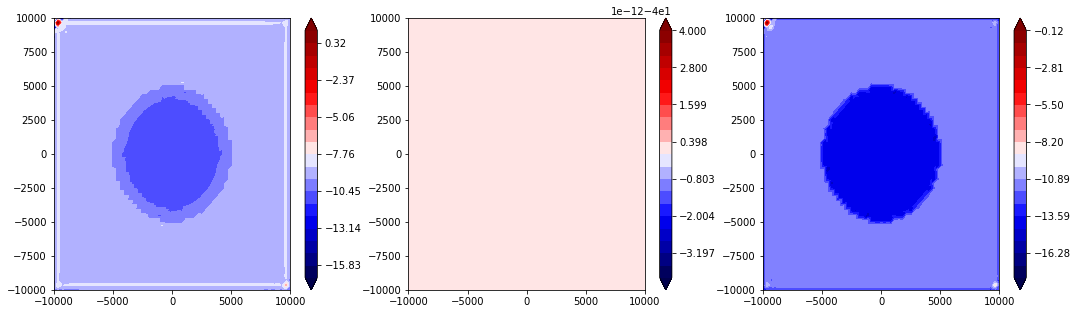

traction


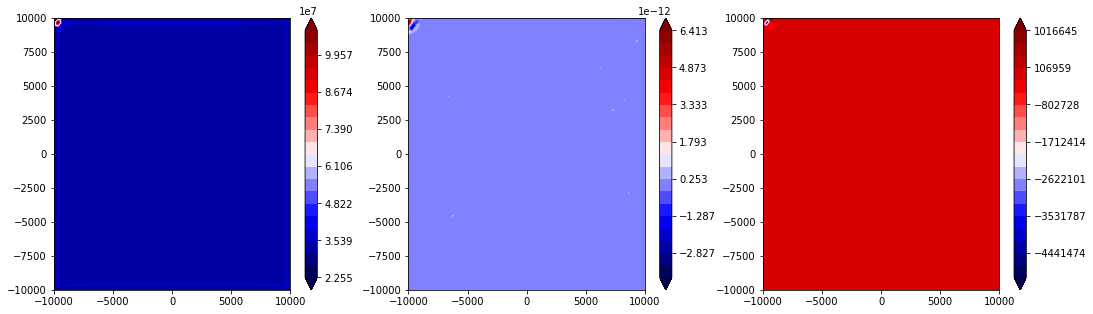

state


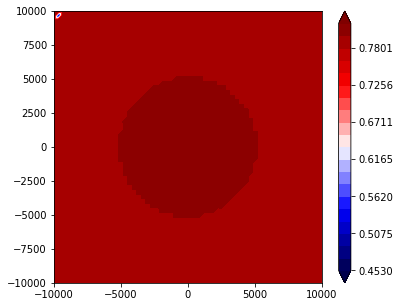

41 35.3058604517
42 35.3058604518
43 35.3058604518
44 35.3058604518
45 35.3058604518
46 35.3058604518
47 35.3058604519
48 35.3058604519
49 35.3058604519
50 35.305860452
V


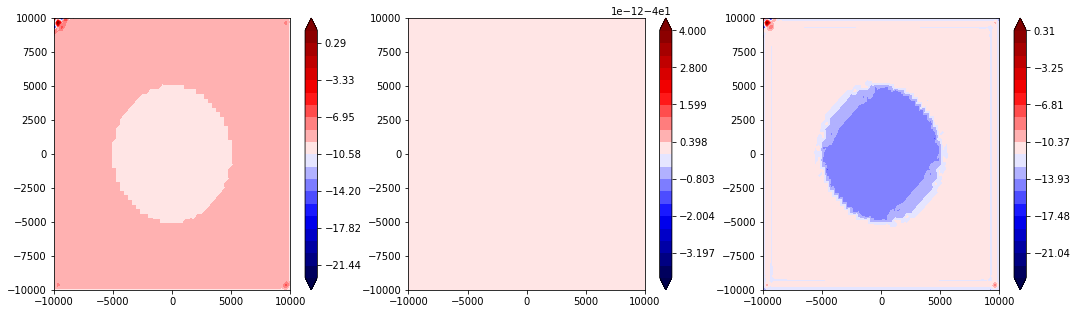

traction


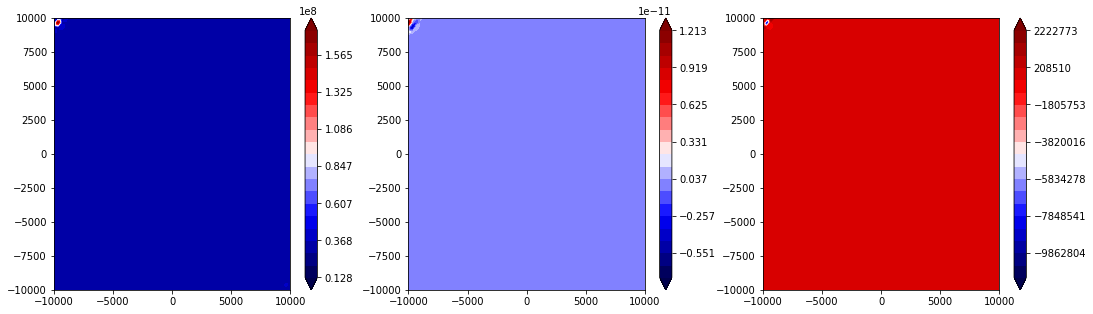

state


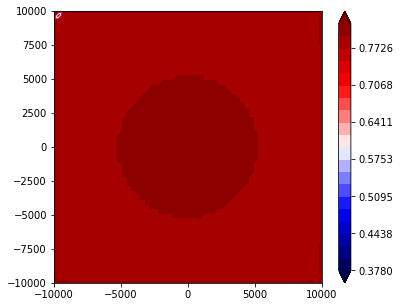

51 35.305860452
52 35.305860452
53 35.305860452
54 35.305860452
55 35.3058604521
56 35.3058604521
57 35.3058604521
58 35.3058604521
59 35.3058604522
60 35.3058604522
V


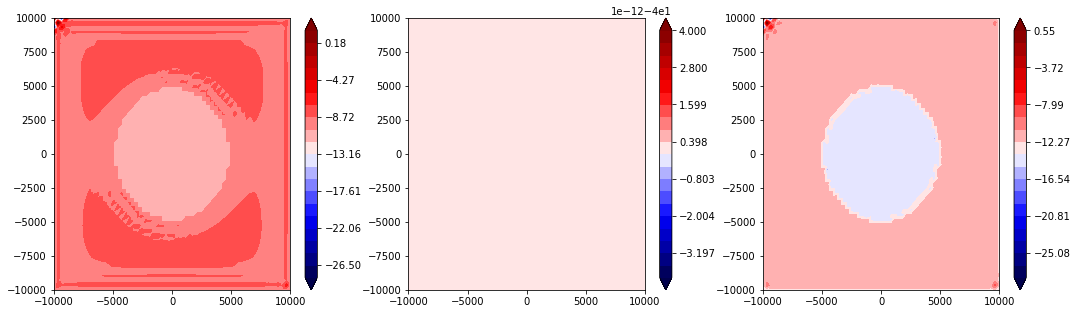

traction


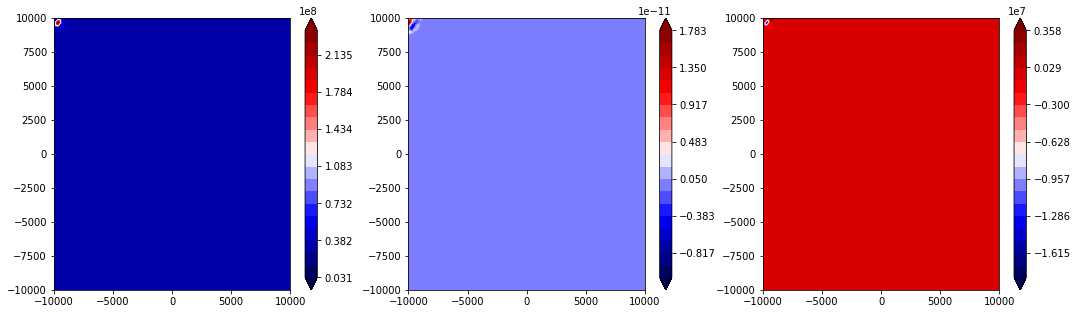

state


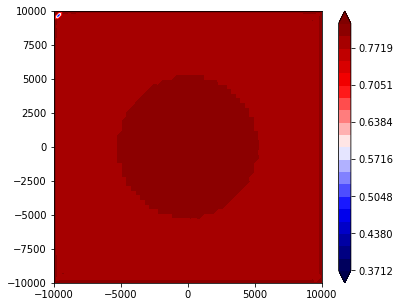

61 35.3058604522
62 35.3058604522
63 35.3058604522
64 35.3058604522
65 35.3058604523
66 35.3058604523
67 35.3058604523
68 35.3058604523
69 35.3058604523
70 35.3058604523
V


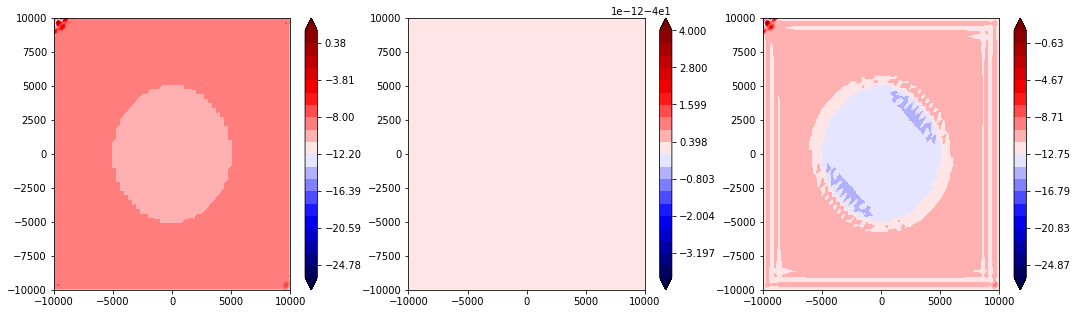

traction


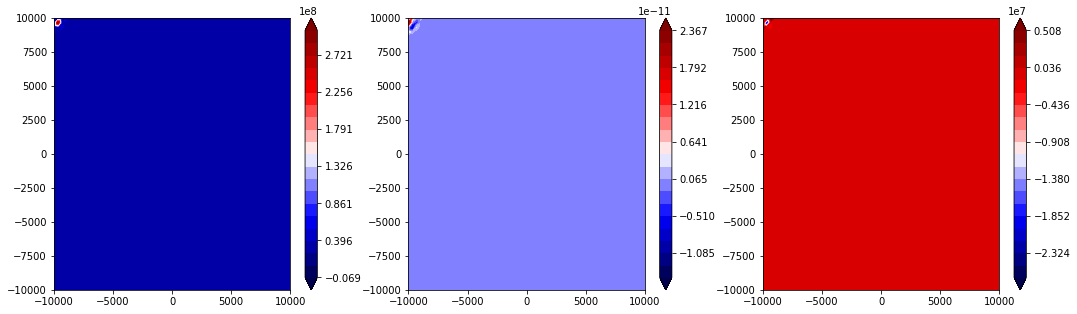

state


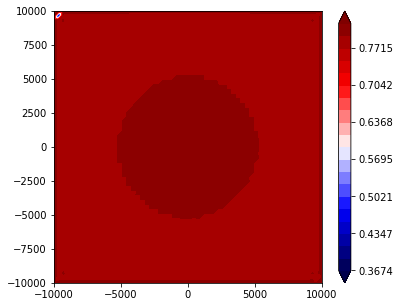

71 35.3058604523
72 35.3058604523
73 35.3058604523
74 35.3058604524
75 35.3058604524
76 35.3058604524
77 35.3058604524
78 35.3058604524
79 35.3058604524
80 35.3058604524
V


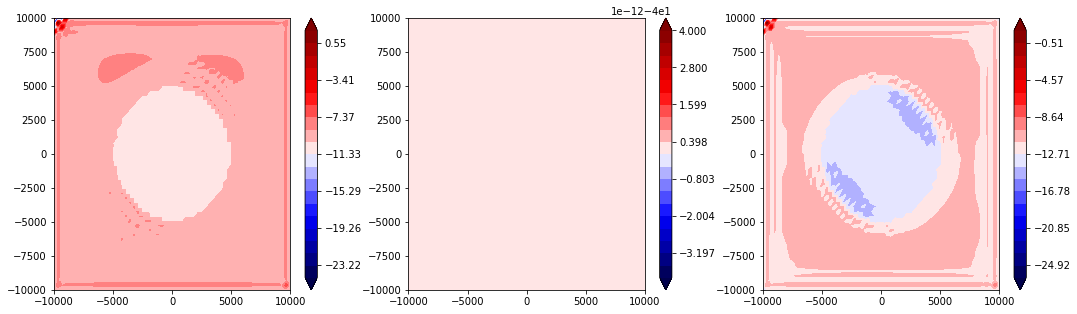

traction


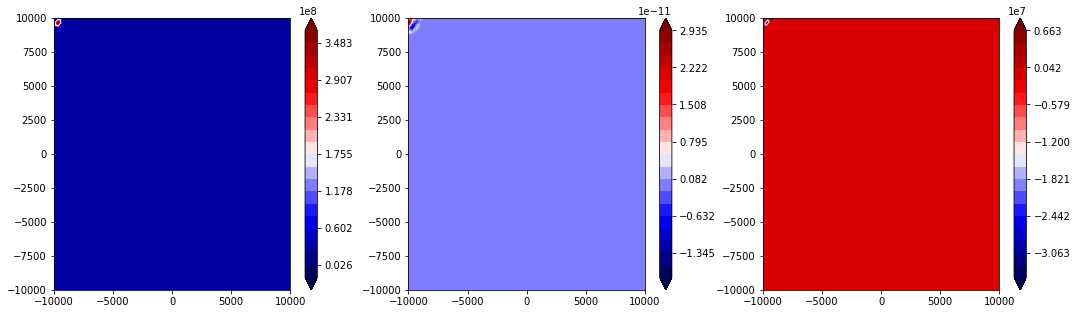

state


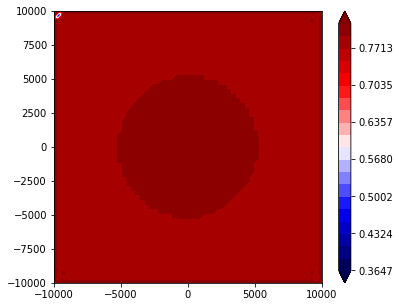

81 35.3058604524
82 35.3058604524
83 35.3058604524
84 35.3058604525
85 35.3058604525
86 35.3058604525
87 35.3058604525
88 35.3058604525
89 35.3058604525
90 35.3058604525
V


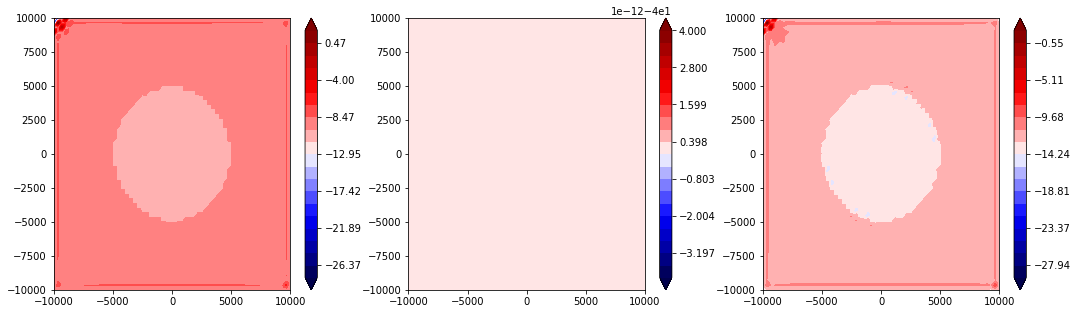

traction


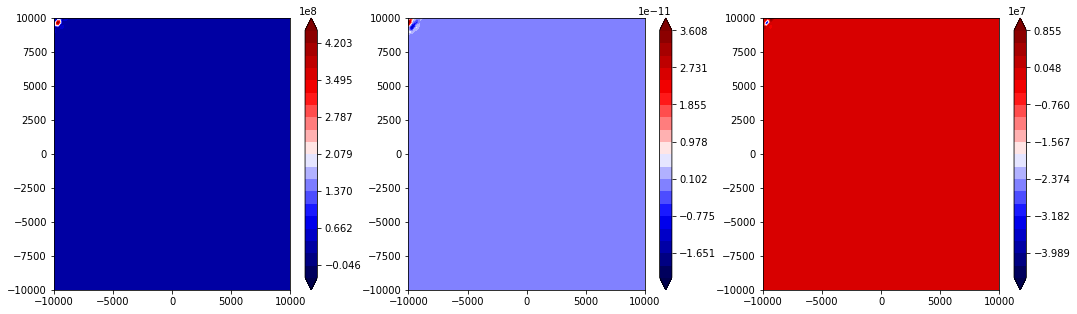

state


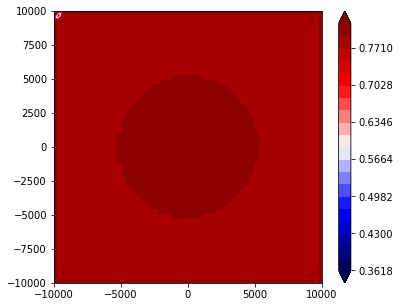

91 35.3058604525
92 35.3058604525
93 35.3058604525
94 35.3058604526
95 35.3058604526
96 35.3058604526
97 35.3058604526
98 35.3058604526
99 35.3058604526
100 35.3058604526
V


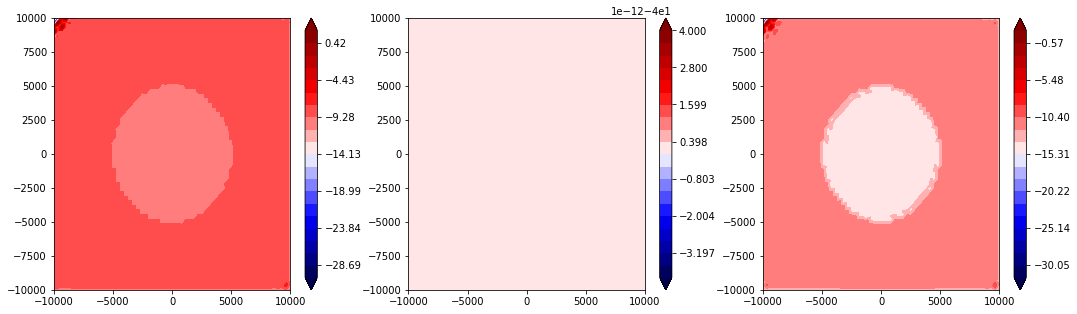

traction


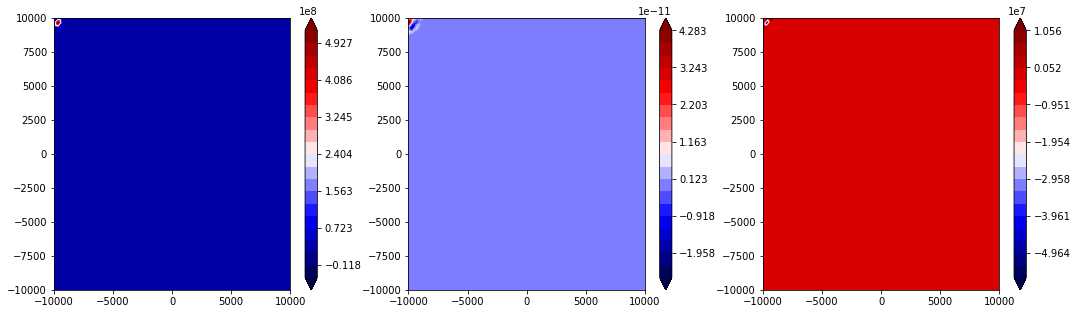

state


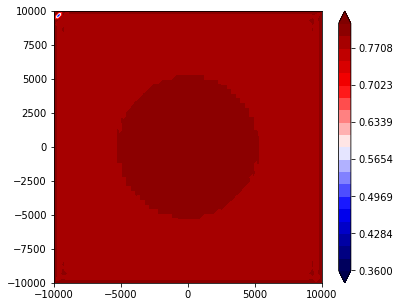

101 35.3058604526
102 35.3058604526
103 35.3058604526
104 35.3058604526
105 35.3058604526
106 35.3058604526
107 35.3058604526
108 35.3058604527
109 35.3058604527
110 35.3058604527
V


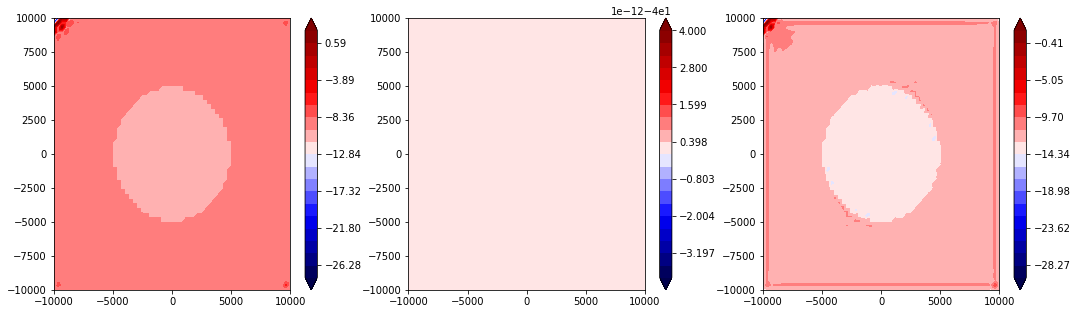

traction


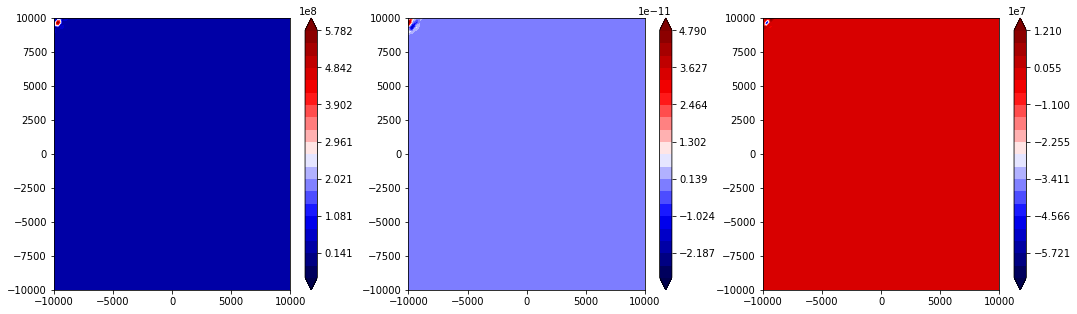

state


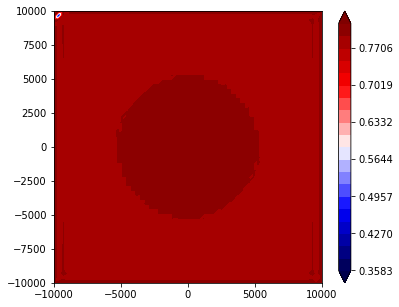

111 35.3058604527
112 35.3058604527
113 35.3058604527
114 35.3058604527
115 35.3058604527
116 35.3058604527
117 35.3058604527
118 35.3058604527
119 35.3058604527
120 35.3058604527
V


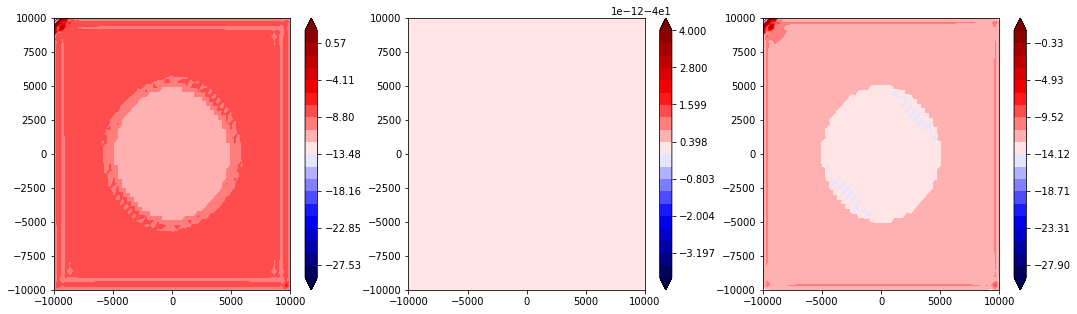

traction


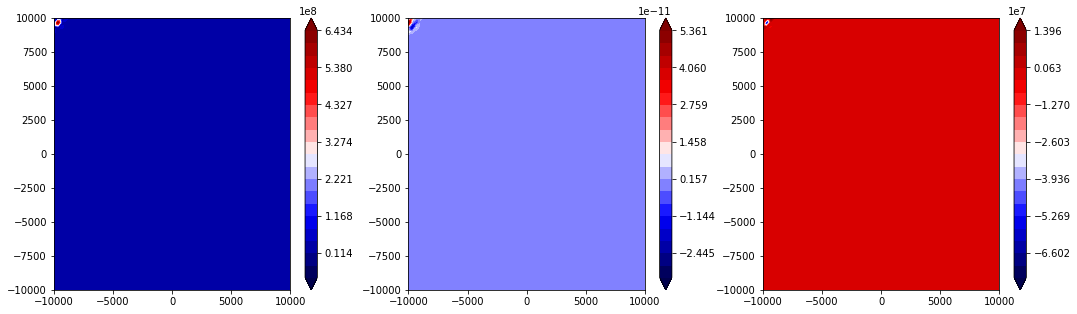

state


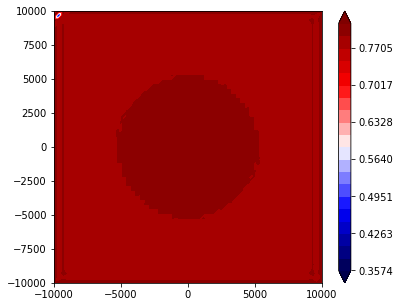

121 35.3058604527
122 35.3058604527
123 35.3058604527
124 35.3058604527
125 35.3058604527
126 35.3058604527
127 35.3058604528
128 35.3058604528
129 35.3058604528
130 35.3058604528
V


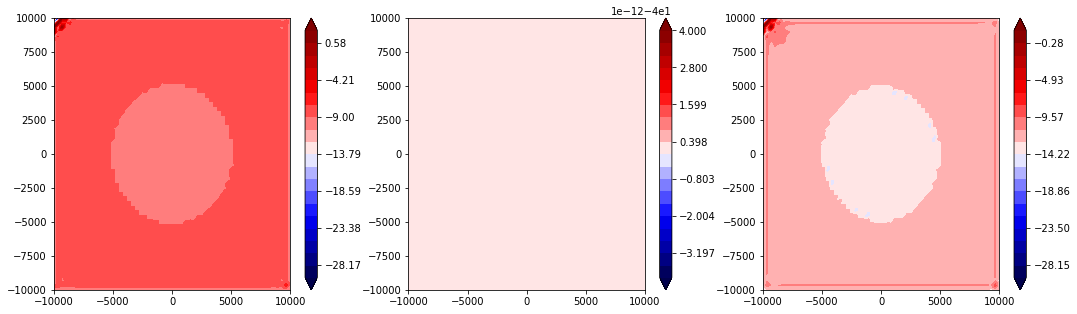

traction


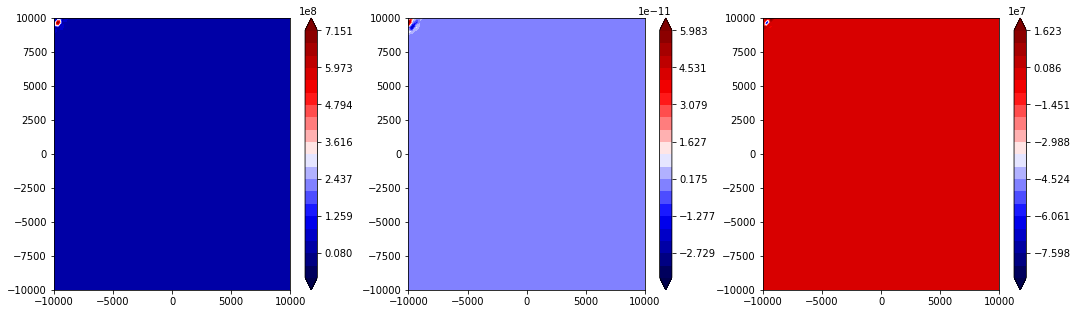

state


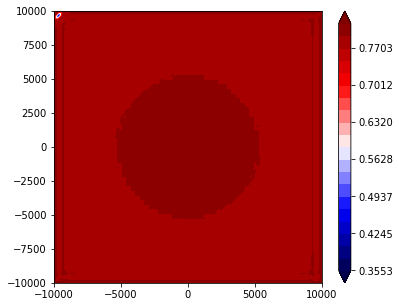

131 35.3058604528
132 35.3058604528
133 35.3058604528
134 35.3058604528
135 35.3058604528
136 35.3058604528
137 35.3058604528
138 35.3058604528
139 35.3058604528
140 35.3058604528
V


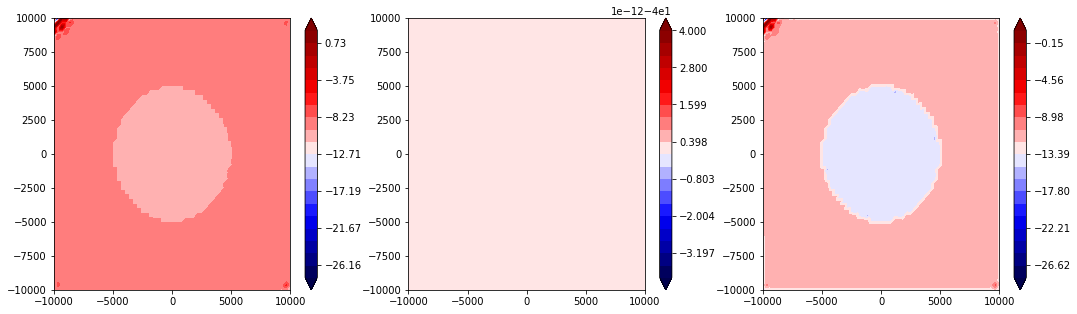

traction


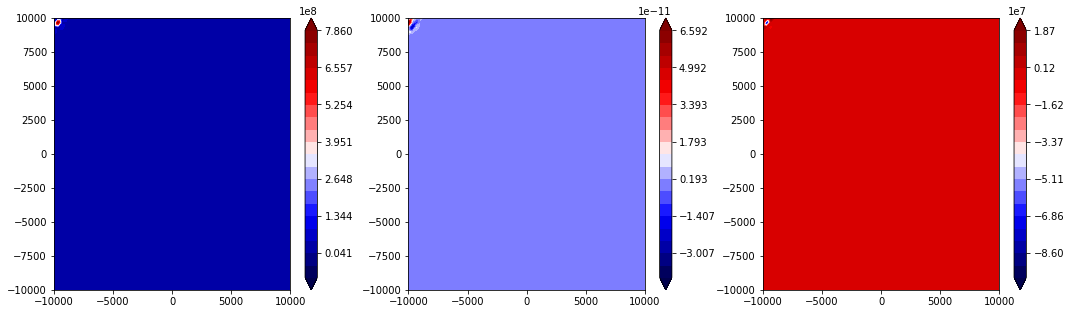

state


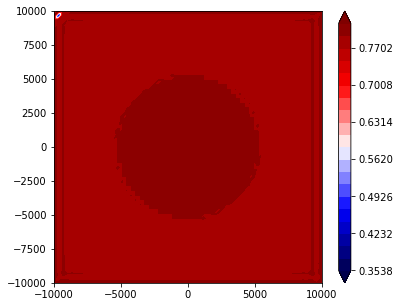

141 35.3058604528
142 35.3058604528
143 35.3058604528
144 35.3058604528
145 35.3058604528
146 35.3058604529
147 35.3058604529
148 35.3058604529
149 35.3058604529
150 35.3058604529
V


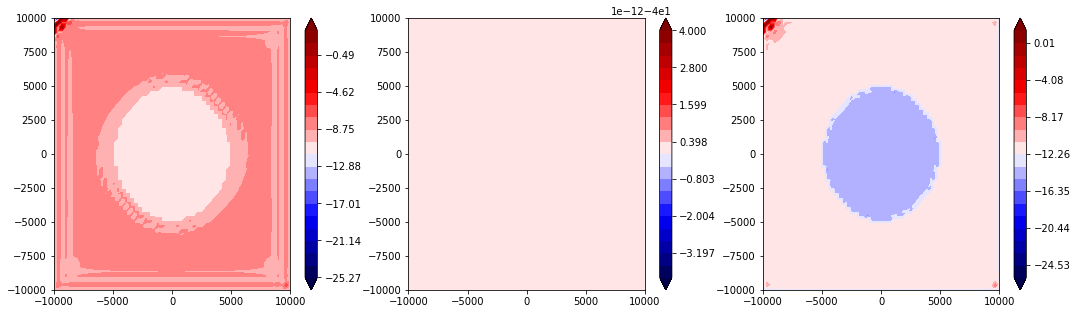

traction


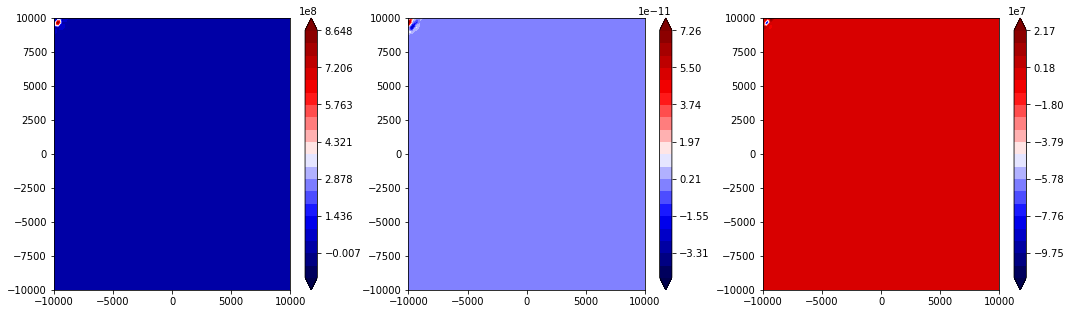

state


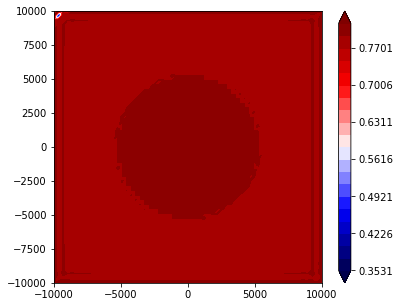

151 35.3058604529
152 35.3058604529
153 35.3058604529
154 35.3058604529
155 35.3058604529
156 35.3058604529
157 35.3058604529
158 35.3058604529
159 35.3058604529
160 35.3058604529
V


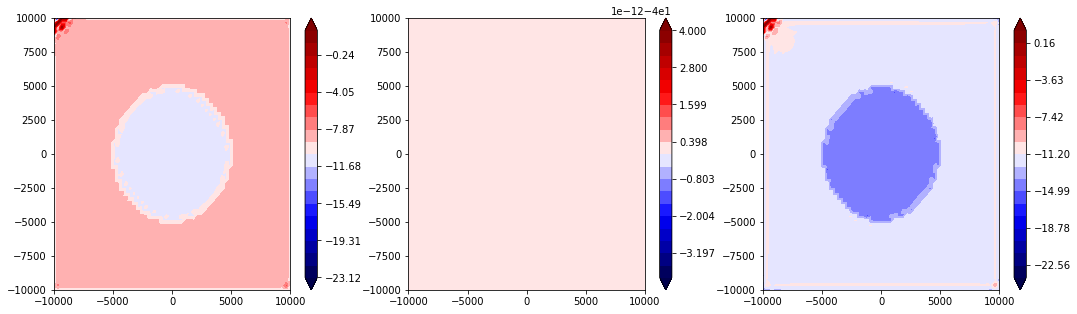

traction


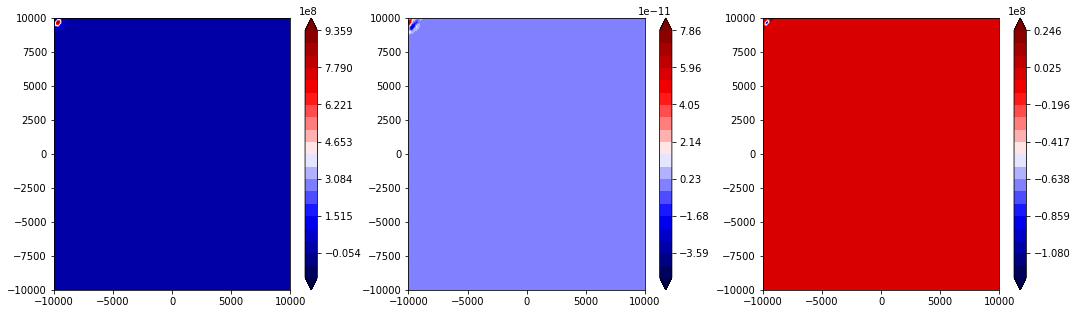

state


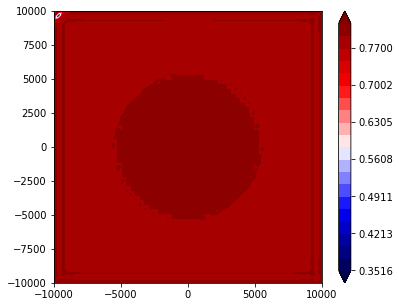

161 35.3058604529
162 35.3058604529
163 35.3058604529
164 35.3058604529
165 35.3058604529
166 35.3058604529
167 35.3058604529
168 35.3058604529
169 35.305860453
170 35.305860453
V


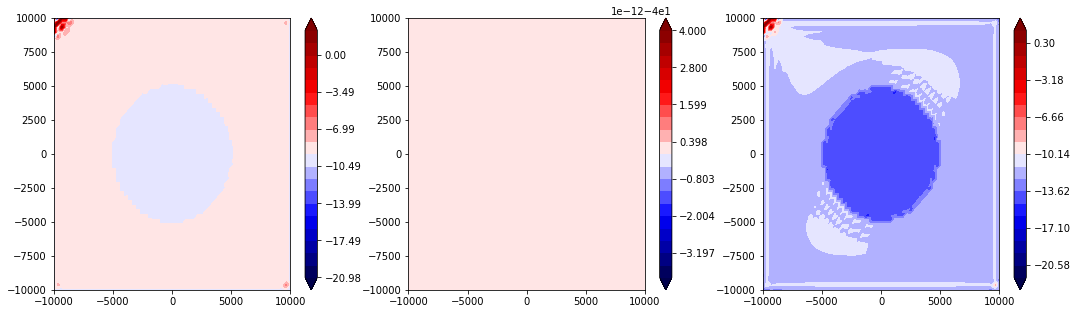

traction


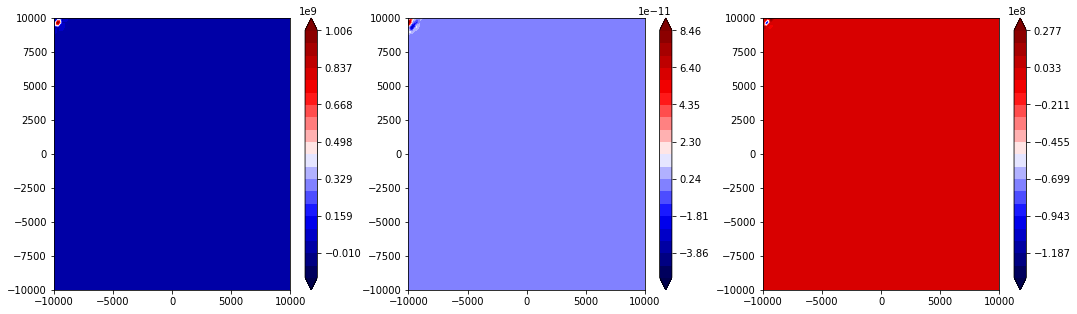

state


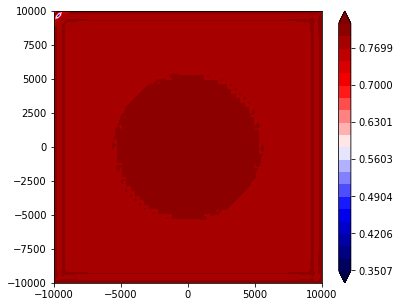

171 35.305860453
172 35.305860453
173 35.305860453
174 35.305860453
175 35.305860453
176 35.305860453
177 35.305860453
178 35.305860453
179 35.305860453
180 35.305860453
V


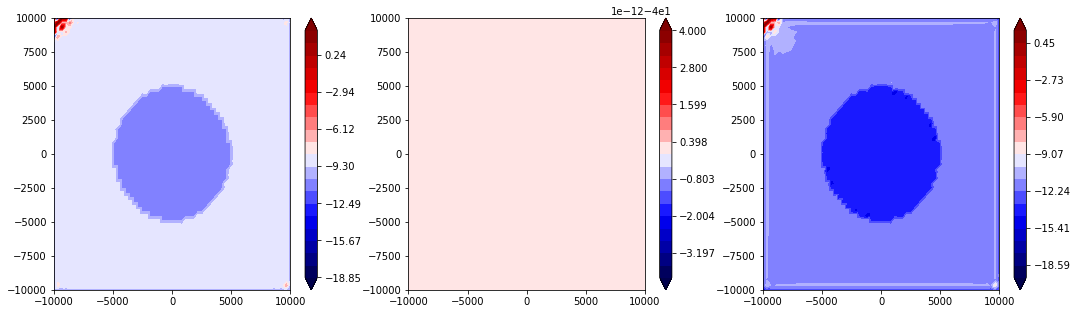

traction


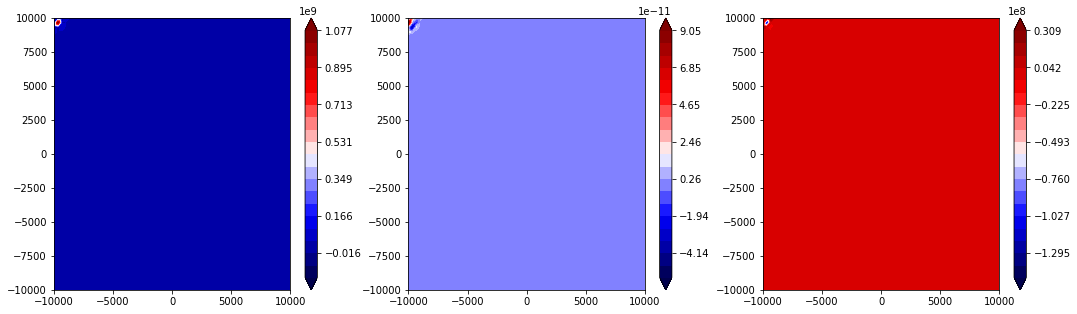

state


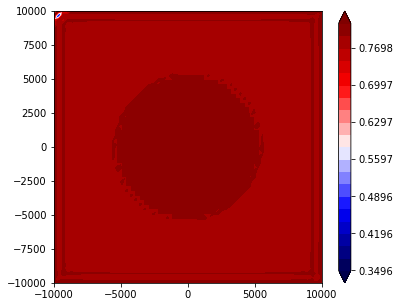

181 35.305860453
182 35.305860453
183 35.305860453
184 35.305860453
185 35.305860453
186 35.305860453
187 35.305860453
188 35.305860453
189 35.305860453
190 35.305860453
V


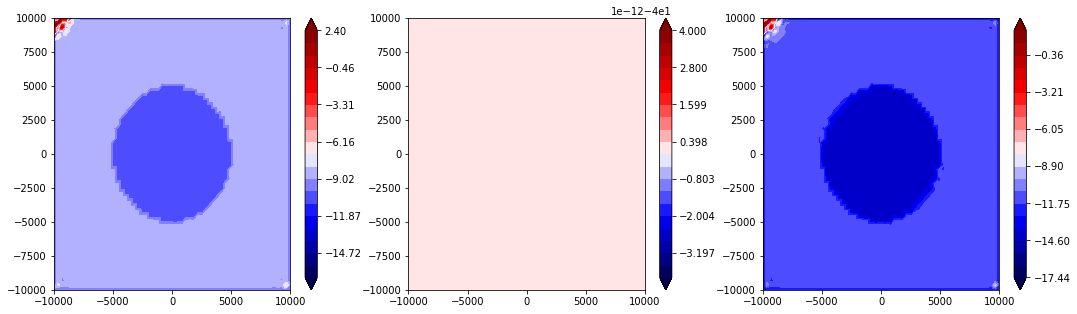

traction


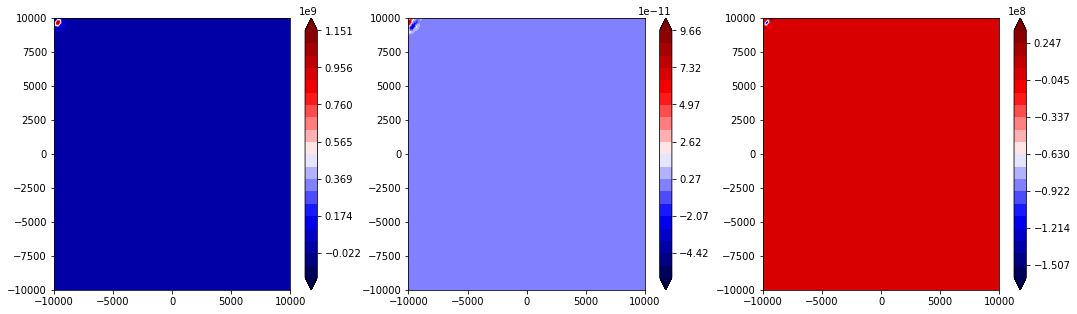

state


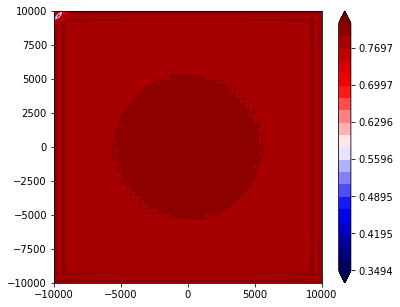

191 35.305860453
192 35.305860453
193 35.305860453
194 35.305860453
195 35.305860453
196 35.305860453
197 35.305860453
198 35.305860453
199 35.305860453
200 35.3058604531
V


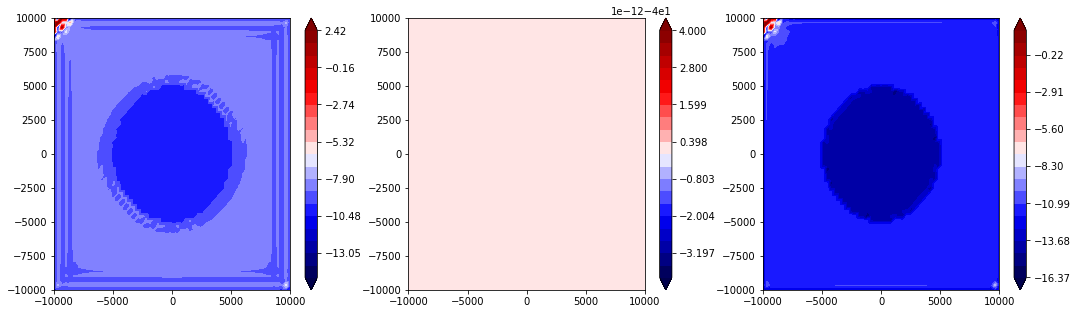

traction


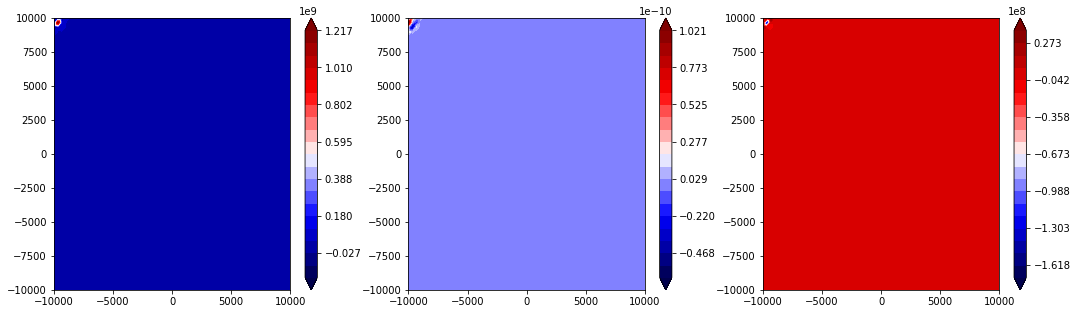

state


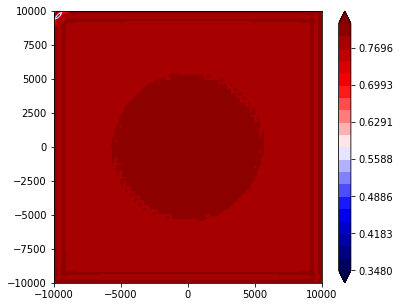

201 35.3058604531
202 35.3058604531
203 35.3058604531
204 35.3058604531
205 35.3058604531
206 35.3058604531
207 35.3058604531
208 35.3058604531
209 35.3058604531
210 35.3058604531
V


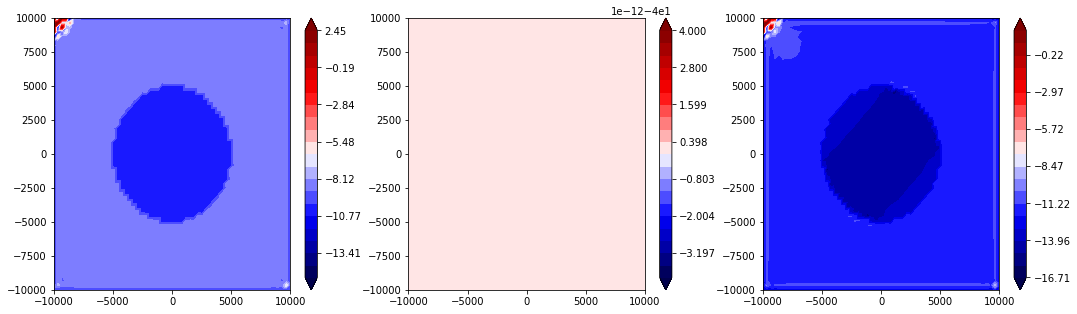

traction


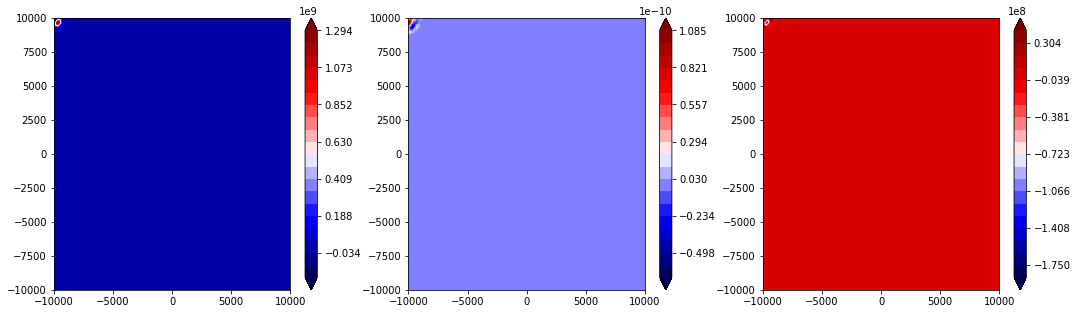

state


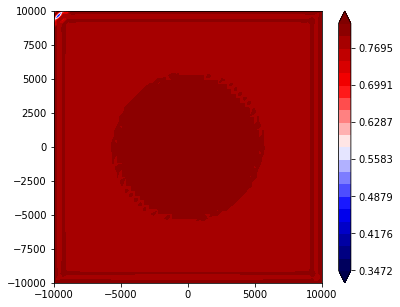

211 35.3058604531
212 35.3058604531
213 35.3058604531
214 35.3058604531
215 35.3058604531
216 35.3058604531
217 35.3058604531
218 35.3058604531
219 35.3058604531
220 35.3058604531
V


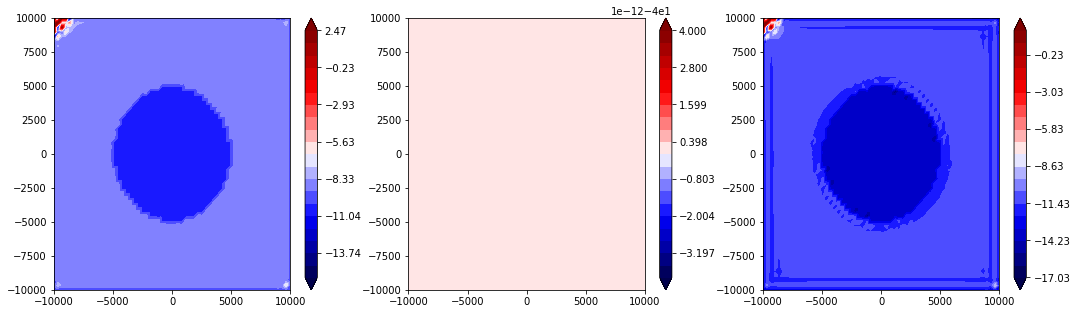

traction


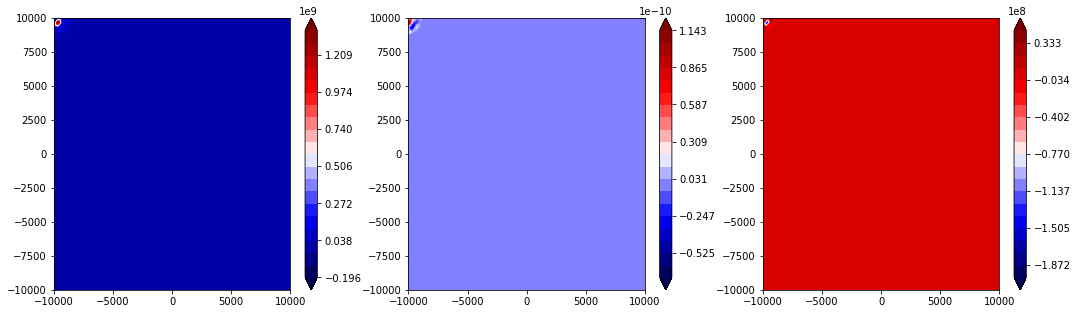

state


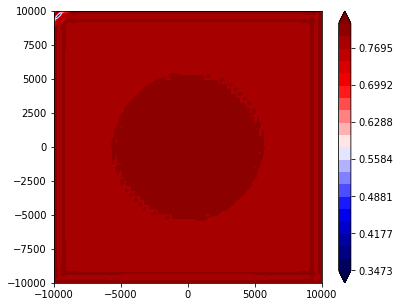

221 35.3058604531
222 35.3058604531
223 35.3058604531
224 35.3058604531
225 35.3058604531
226 35.3058604531
227 35.3058604531
228 35.3058604531
229 35.3058604531
230 35.3058604531
V


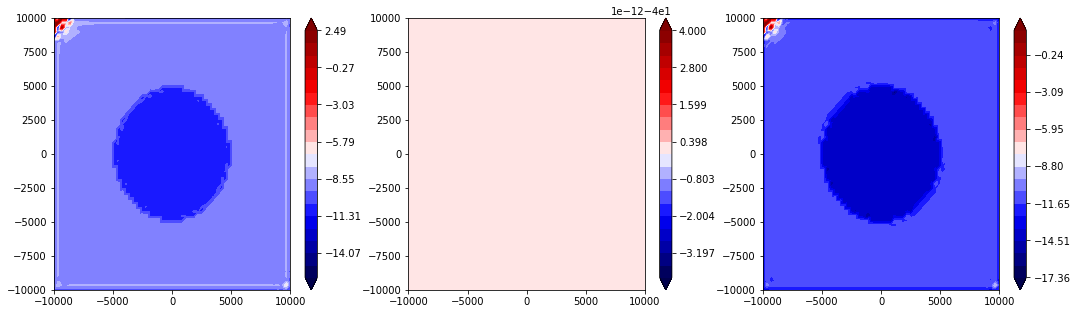

traction


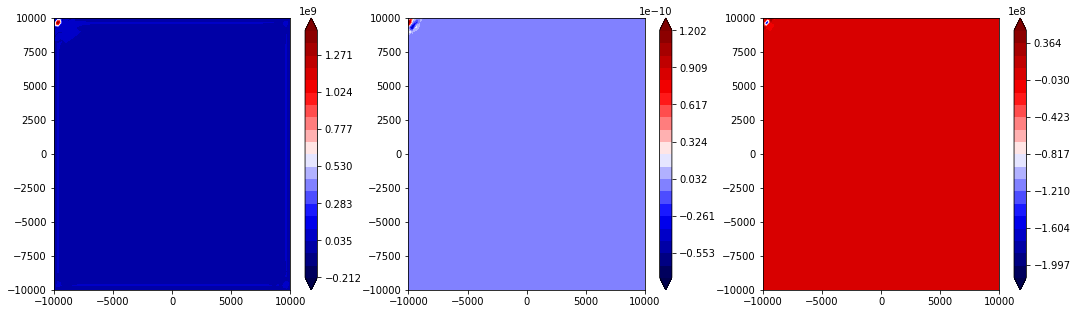

state


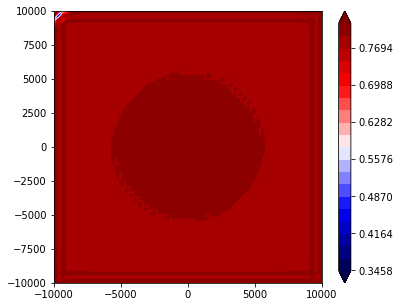

231 35.3058604531
232 35.3058604531
233 35.3058604531
234 35.3058604531
235 35.3058604531
236 35.3058604532
237 35.3058604532
238 35.3058604532
239 35.3058604532
240 35.3058604532
V


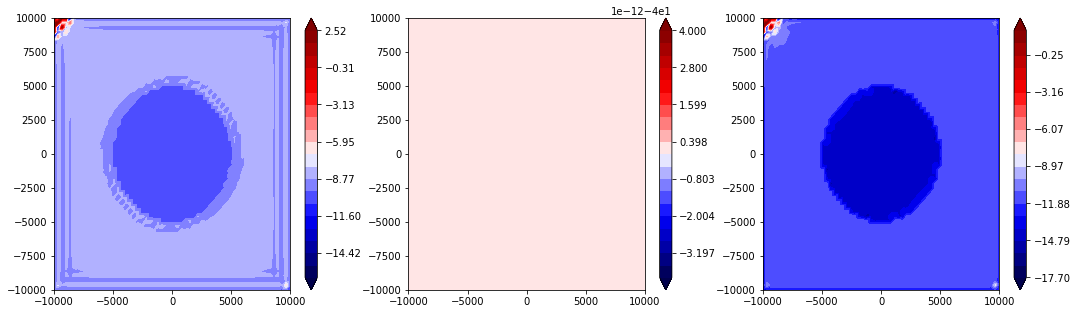

traction


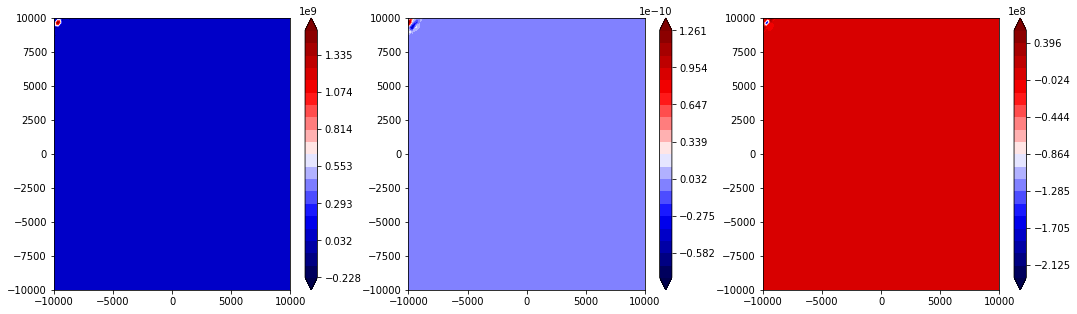

state


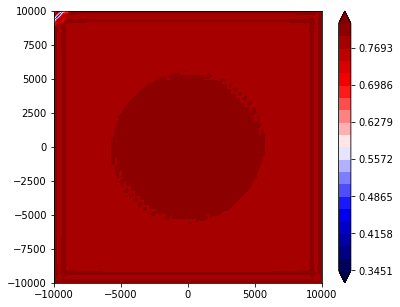

241 35.3058604532
242 35.3058604532
243 35.3058604532
244 35.3058604532
245 35.3058604532
246 35.3058604532
247 35.3058604532
248 35.3058604532
249 35.3058604532
250 35.3058604532
V


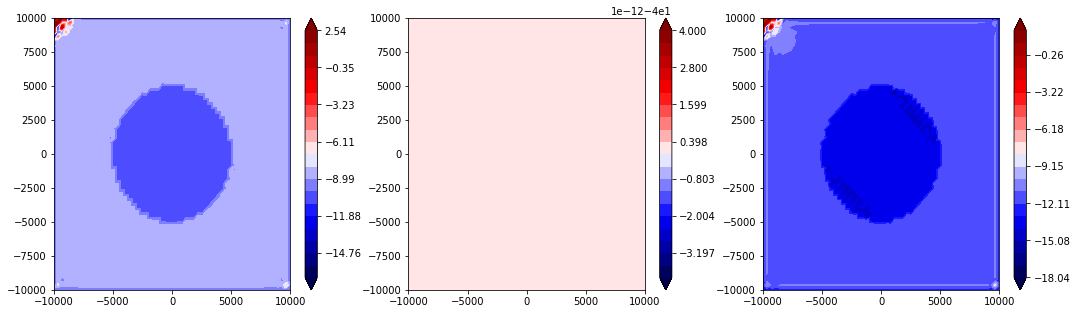

traction


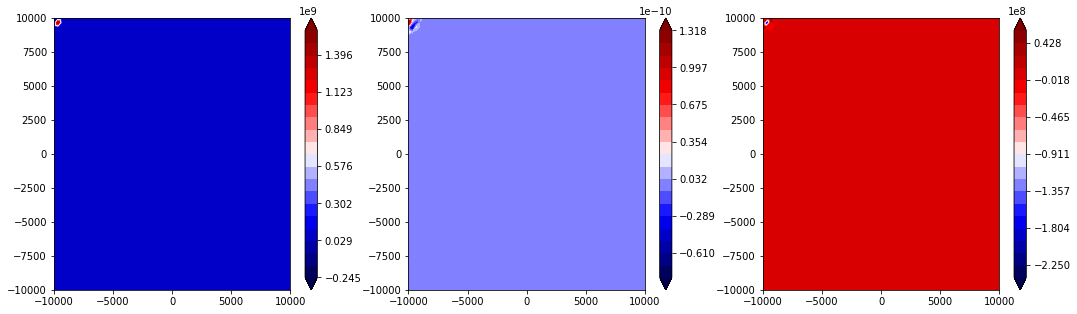

state


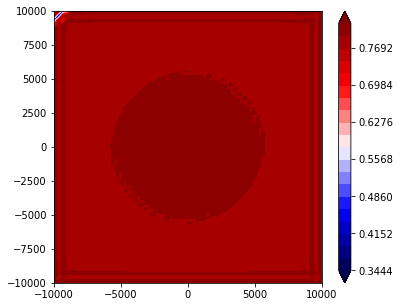

251 35.3058604532
252 35.3058604532
253 35.3058604532
254 35.3058604532
255 35.3058604532
256 35.3058604532
257 35.3058604532
258 35.3058604532
259 35.3058604532
260 35.3058604532
V


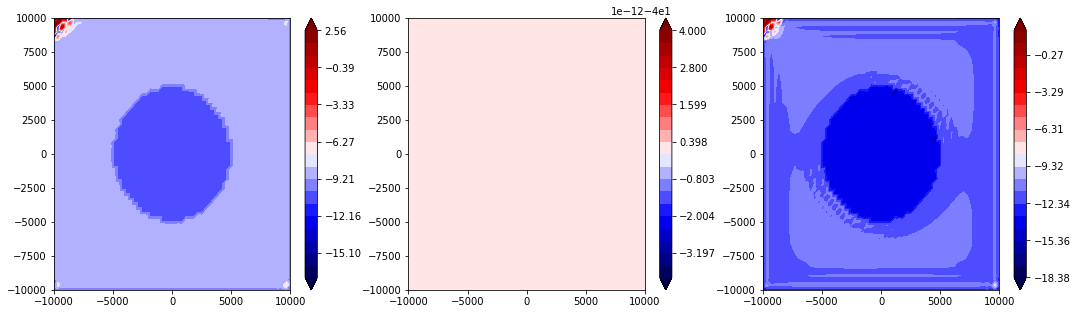

traction


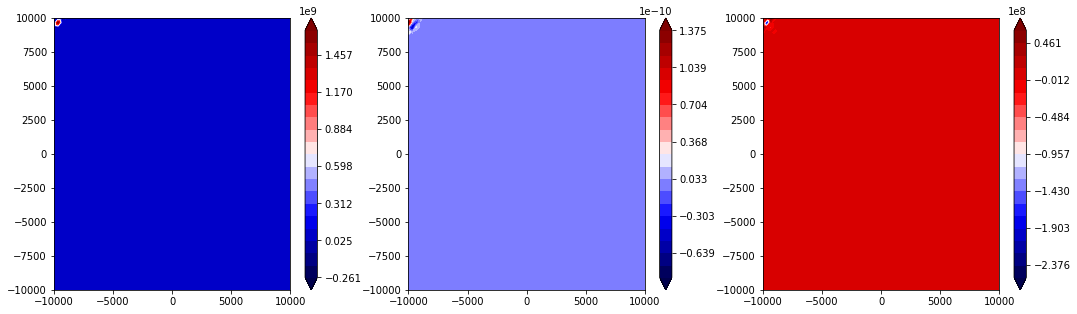

state


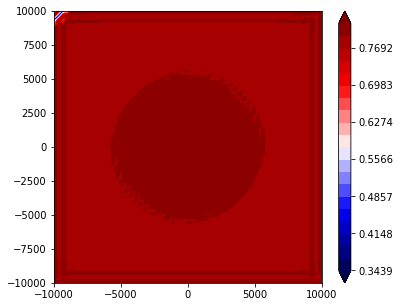

261 35.3058604532
262 35.3058604532
263 35.3058604532
264 35.3058604532
265 35.3058604532
266 35.3058604532
267 35.3058604532
268 35.3058604532
269 35.3058604532
270 35.3058604532
V


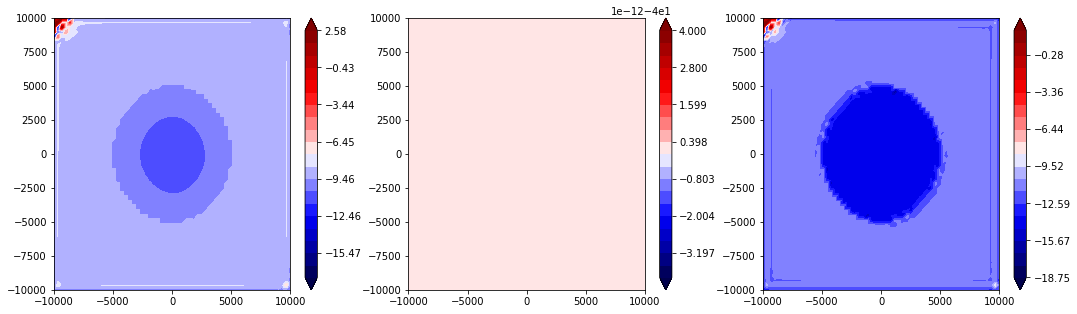

traction


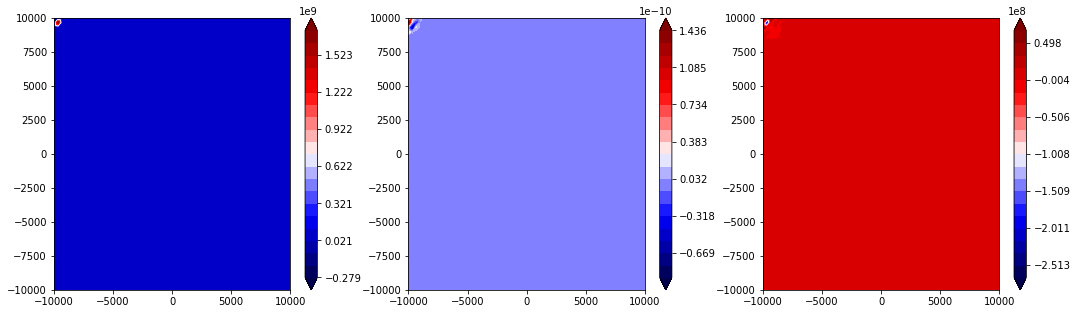

state


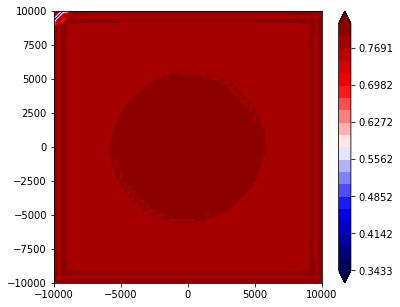

271 35.3058604532
272 35.3058604532
273 35.3058604532
274 35.3058604532
275 35.3058604532
276 35.3058604532
277 35.3058604532
278 35.3058604532
279 35.3058604532
280 35.3058604533
V


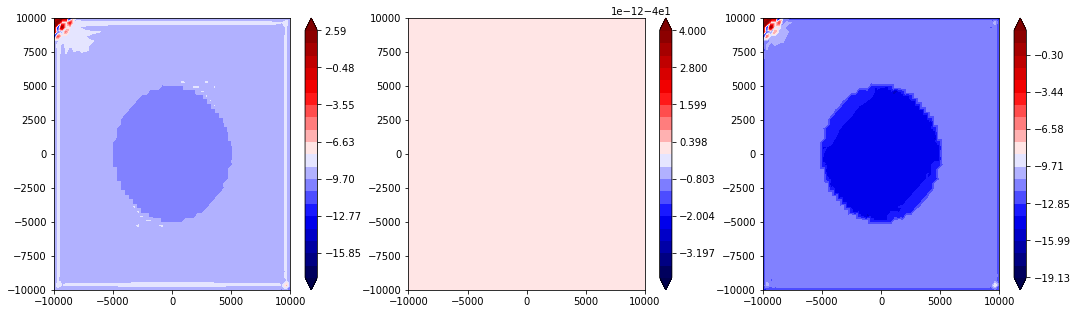

traction


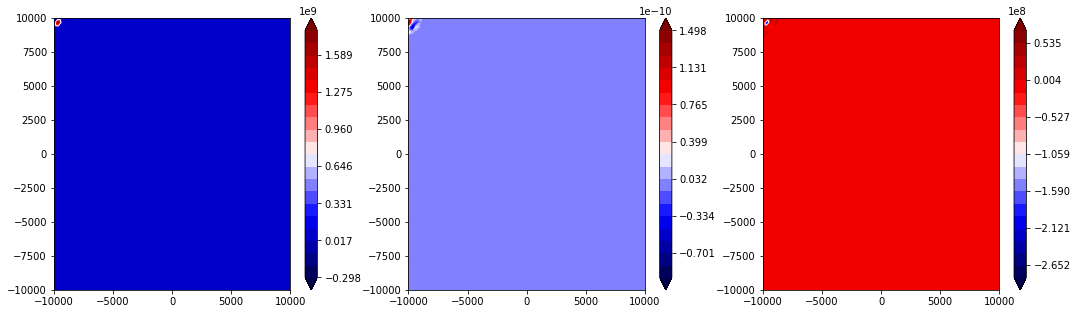

state


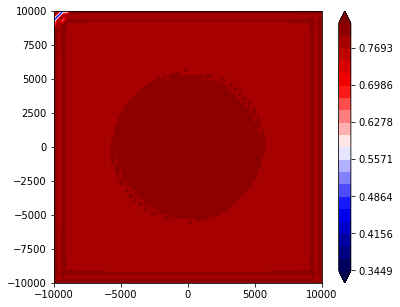

281 35.3058604533
282 35.3058604533
283 35.3058604533
284 35.3058604533
285 35.3058604533
286 35.3058604533
287 35.3058604533
288 35.3058604533
289 35.3058604533
290 35.3058604533
V


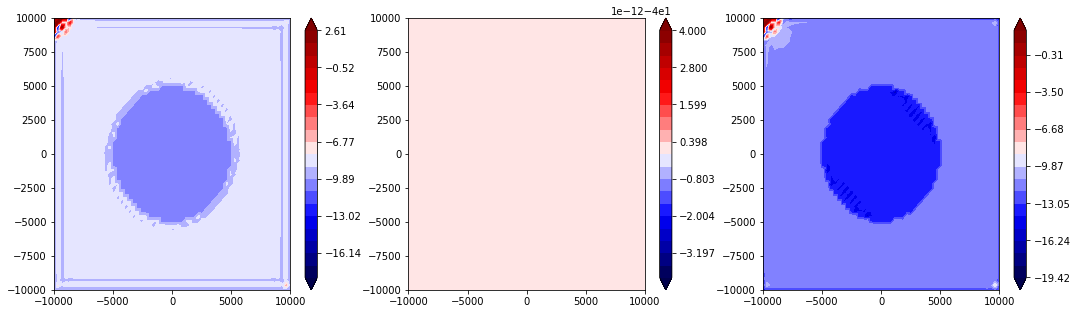

traction


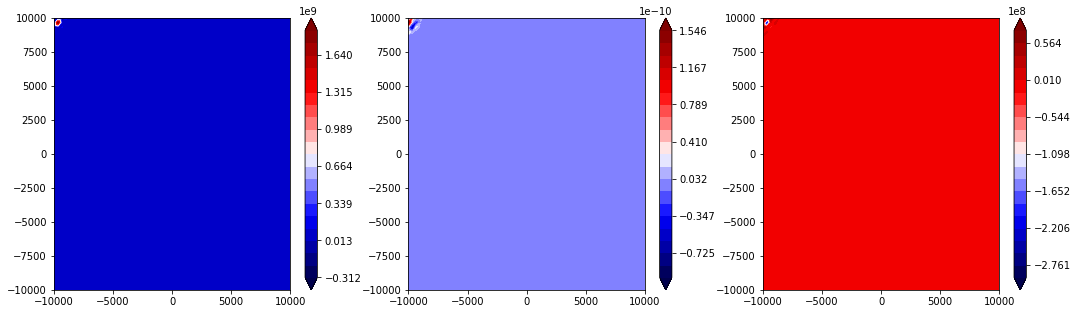

state


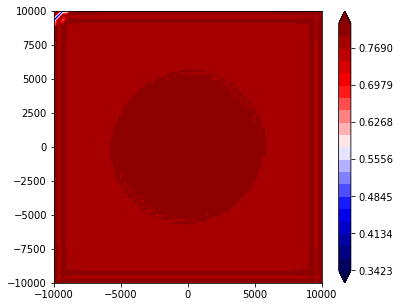

291 35.3058604533
292 35.3058604533
293 35.3058604533
294 35.3058604533
295 35.3058604533
296 35.3058604533
297 35.3058604533
298 35.3058604533
299 35.3058604533
300 35.3058604533
V


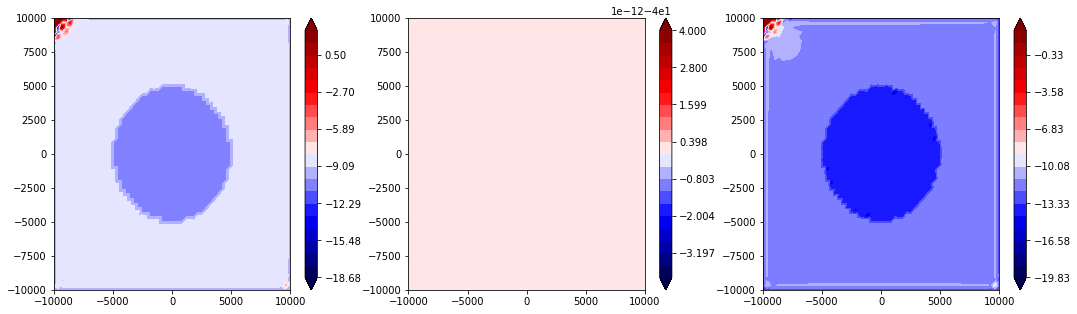

traction


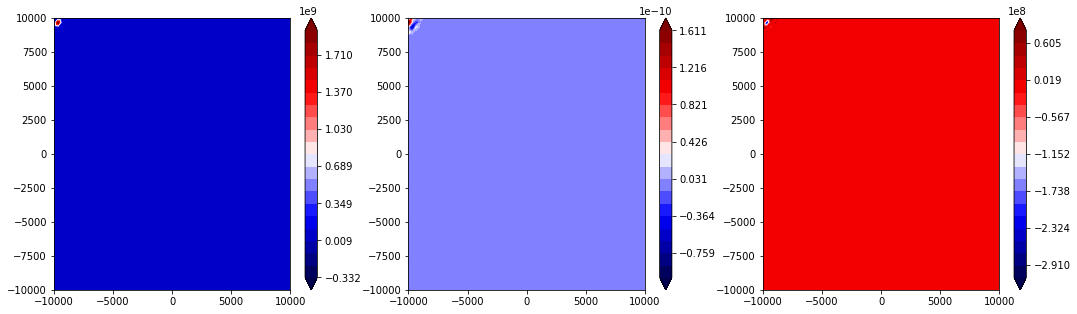

state


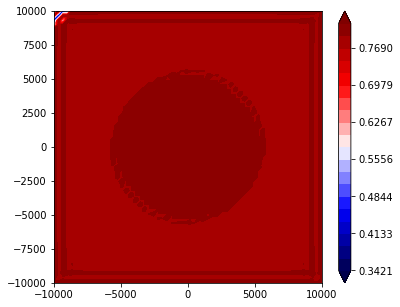

301 35.3058604533
302 35.3058604533
303 35.3058604533
304 35.3058604533
305 35.3058604533
306 35.3058604533
307 35.3058604533
308 35.3058604533
309 35.3058604533
310 35.3058604533
V


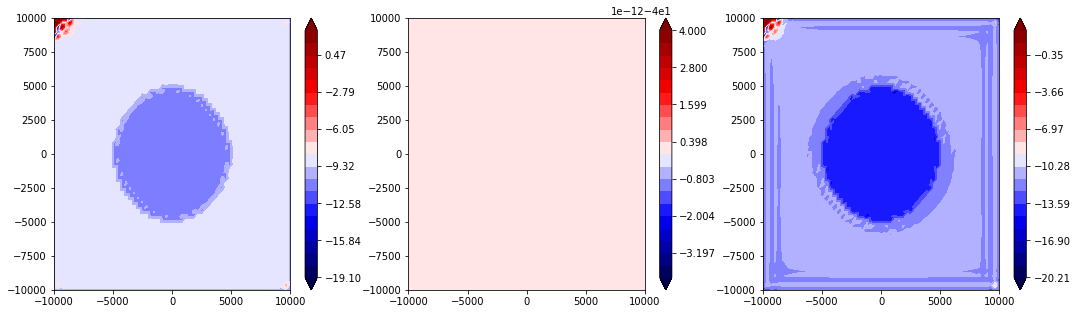

traction


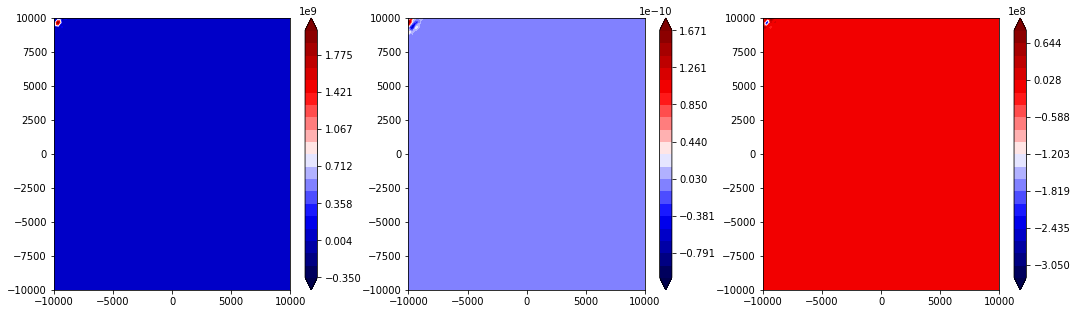

state


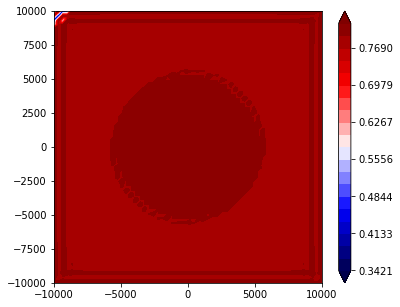

311 35.3058604533
312 35.3058604533
313 35.3058604533
314 35.3058604533
315 35.3058604533
316 35.3058604533
317 35.3058604533
318 35.3058604533
319 35.3058604533
320 35.3058604533
V


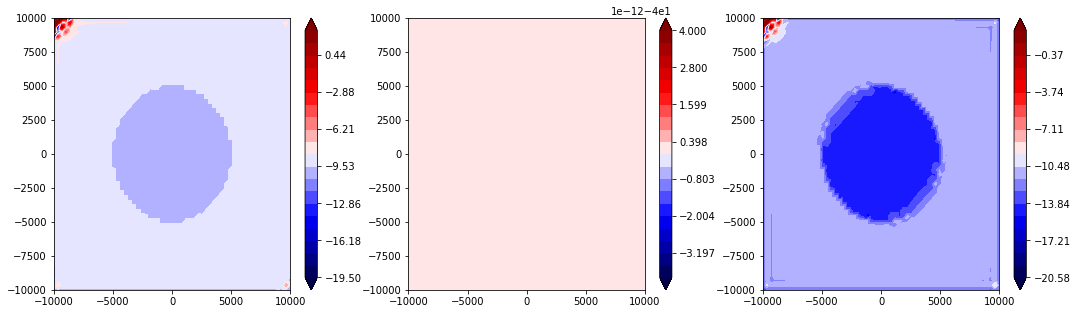

traction


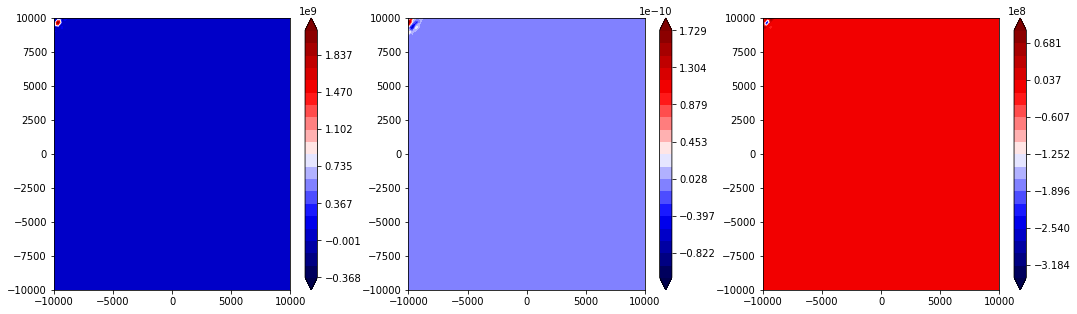

state


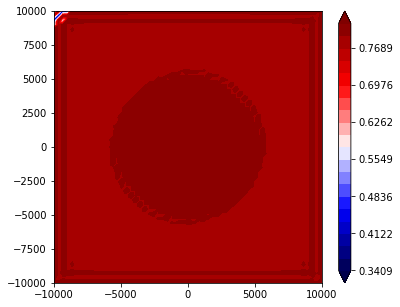

321 35.3058604533
322 35.3058604533
323 35.3058604533
324 35.3058604533
325 35.3058604533
326 35.3058604533
327 35.3058604533
328 35.3058604533
329 35.3058604533
330 35.3058604533
V


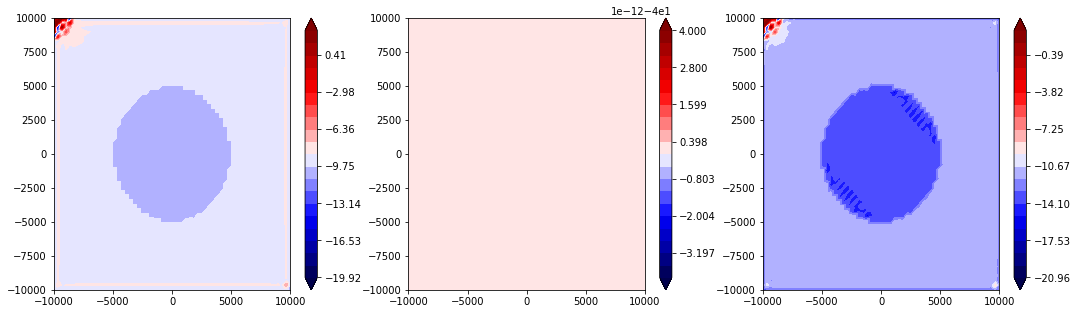

traction


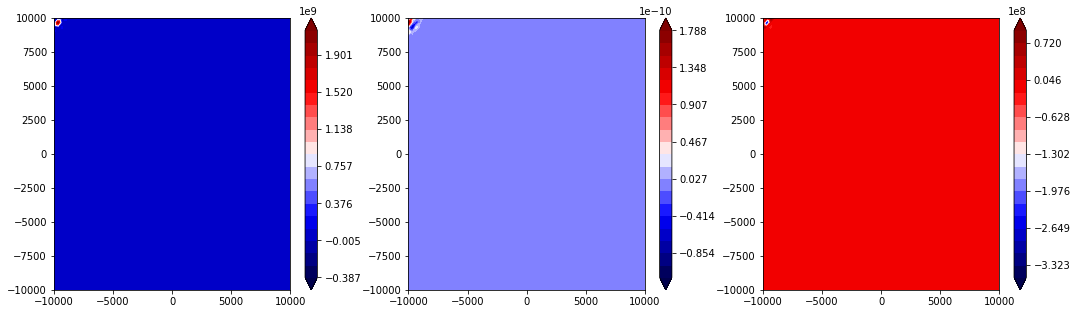

state


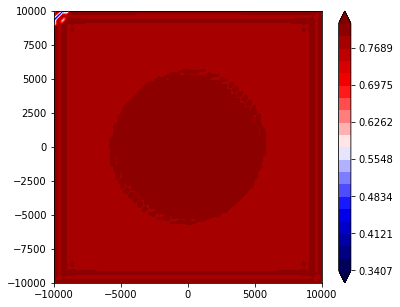

331 35.3058604533
332 35.3058604533
333 35.3058604533
334 35.3058604534
335 35.3058604534
336 35.3058604534
337 35.3058604534
338 35.3058604534
339 35.3058604534
340 35.3058604534
V


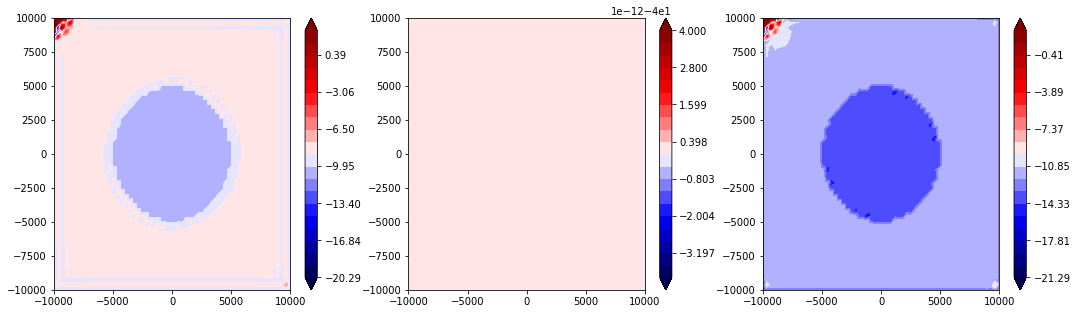

traction


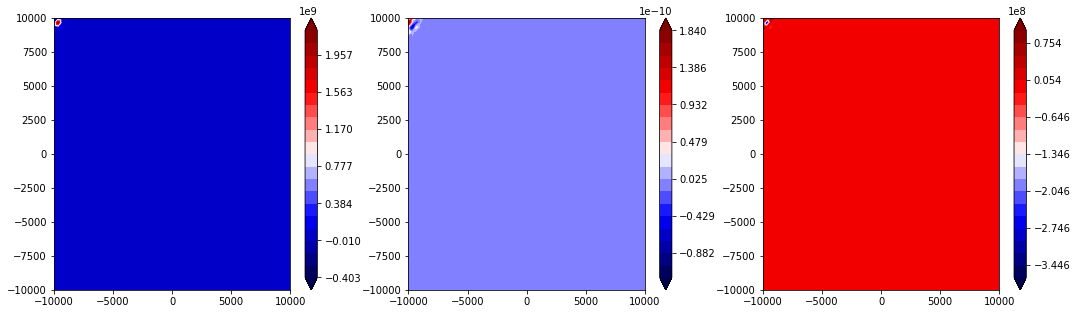

state


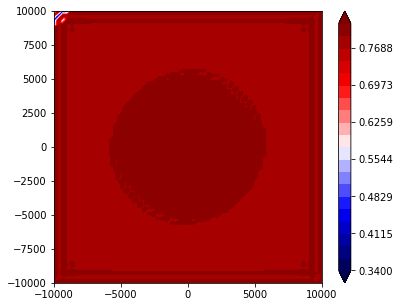

341 35.3058604534
342 35.3058604534
343 35.3058604534
344 35.3058604534
345 35.3058604534
346 35.3058604534
347 35.3058604534
348 35.3058604534
349 35.3058604534
350 35.3058604534
V


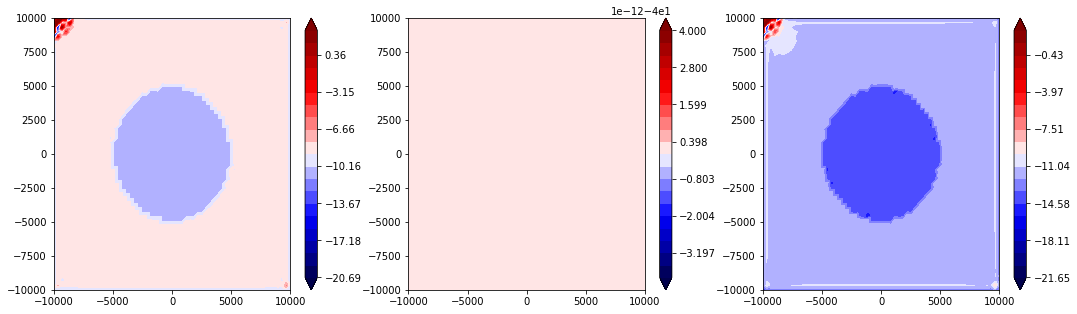

traction


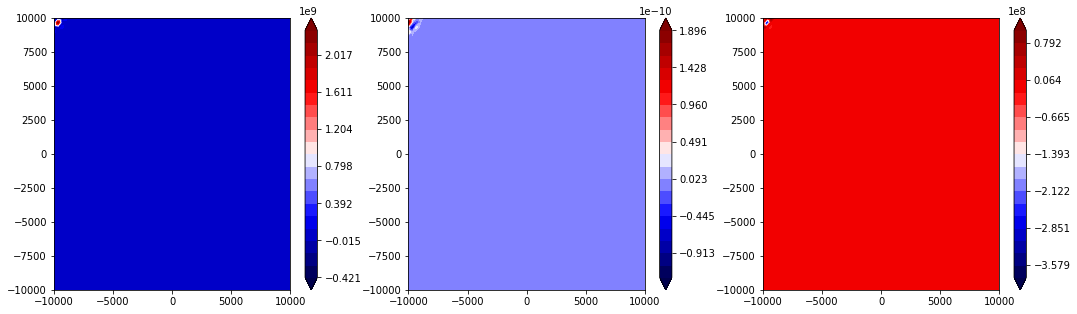

state


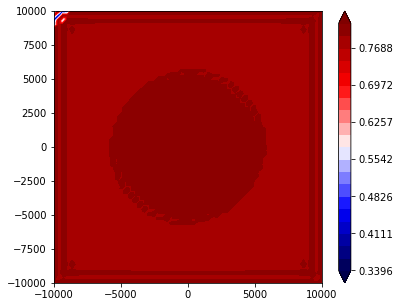

351 35.3058604534
352 35.3058604534
353 35.3058604534
354 35.3058604534
355 35.3058604534
356 35.3058604534
357 35.3058604534
358 35.3058604534
359 35.3058604534
360 35.3058604534
V


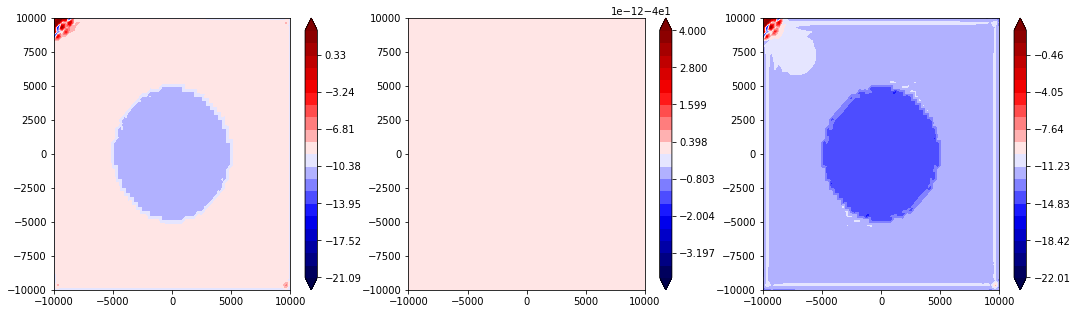

traction


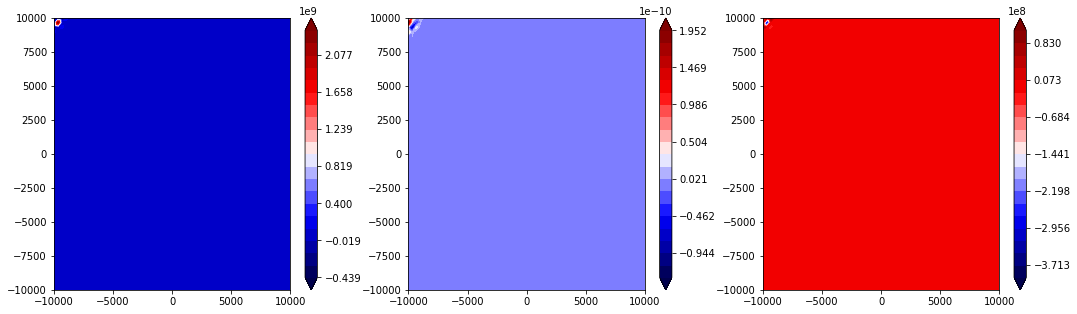

state


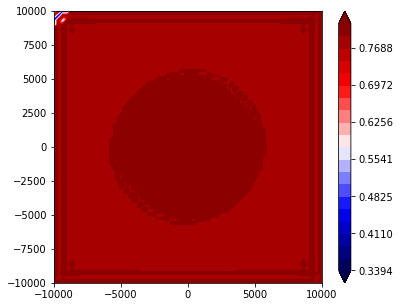

361 35.3058604534
362 35.3058604534
363 35.3058604534
364 35.3058604534
365 35.3058604534
366 35.3058604534
367 35.3058604534
368 35.3058604534
369 35.3058604534
370 35.3058604534
V


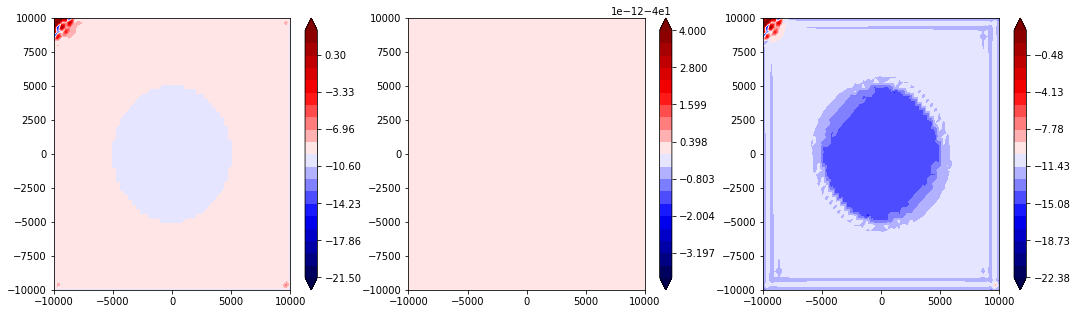

traction


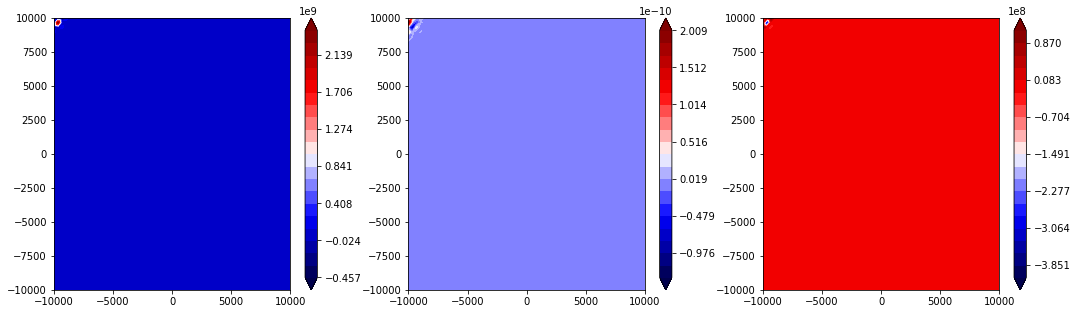

state


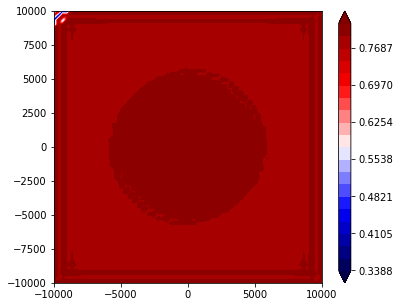

371 35.3058604534
372 35.3058604534
373 35.3058604534
374 35.3058604534
375 35.3058604534
376 35.3058604534
377 35.3058604534
378 35.3058604534
379 35.3058604534
380 35.3058604534
V


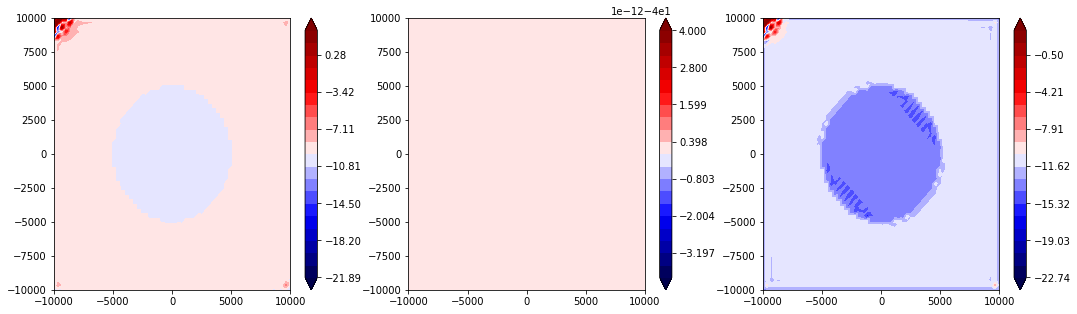

traction


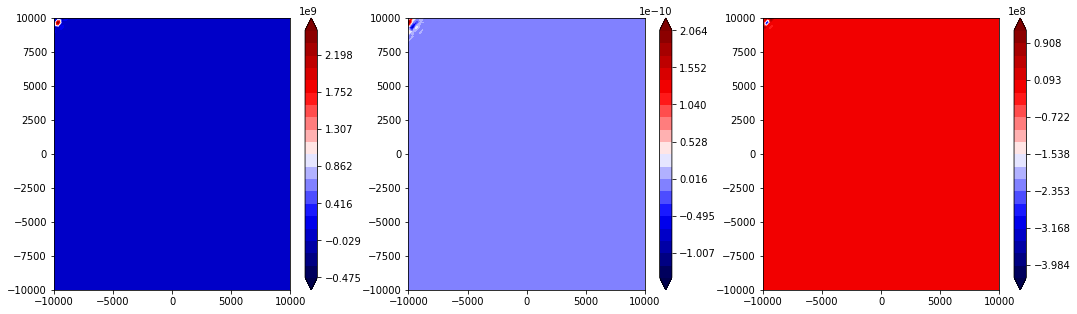

state


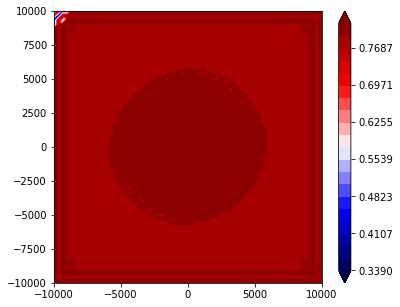

381 35.3058604534
382 35.3058604534
383 35.3058604534
384 35.3058604534
385 35.3058604534
386 35.3058604534
387 35.3058604534
388 35.3058604534
389 35.3058604534
390 35.3058604534
V


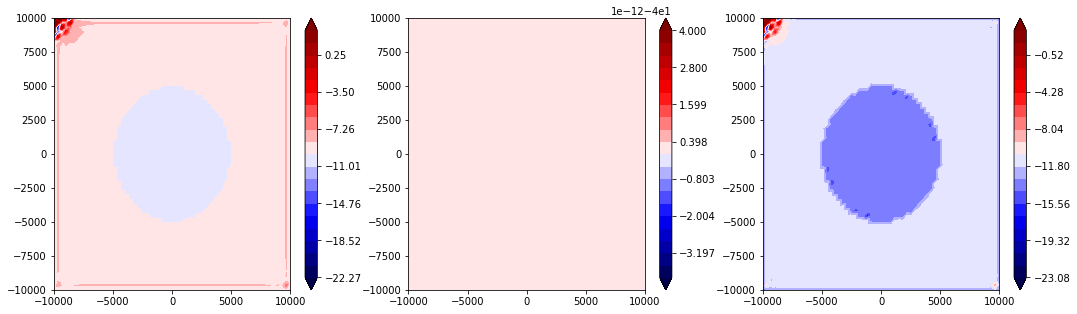

traction


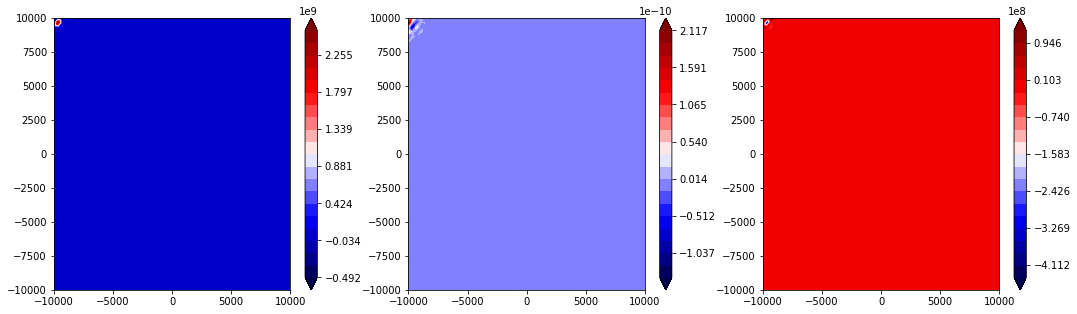

state


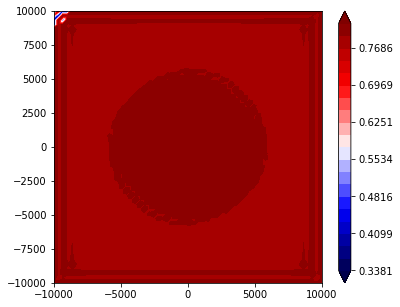

391 35.3058604534
392 35.3058604534
393 35.3058604534
394 35.3058604534
395 35.3058604534
396 35.3058604534
397 35.3058604534
398 35.3058604534
399 35.3058604534
400 35.3058604534
V


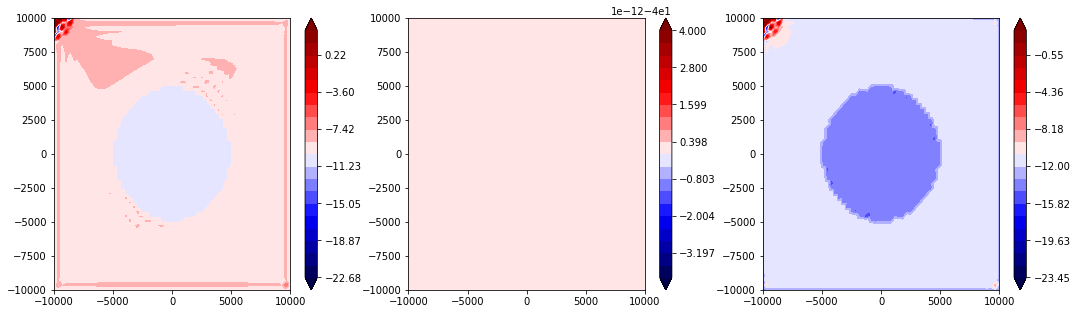

traction


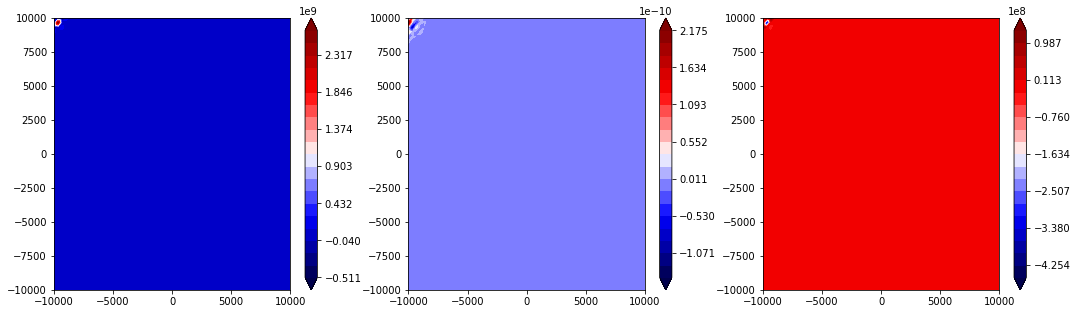

state


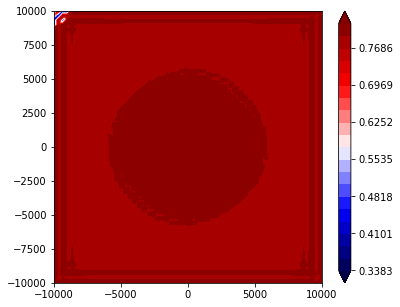

401 35.3058604534
402 35.3058604534
403 35.3058604535
404 35.3058604535
405 35.3058604535
406 35.3058604535
407 35.3058604535
408 35.3058604535
409 35.3058604535
410 35.3058604535
V


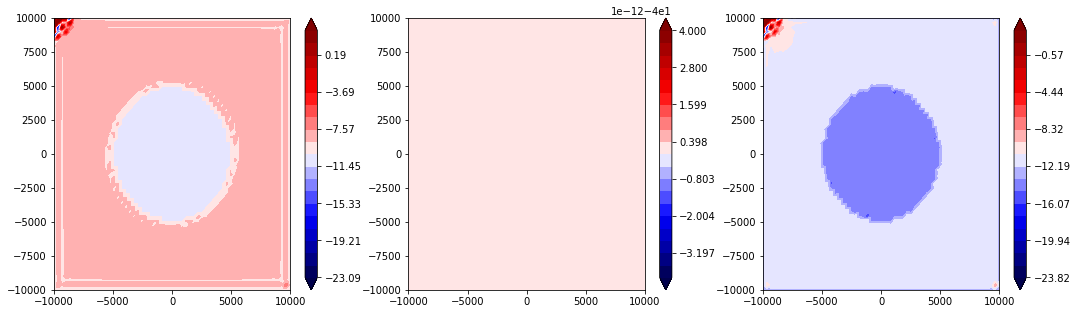

traction


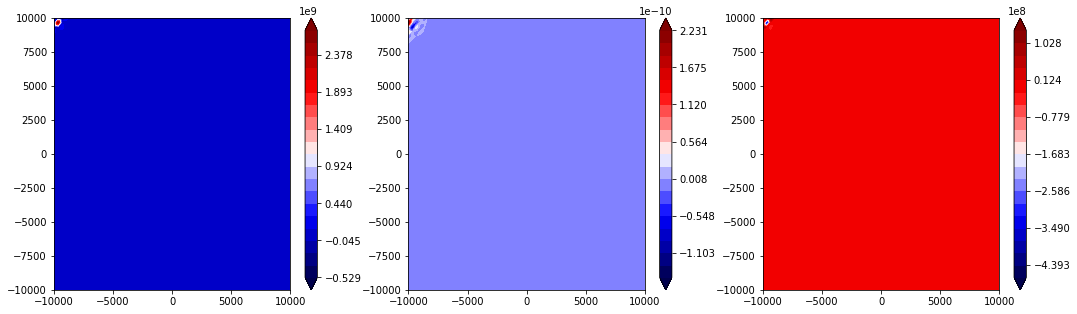

state


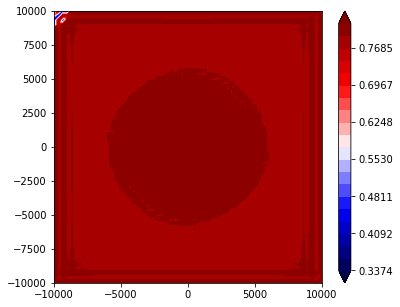

411 35.3058604535
412 35.3058604535
413 35.3058604535
414 35.3058604535
415 35.3058604535
416 35.3058604535
417 35.3058604535
418 35.3058604535
419 35.3058604535
420 35.3058604535
V


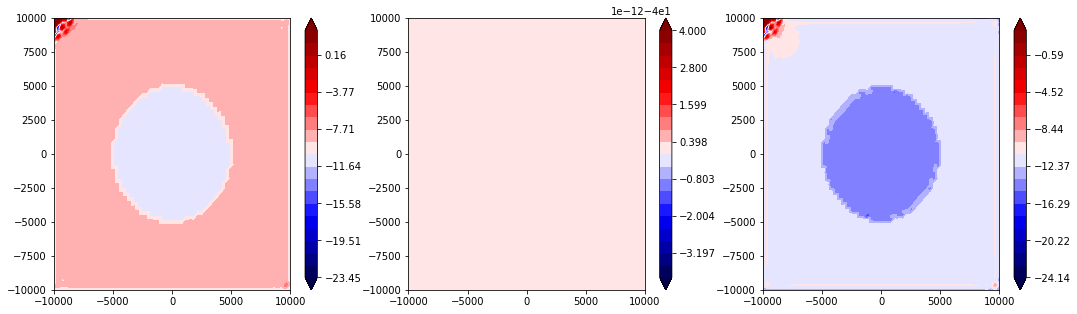

traction


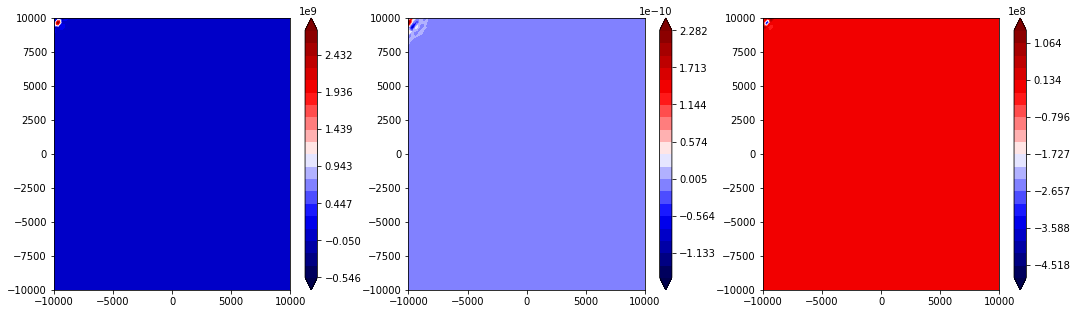

state


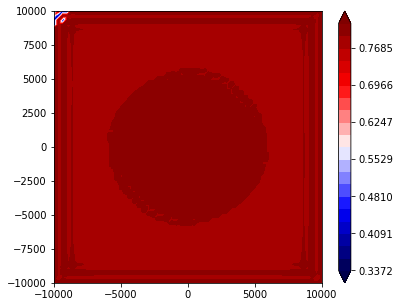

421 35.3058604535
422 35.3058604535
423 35.3058604535
424 35.3058604535
425 35.3058604535
426 35.3058604535
427 35.3058604535
428 35.3058604535
429 35.3058604535
430 35.3058604535
V


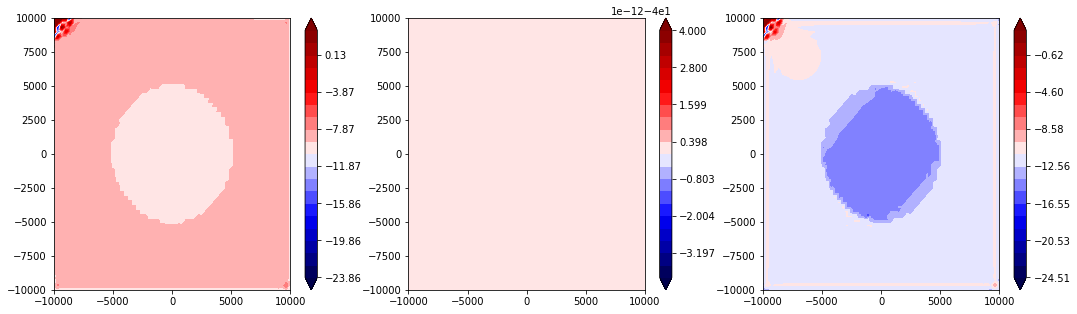

traction


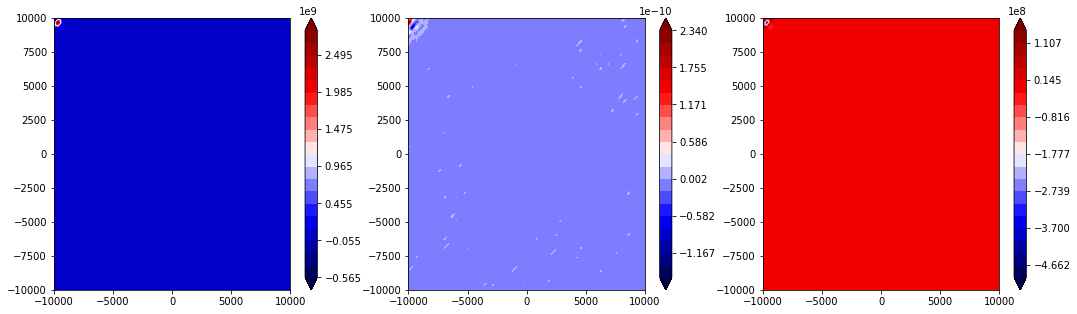

state


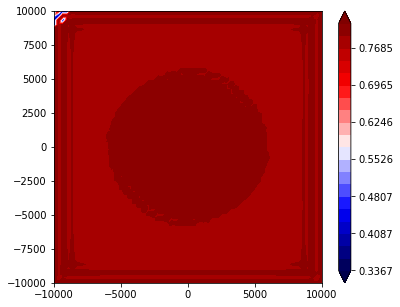

431 35.3058604535
432 35.3058604535
433 35.3058604535
434 35.3058604535
435 35.3058604535
436 35.3058604535
437 35.3058604535
438 35.3058604535
439 35.3058604535
440 35.3058604535
V


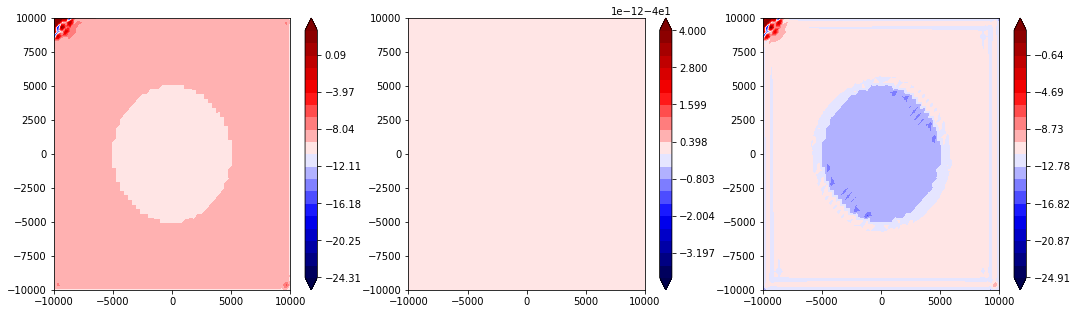

traction


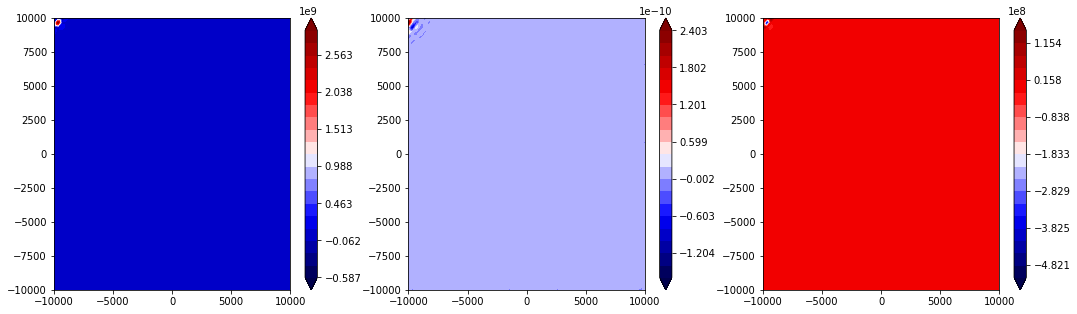

state


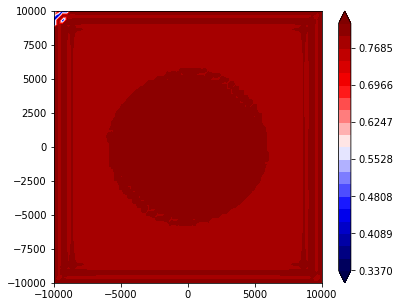

441 35.3058604535
442 35.3058604535
443 35.3058604535
444 35.3058604535
445 35.3058604535
446 35.3058604535
447 35.3058604535
448 35.3058604535
449 35.3058604535
450 35.3058604535
V


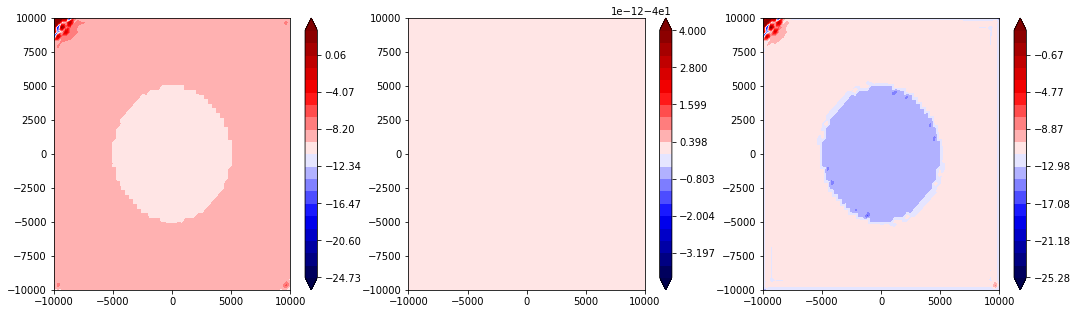

traction


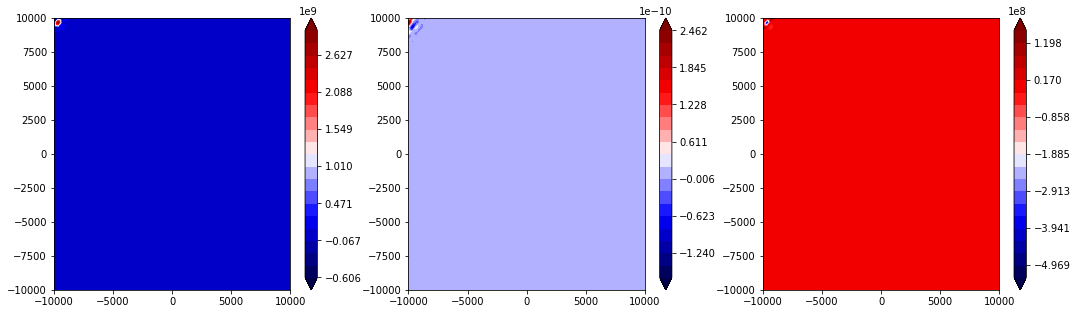

state


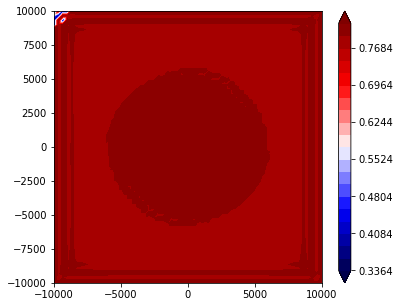

451 35.3058604535
452 35.3058604535
453 35.3058604535
454 35.3058604535
455 35.3058604535
456 35.3058604535
457 35.3058604535
458 35.3058604535
459 35.3058604535
460 35.3058604535
V


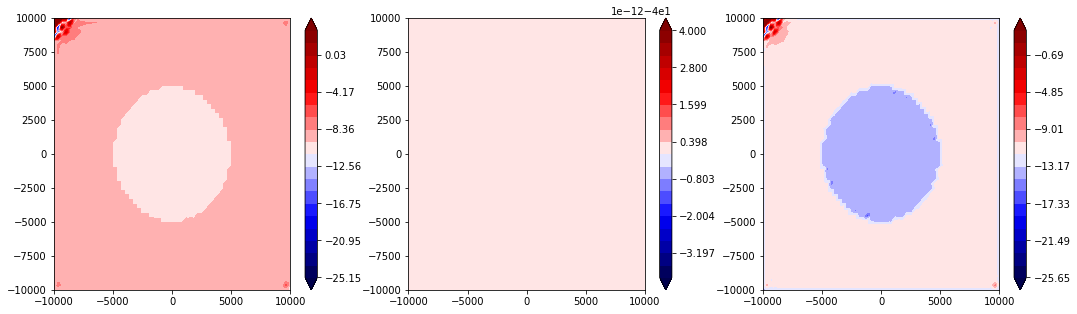

traction


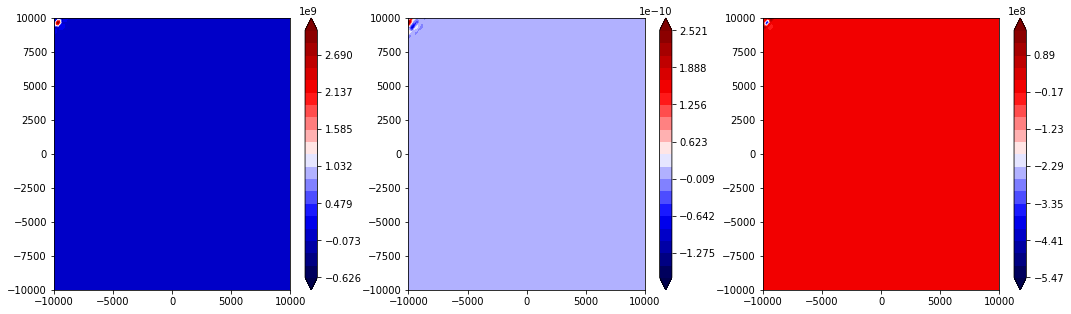

state


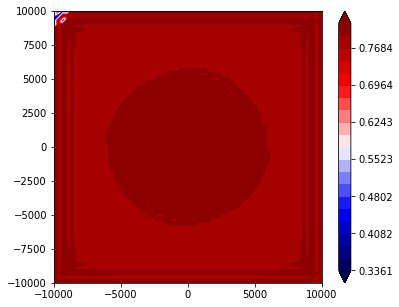

461 35.3058604535
462 35.3058604535
463 35.3058604535
464 35.3058604535
465 35.3058604535
466 35.3058604535
467 35.3058604535
468 35.3058604535
469 35.3058604535
470 35.3058604535
V


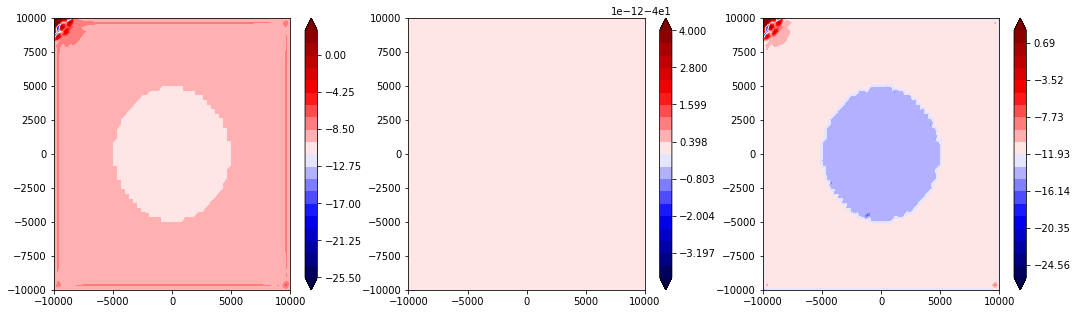

traction


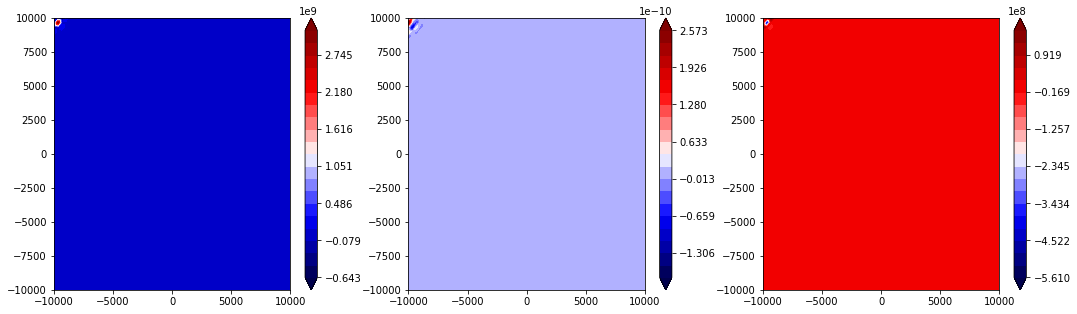

state


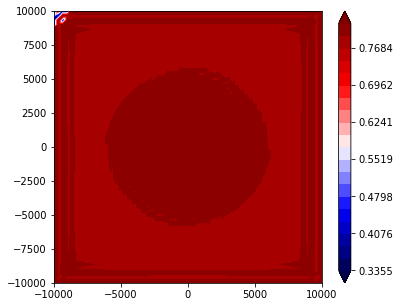

471 35.3058604535
472 35.3058604535
473 35.3058604535
474 35.3058604535
475 35.3058604535
476 35.3058604535
477 35.3058604535
478 35.3058604535
479 35.3058604535
480 35.3058604535
V


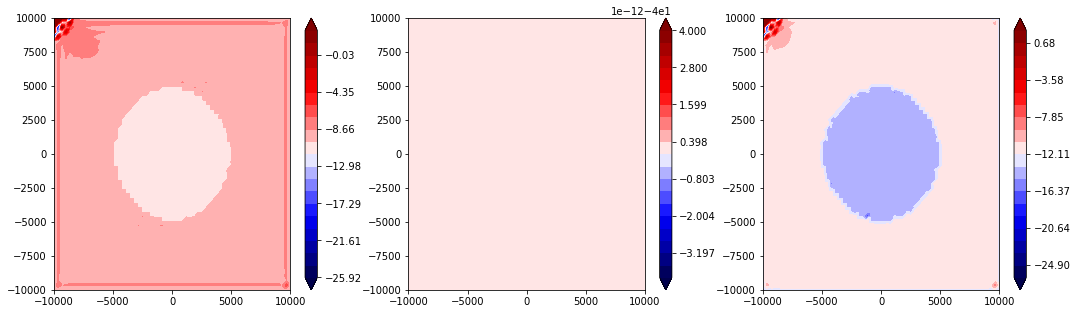

traction


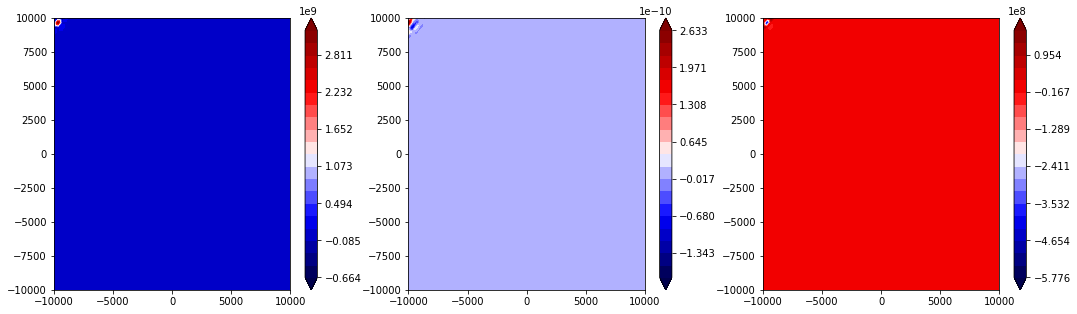

state


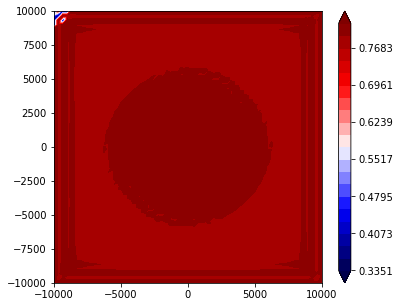

481 35.3058604535
482 35.3058604535
483 35.3058604535
484 35.3058604536
485 35.3058604536
486 35.3058604536
487 35.3058604536
488 35.3058604536
489 35.3058604536
490 35.3058604536
V


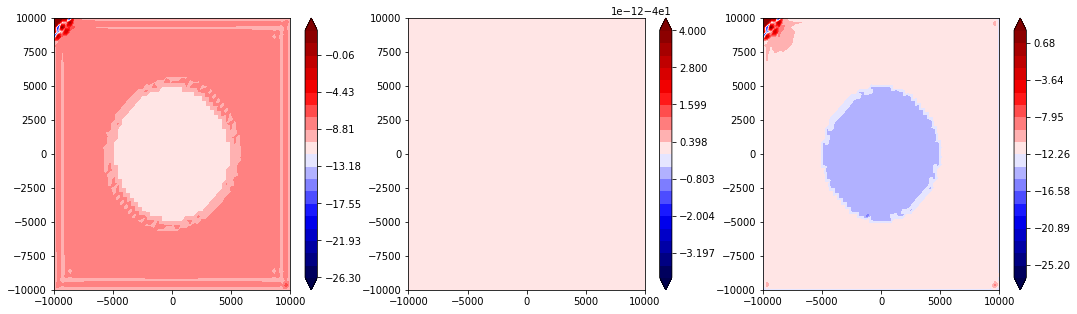

traction


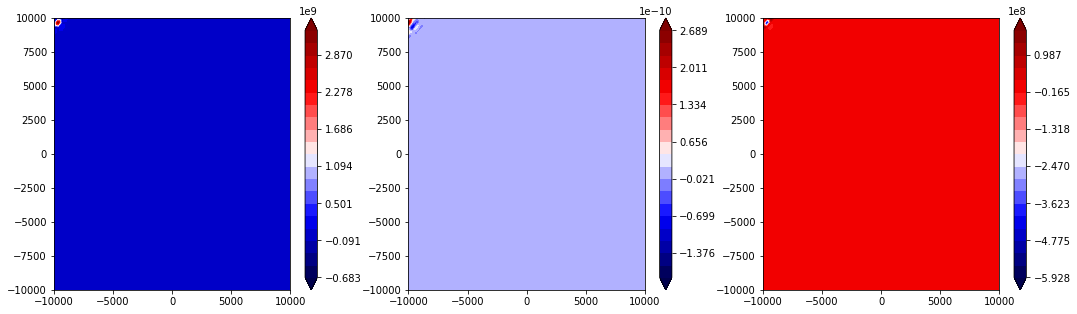

state


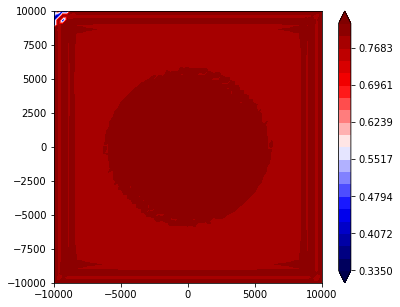

491 35.3058604536
492 35.3058604536
493 35.3058604536
494 35.3058604536
495 35.3058604536
496 35.3058604536
497 35.3058604536
498 35.3058604536
499 35.3058604536
500 35.3058604536
V


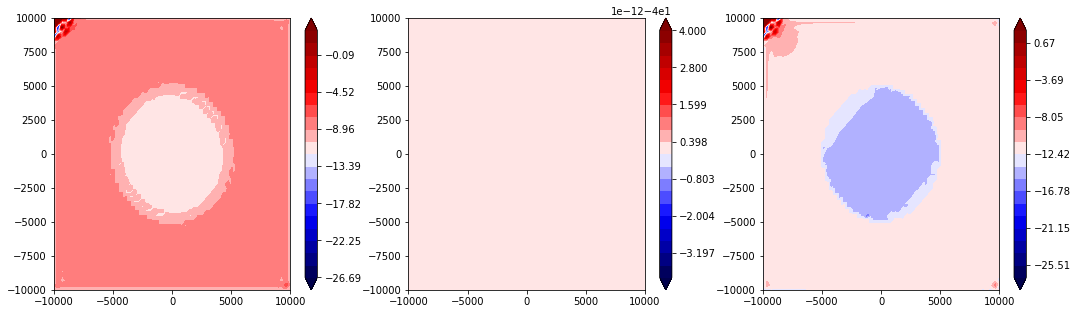

traction


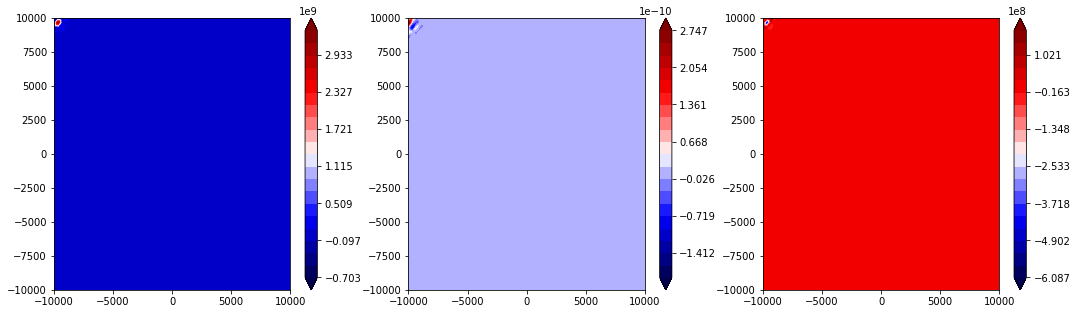

state


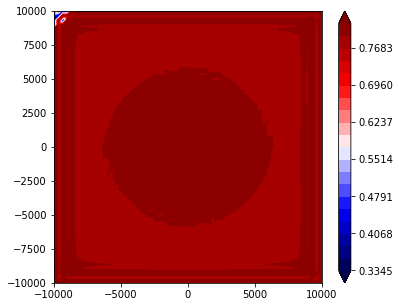

501 35.3058604536
502 35.3058604536
503 35.3058604536
504 35.3058604536
505 35.3058604536
506 35.3058604536
507 35.3058604536
508 35.3058604536
509 35.3058604536
510 35.3058604536
V


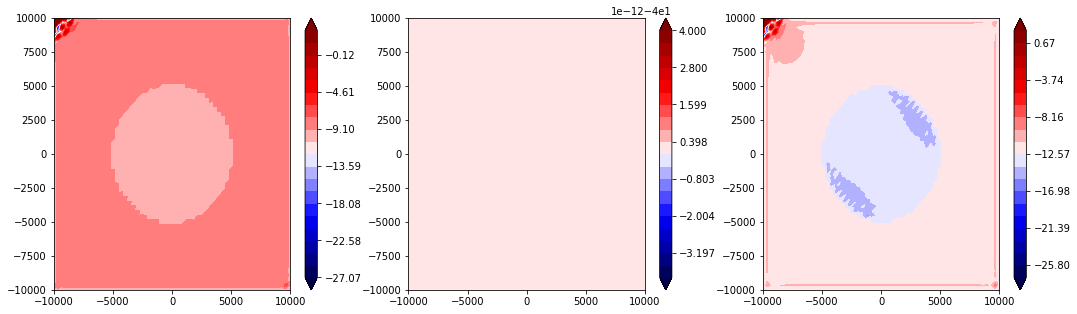

traction


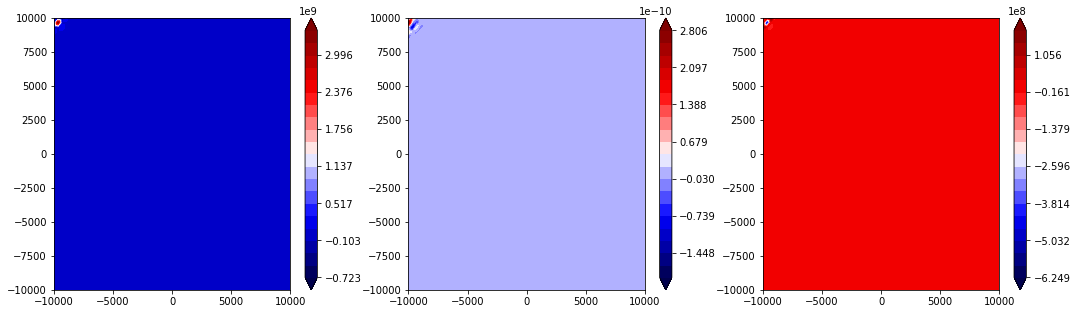

state


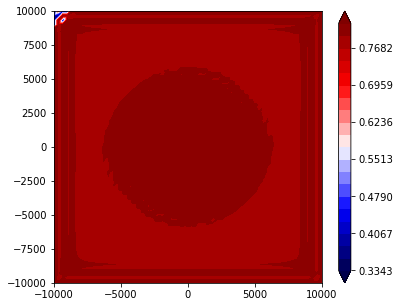

511 35.3058604536
512 35.3058604536
513 35.3058604536
514 35.3058604536
515 35.3058604536
516 35.3058604536
517 35.3058604536
518 35.3058604536
519 35.3058604536
520 35.3058604536
V


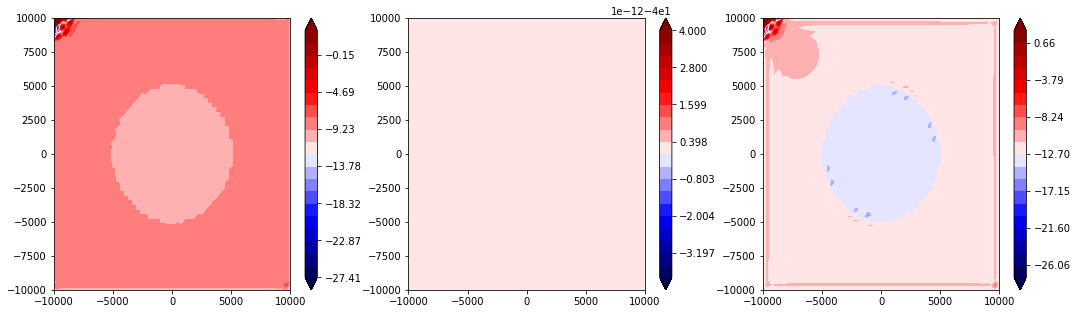

traction


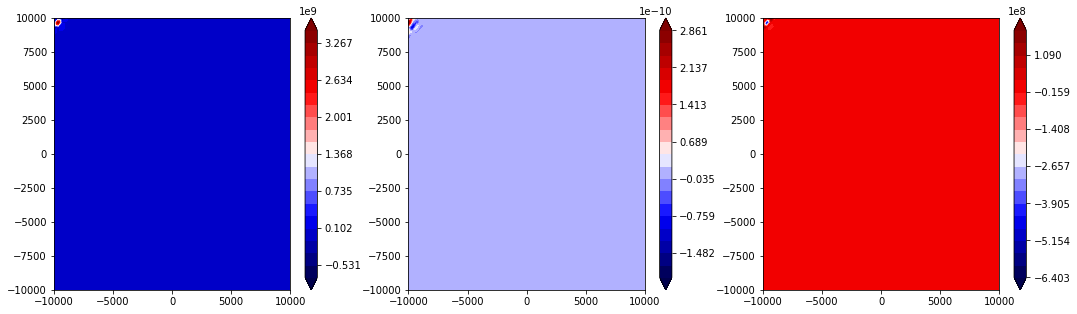

state


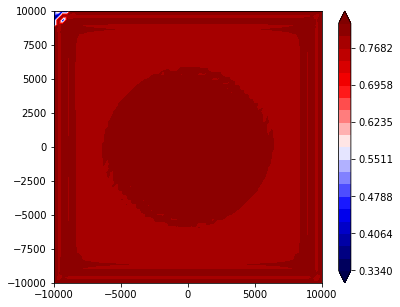

521 35.3058604536
522 35.3058604536
523 35.3058604536
524 35.3058604536
525 35.3058604536
526 35.3058604536
527 35.3058604536
528 35.3058604536
529 35.3058604536
530 35.3058604536
V


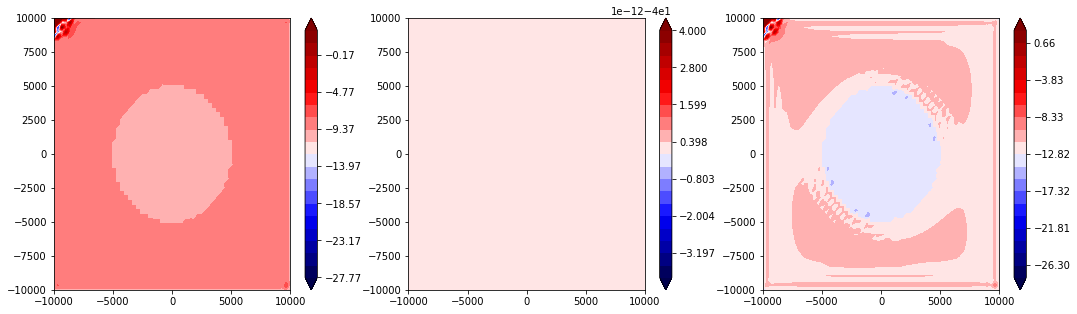

traction


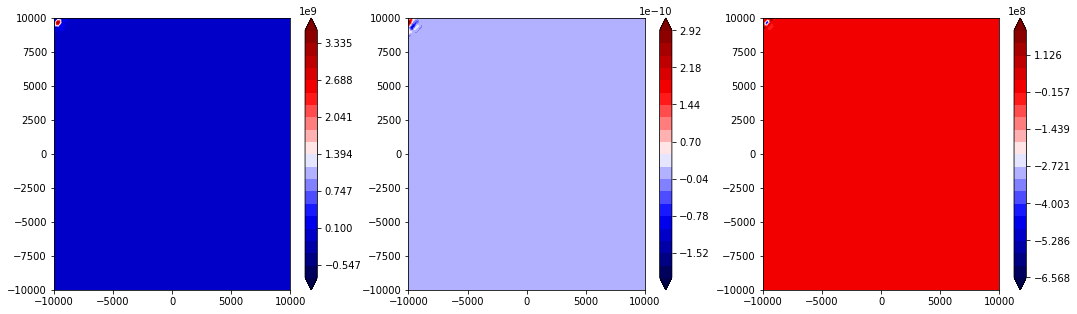

state


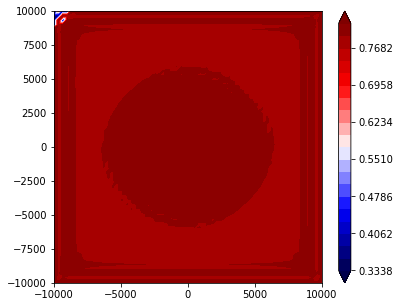

531 35.3058604536
532 35.3058604536
533 35.3058604536
534 35.3058604536
535 35.3058604536
536 35.3058604536
537 35.3058604536
538 35.3058604536
539 35.3058604536
540 35.3058604536
V


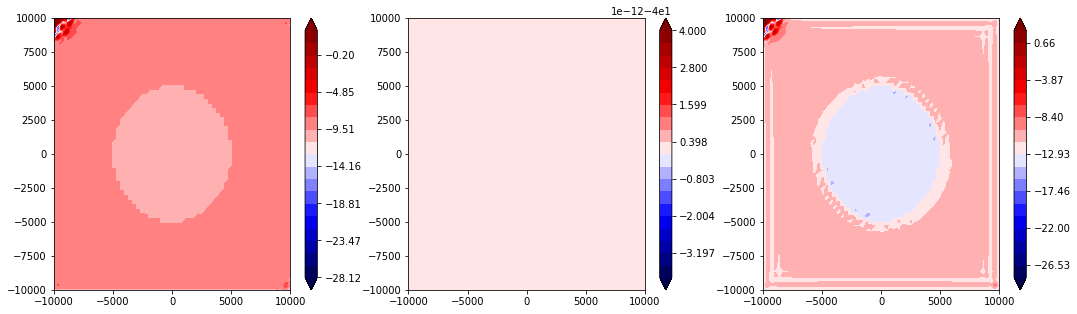

traction


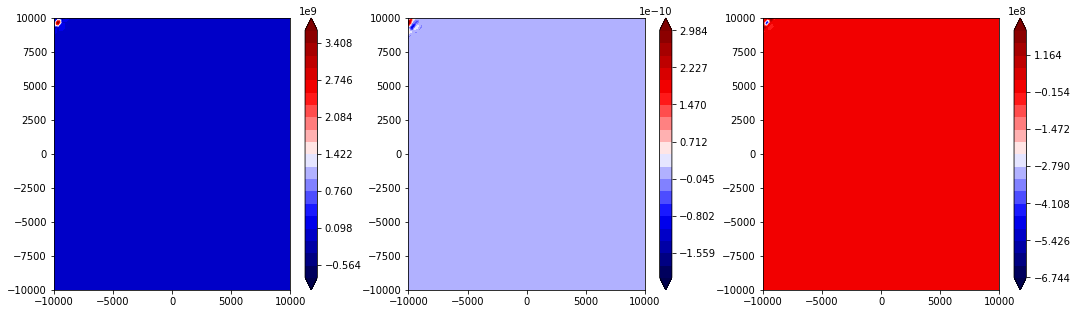

state


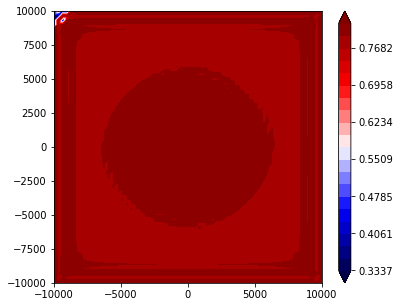

541 35.3058604536
542 35.3058604536
543 35.3058604536
544 35.3058604536
545 35.3058604536
546 35.3058604536
547 35.3058604536
548 35.3058604536
549 35.3058604536
550 35.3058604536
V


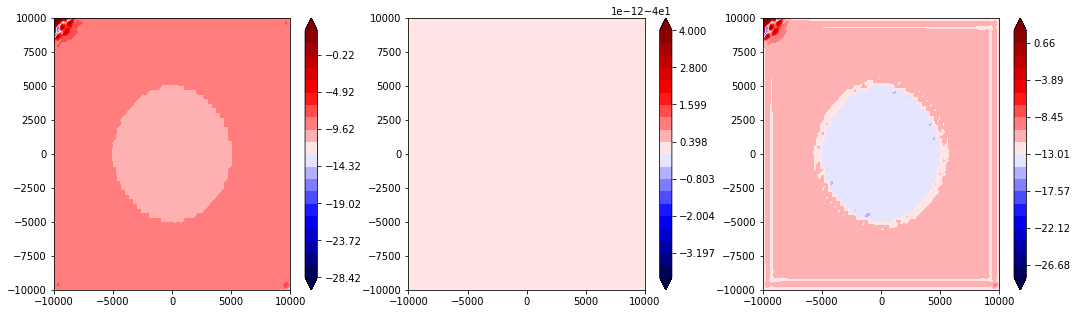

traction


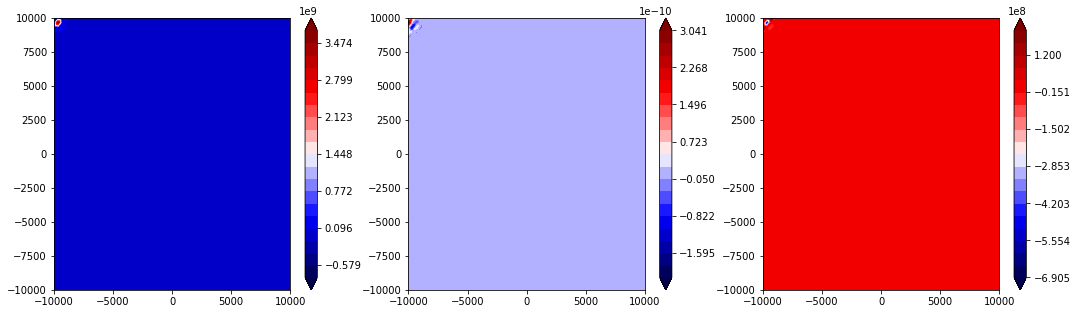

state


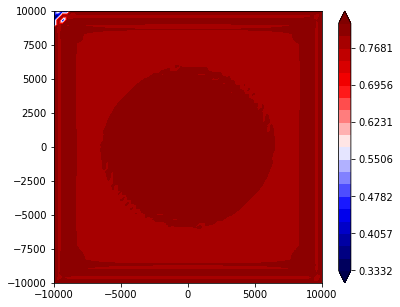

551 35.3058604536
552 35.3058604536
553 35.3058604536
554 35.3058604536
555 35.3058604536
556 35.3058604536
557 35.3058604536
558 35.3058604536
559 35.3058604536
560 35.3058604536
V


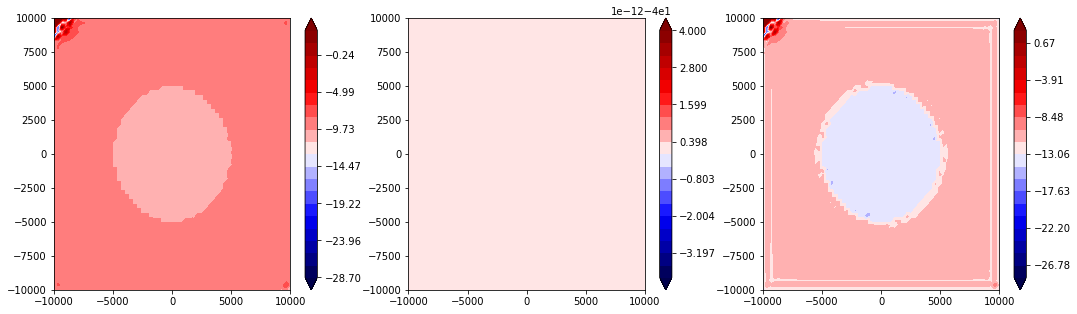

traction


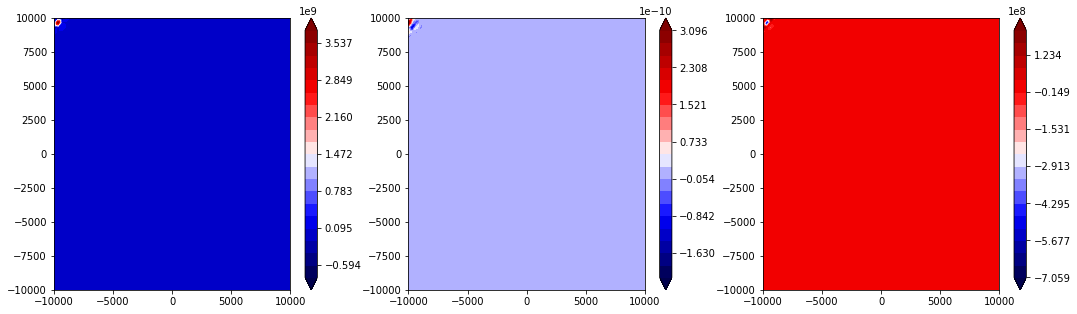

state


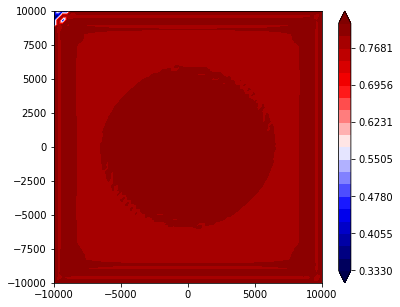

561 35.3058604536
562 35.3058604536
563 35.3058604536
564 35.3058604536
565 35.3058604536
566 35.3058604536
567 35.3058604536
568 35.3058604536
569 35.3058604536
570 35.3058604536
V


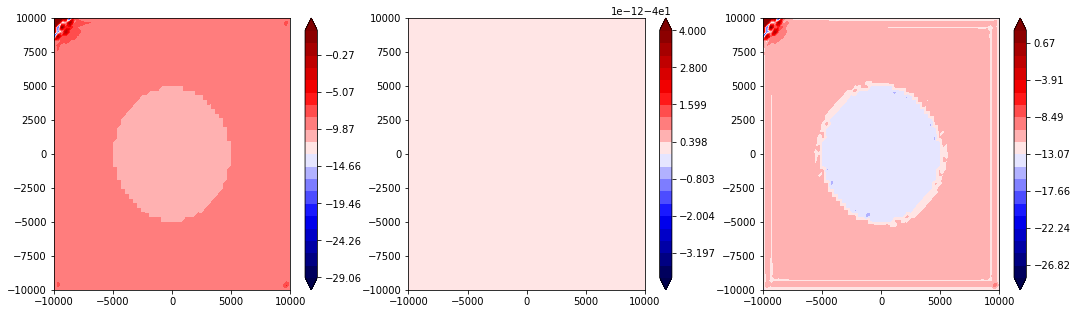

traction


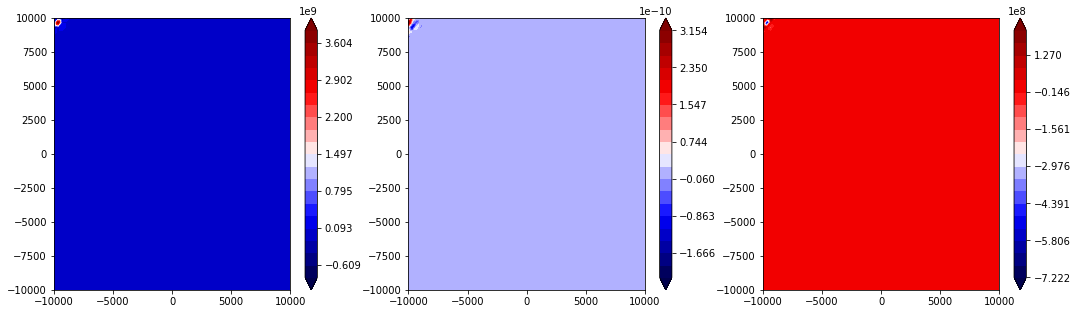

state


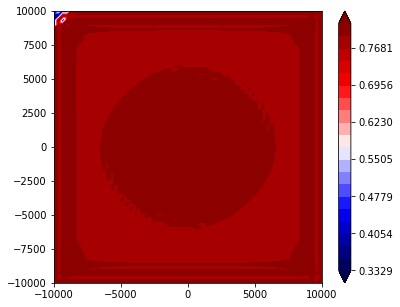

571 35.3058604536
572 35.3058604536
573 35.3058604536
574 35.3058604536
575 35.3058604536
576 35.3058604536
577 35.3058604536
578 35.3058604536
579 35.3058604536
580 35.3058604536
V


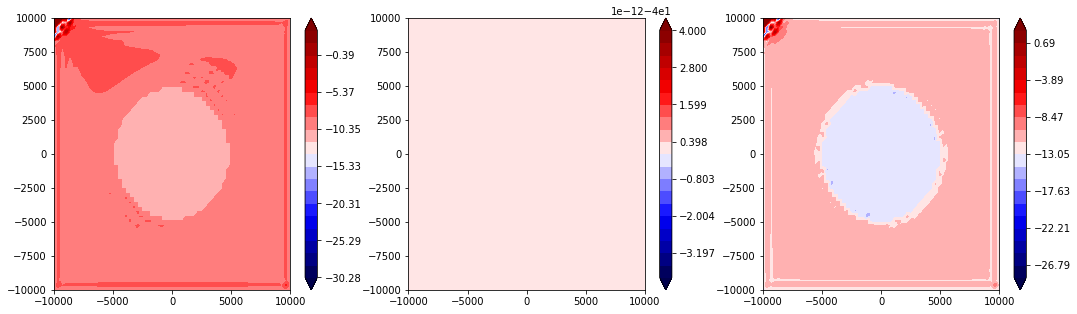

traction


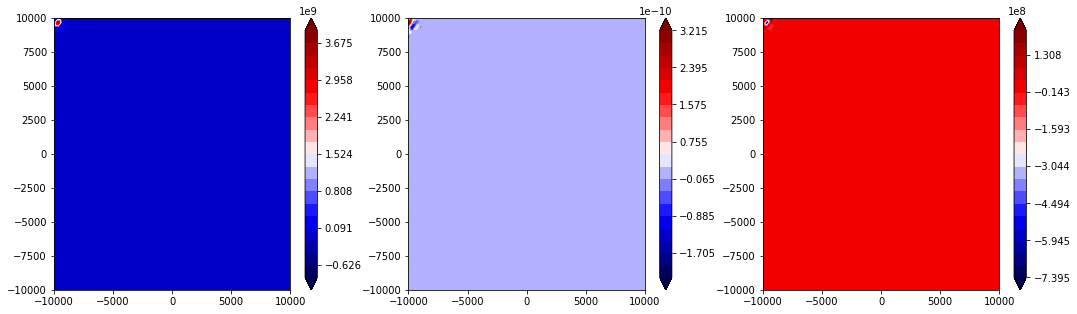

state


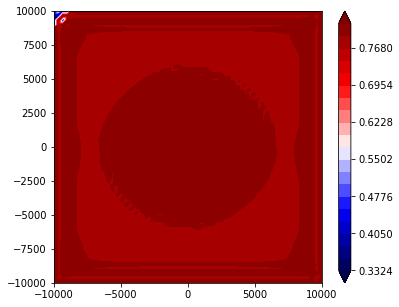

581 35.3058604537
582 35.3058604537
583 35.3058604537
584 35.3058604537
585 35.3058604537
586 35.3058604537
587 35.3058604537
588 35.3058604537
589 35.3058604537
590 35.3058604537
V


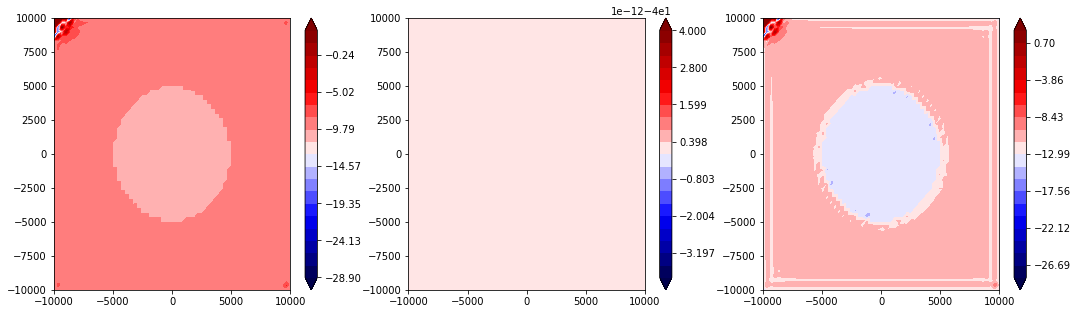

traction


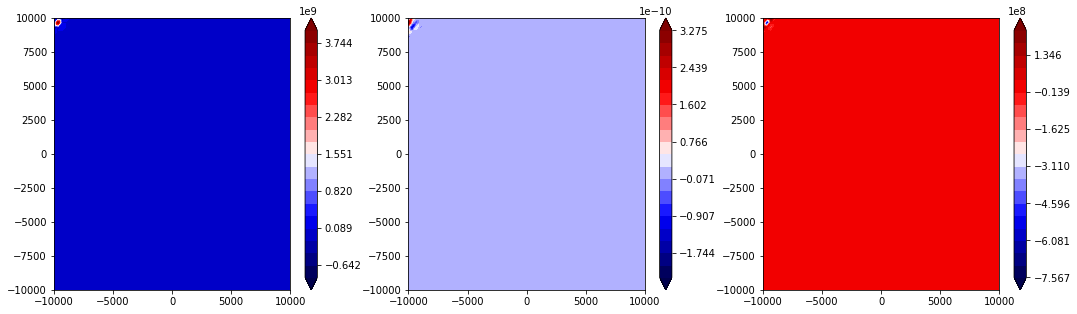

state


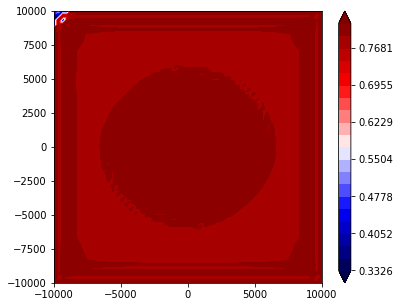

591 35.3058604537
592 35.3058604537
593 35.3058604537
594 35.3058604537
595 35.3058604537
596 35.3058604537
597 35.3058604537
598 35.3058604537
599 35.3058604537
600 35.3058604537
V


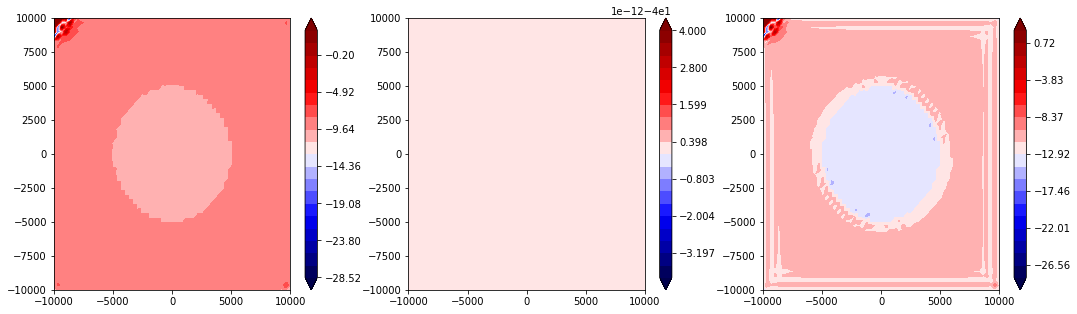

traction


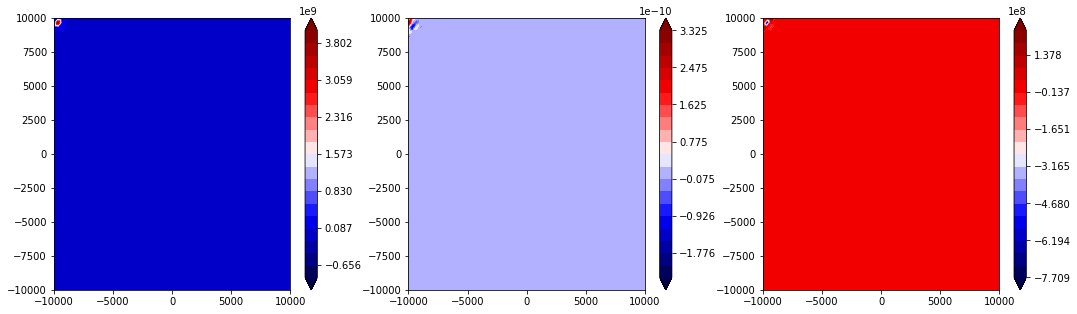

state


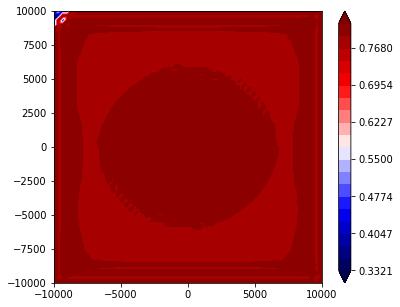

601 35.3058604537
602 35.3058604537
603 35.3058604537
604 35.3058604537
605 35.3058604537
606 35.3058604537
607 35.3058604537
608 35.3058604537
609 35.3058604537
610 35.3058604537
V


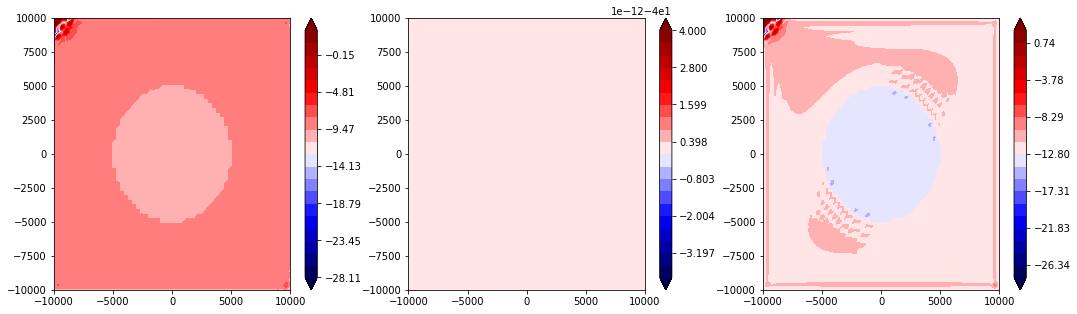

traction


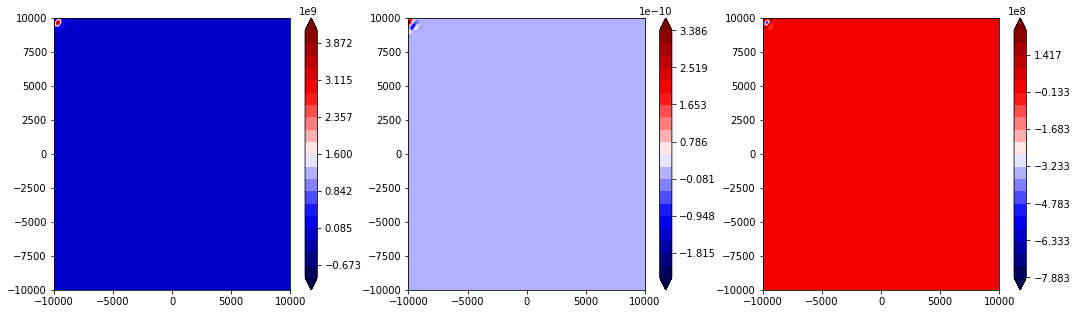

state


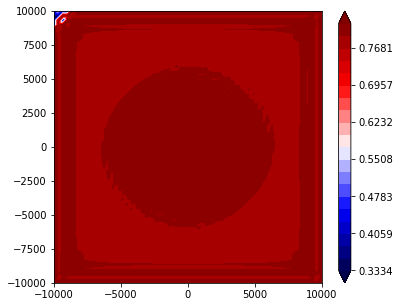

611 35.3058604537
612 35.3058604537
613 35.3058604537
614 35.3058604537
615 35.3058604537
616 35.3058604537
617 35.3058604537
618 35.3058604537
619 35.3058604537
620 35.3058604537
V


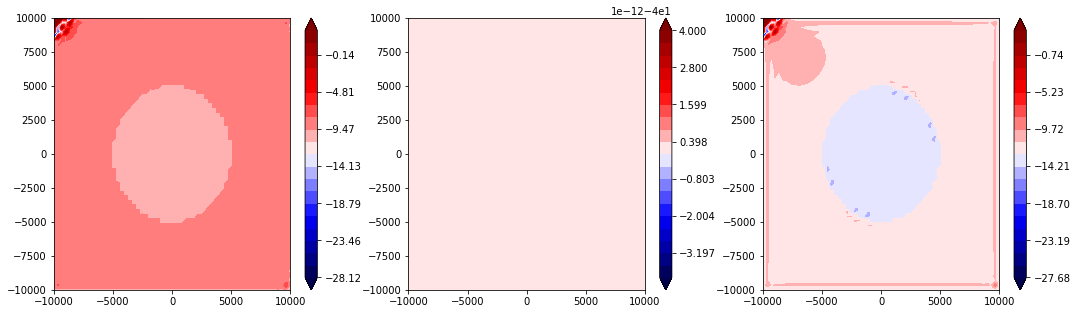

traction


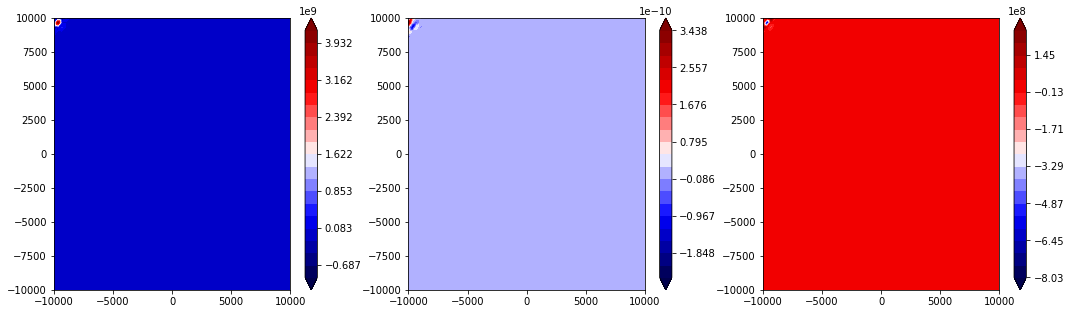

state


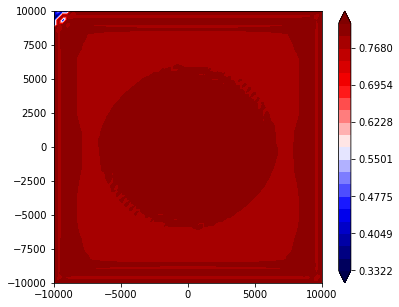

621 35.3058604537
622 35.3058604537
623 35.3058604537
624 35.3058604537
625 35.3058604537
626 35.3058604537
627 35.3058604537
628 35.3058604537
629 35.3058604537
630 35.3058604537
V


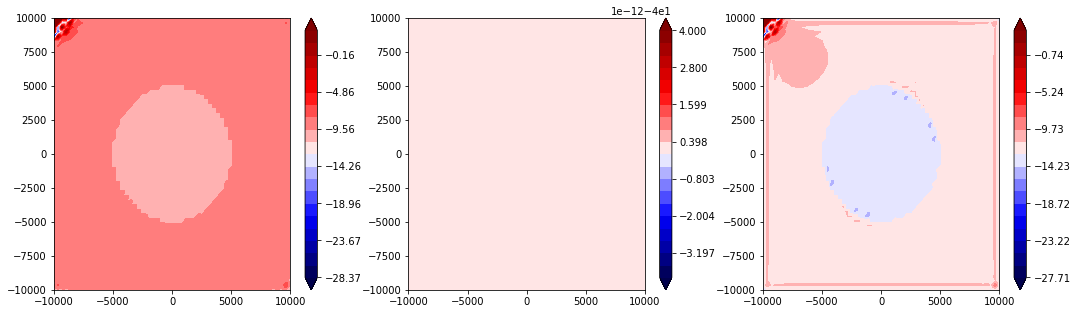

traction


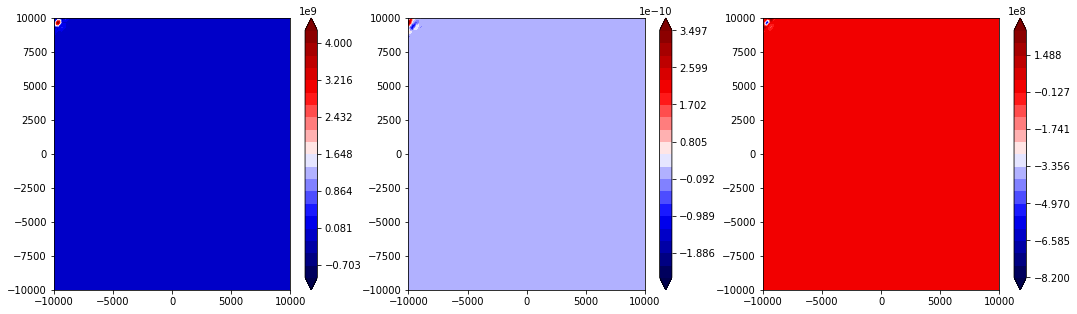

state


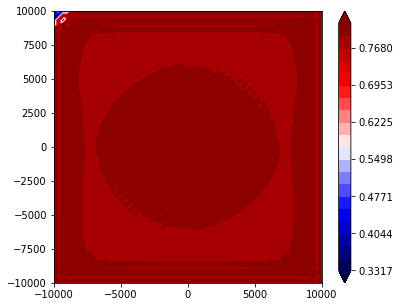

631 35.3058604537
632 35.3058604537
633 35.3058604537
634 35.3058604537
635 35.3058604537
636 35.3058604537
637 35.3058604537
638 35.3058604537
639 35.3058604537
640 35.3058604537
V


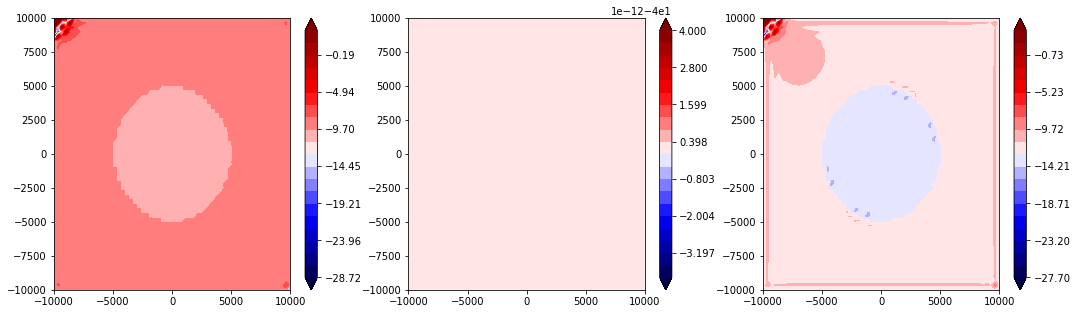

traction


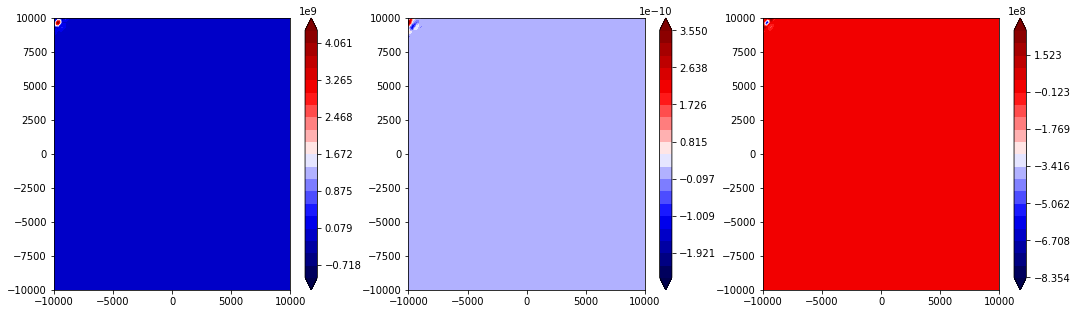

state


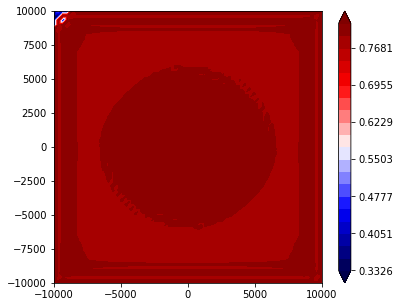

641 35.3058604537
642 35.3058604537
643 35.3058604537
644 35.3058604537
645 35.3058604537
646 35.3058604537
647 35.3058604537
648 35.3058604537
649 35.3058604537
650 35.3058604537
V


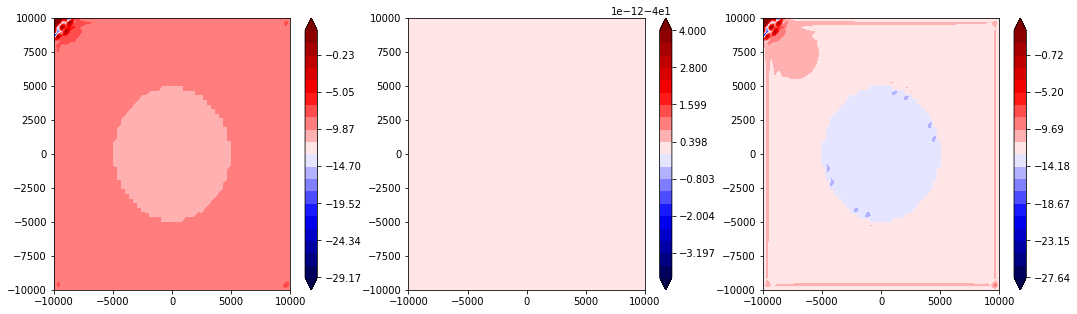

traction


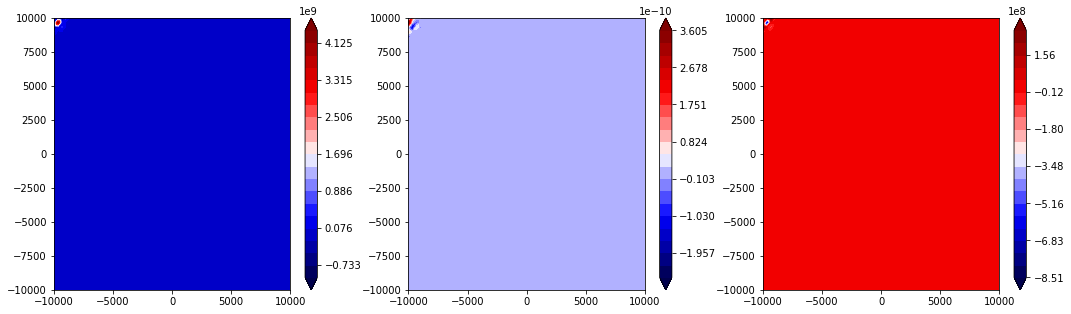

state


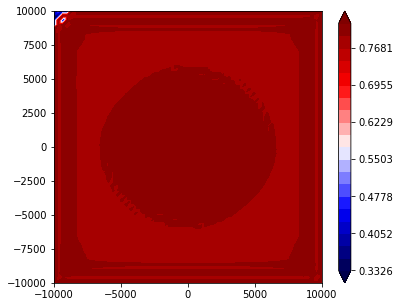

651 35.3058604537
652 35.3058604537
653 35.3058604537
654 35.3058604537
655 35.3058604537
656 35.3058604537
657 35.3058604537
658 35.3058604537
659 35.3058604537
660 35.3058604537
V


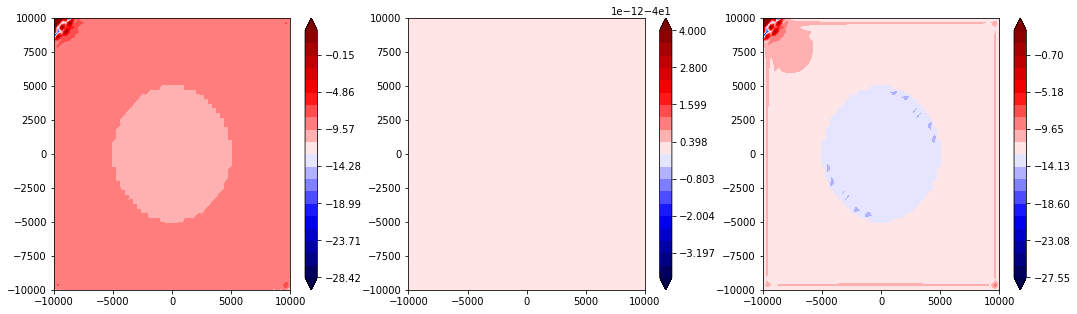

traction


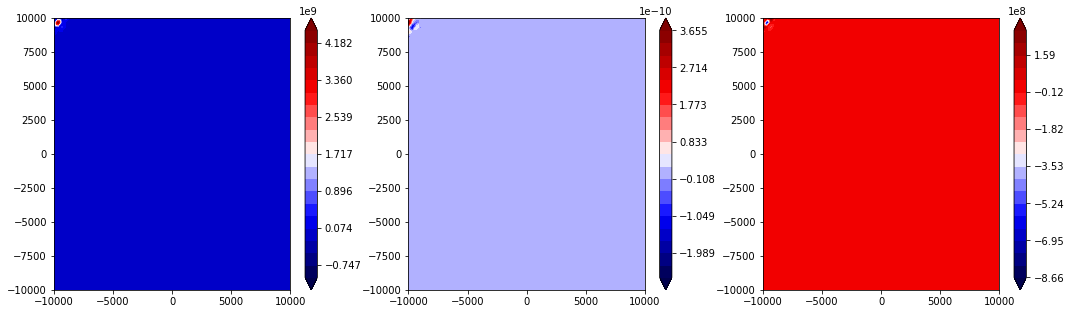

state


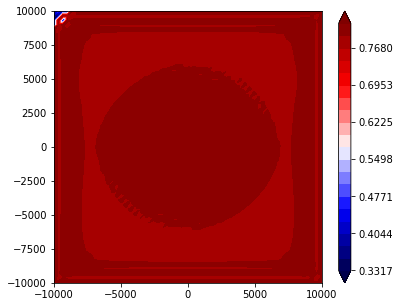

661 35.3058604537
662 35.3058604537
663 35.3058604537
664 35.3058604537
665 35.3058604537
666 35.3058604537
667 35.3058604537
668 35.3058604537
669 35.3058604537
670 35.3058604537
V


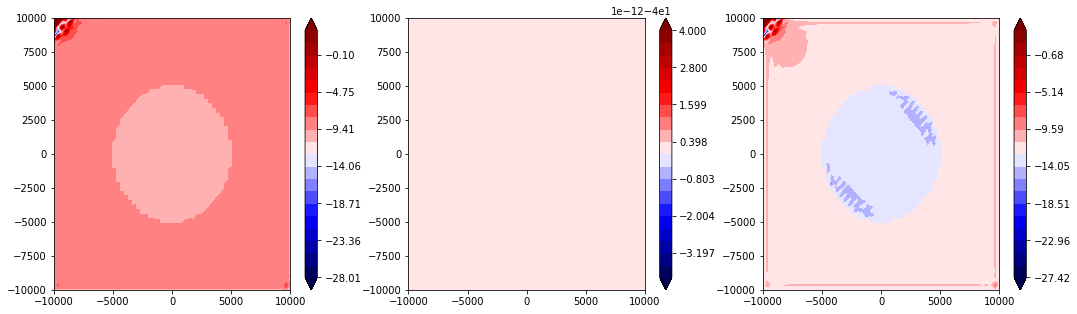

traction


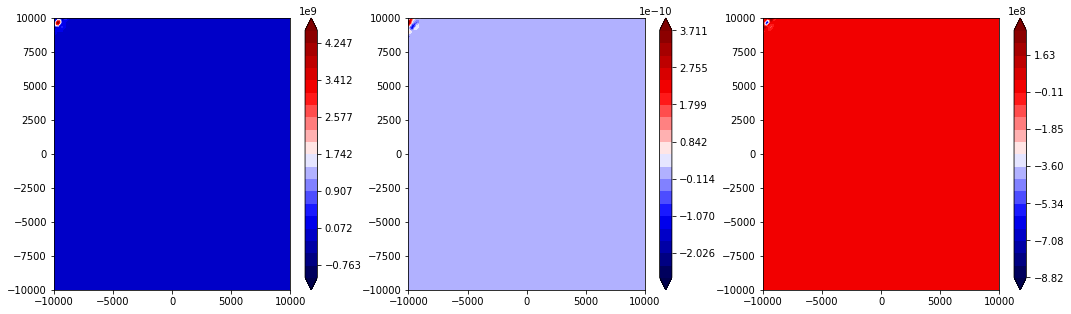

state


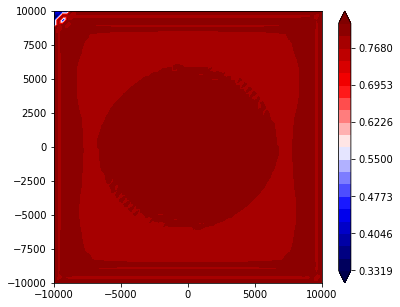

671 35.3058604537
672 35.3058604537
673 35.3058604537
674 35.3058604537
675 35.3058604537
676 35.3058604537
677 35.3058604537
678 35.3058604537
679 35.3058604537
680 35.3058604537
V


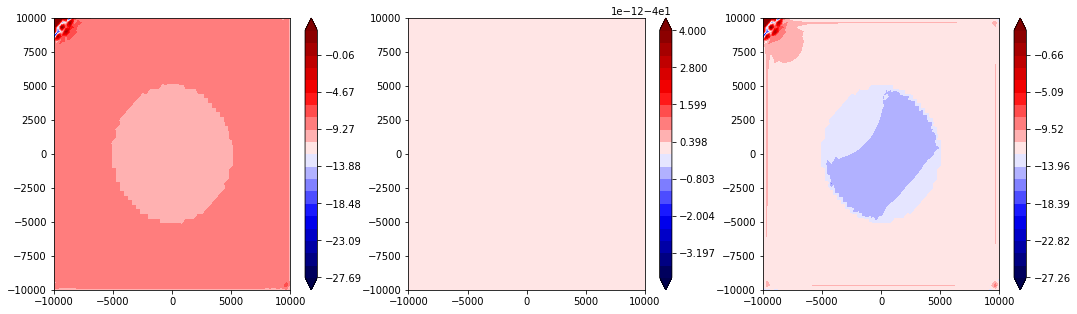

traction


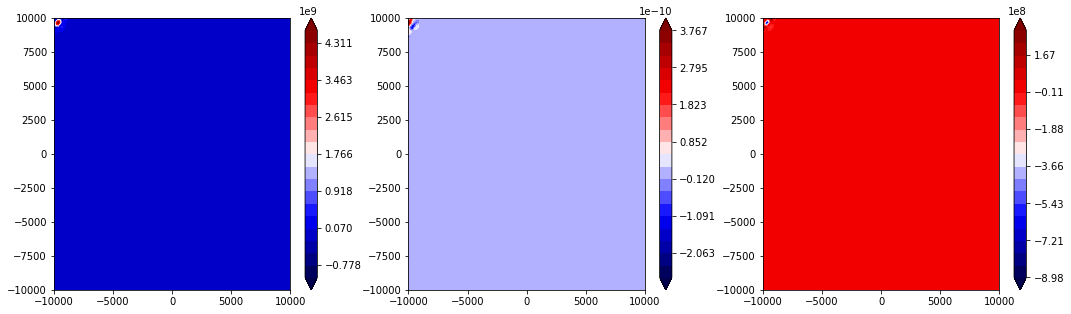

state


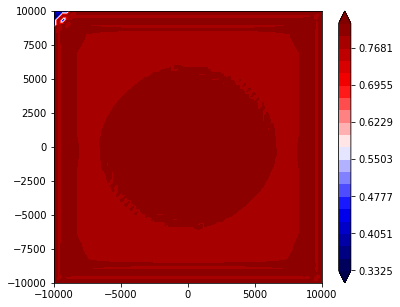

681 35.3058604537
682 35.3058604537
683 35.3058604537
684 35.3058604537
685 35.3058604537
686 35.3058604537
687 35.3058604537
688 35.3058604537
689 35.3058604537
690 35.3058604537
V


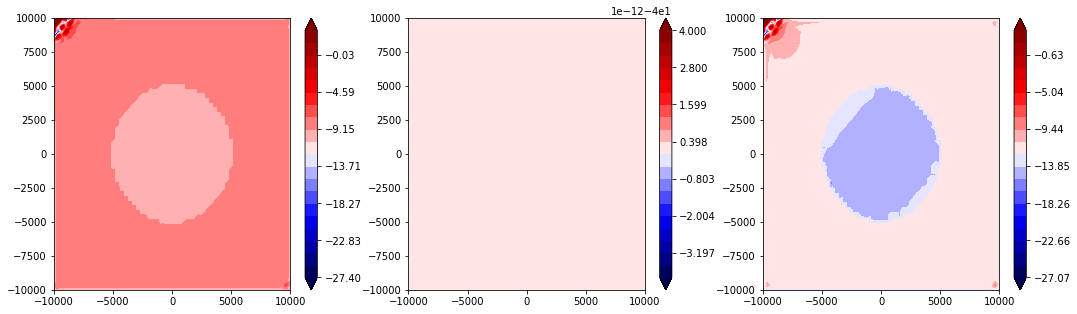

traction


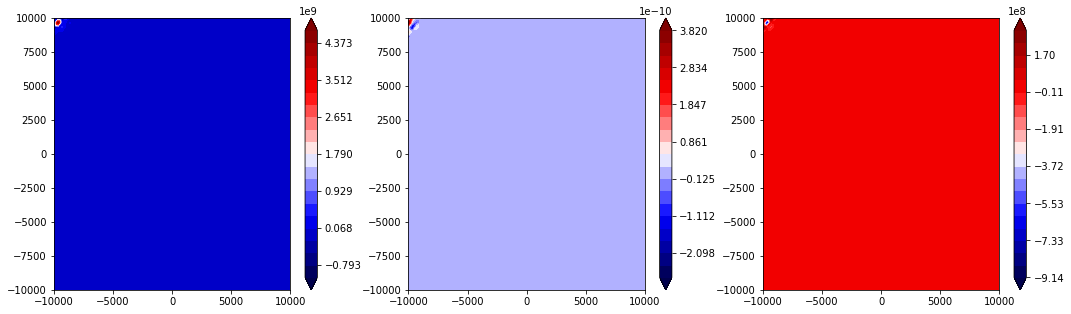

state


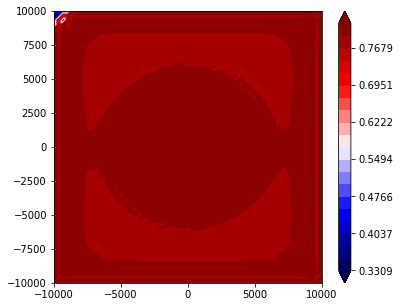

691 35.3058604537
692 35.3058604537
693 35.3058604537
694 35.3058604537
695 35.3058604537
696 35.3058604537
697 35.3058604537
698 35.3058604537
699 35.3058604537
700 35.3058604537
V


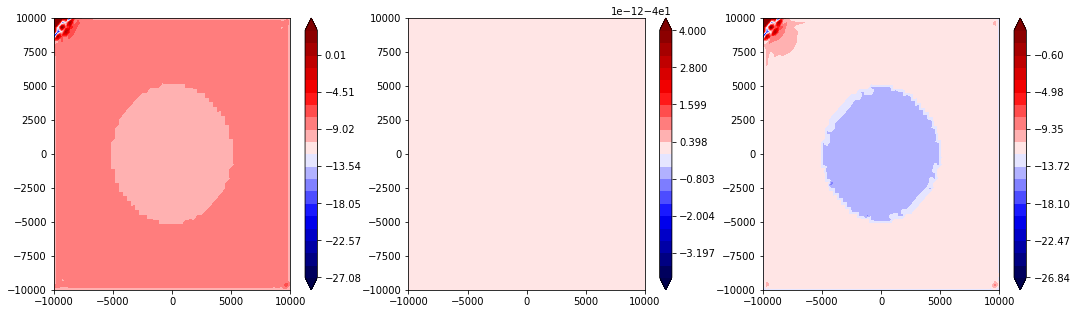

traction


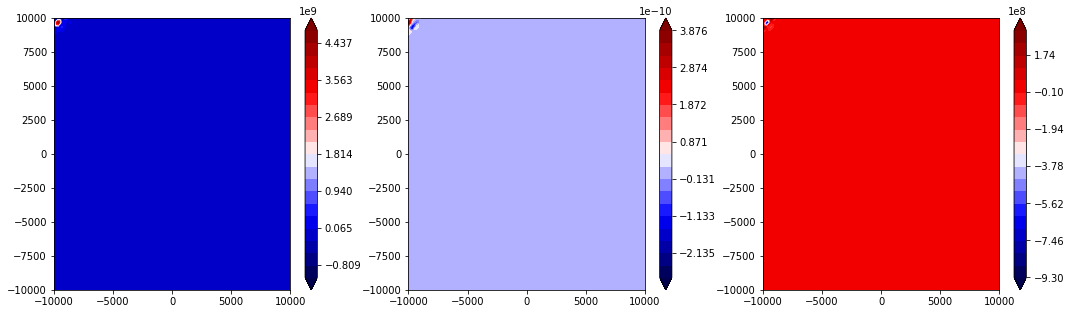

state


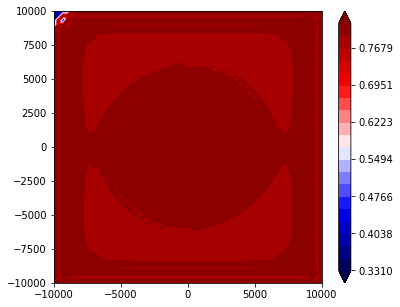

701 35.3058604537
702 35.3058604537
703 35.3058604537
704 35.3058604537
705 35.3058604537
706 35.3058604537
707 35.3058604537
708 35.3058604538
709 35.3058604538
710 35.3058604538
V


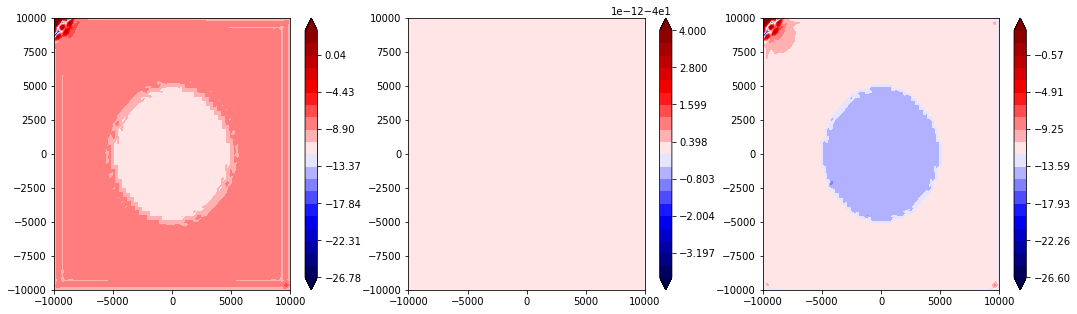

traction


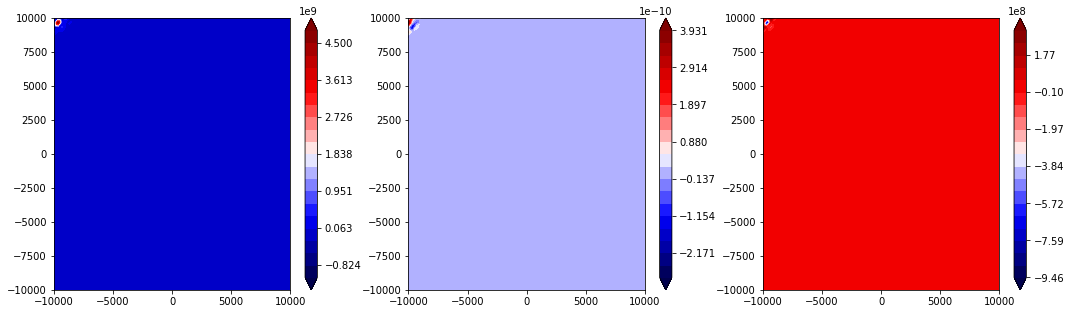

state


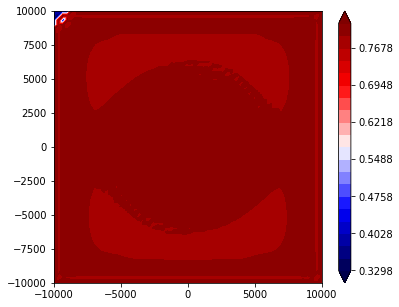

711 35.3058604538
712 35.3058604538
713 35.3058604538
714 35.3058604538
715 35.3058604538
716 35.3058604538
717 35.3058604538
718 35.3058604538
719 35.3058604538
720 35.3058604538
V


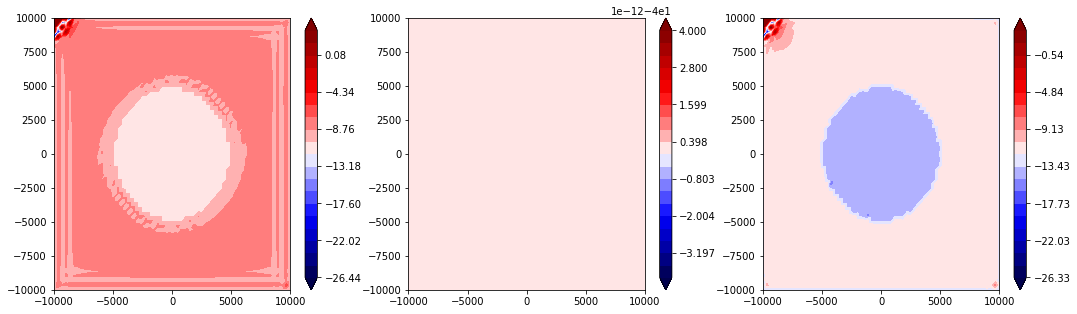

traction


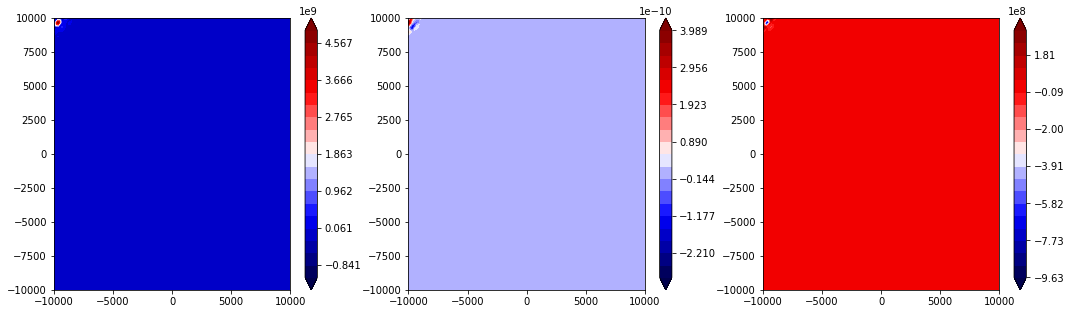

state


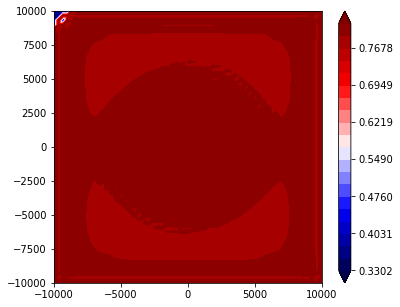

721 35.3058604538
722 35.3058604538
723 35.3058604538
724 35.3058604538
725 35.3058604538
726 35.3058604538
727 35.3058604538
728 35.3058604538
729 35.3058604538
730 35.3058604538
V


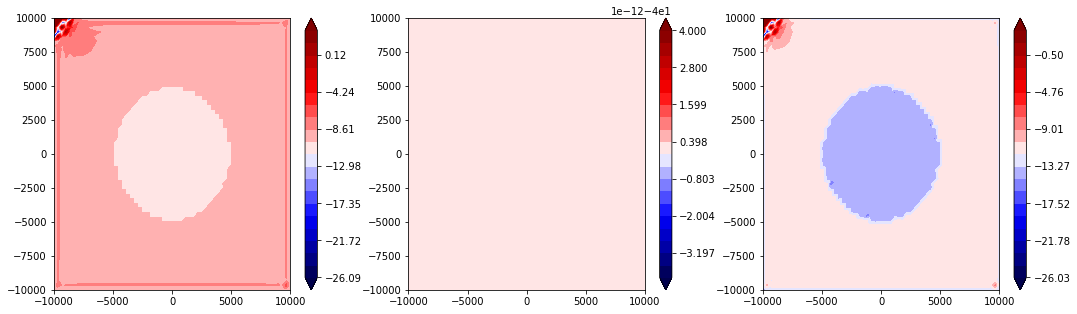

traction


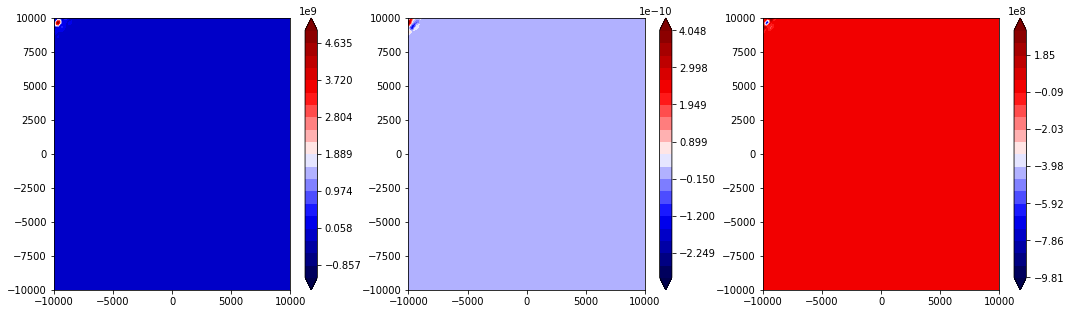

state


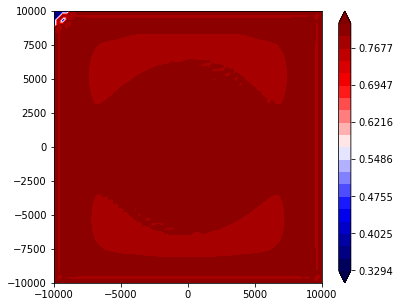

731 35.3058604538
732 35.3058604538
733 35.3058604538
734 35.3058604538
735 35.3058604538
736 35.3058604538
737 35.3058604538
738 35.3058604538
739 35.3058604538
740 35.3058604538
V


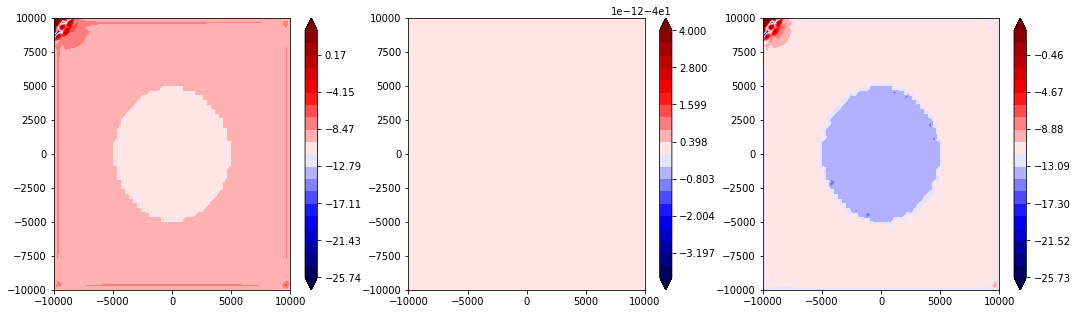

traction


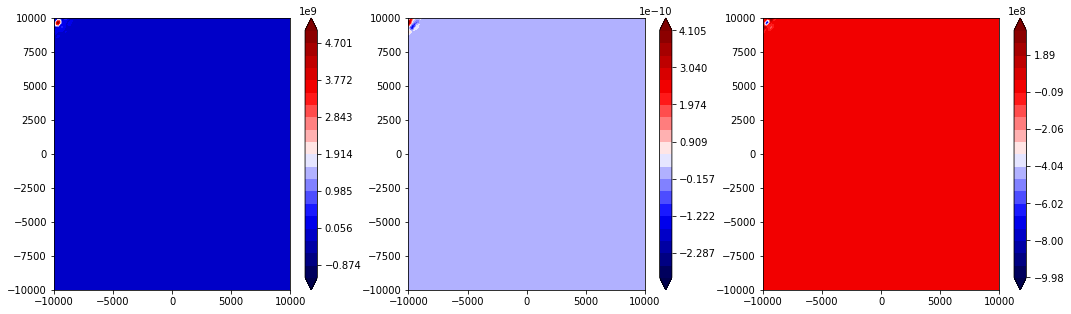

state


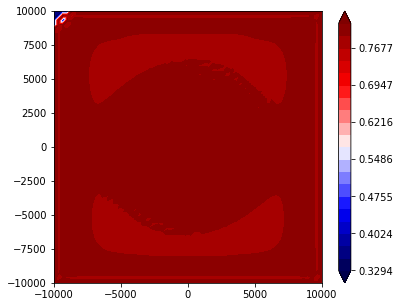

741 35.3058604538
742 35.3058604538
743 35.3058604538
744 35.3058604538
745 35.3058604538
746 35.3058604538
747 35.3058604538
748 35.3058604538
749 35.3058604538
750 35.3058604538
V


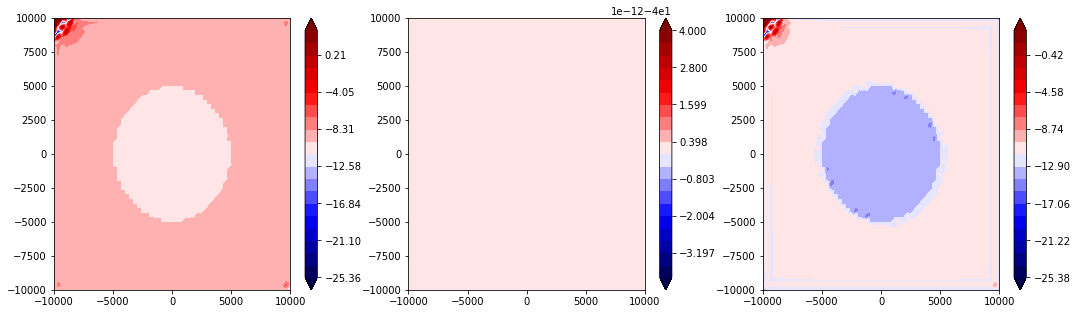

traction


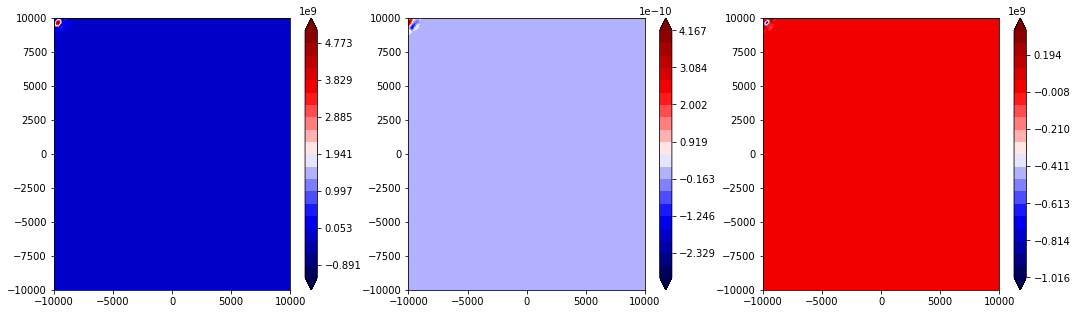

state


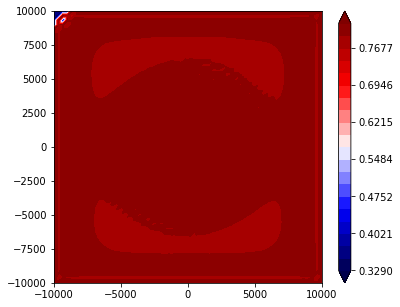

751 35.3058604538
752 35.3058604538
753 35.3058604538
754 35.3058604538
755 35.3058604538
756 35.3058604538
757 35.3058604538
758 35.3058604538
759 35.3058604538
760 35.3058604538
V


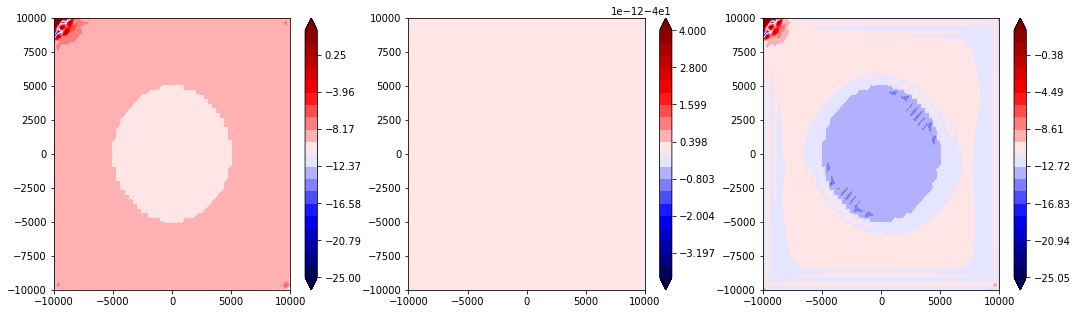

traction


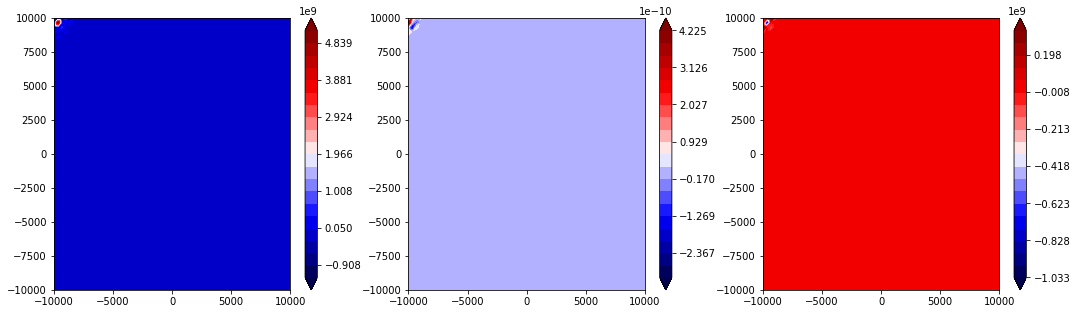

state


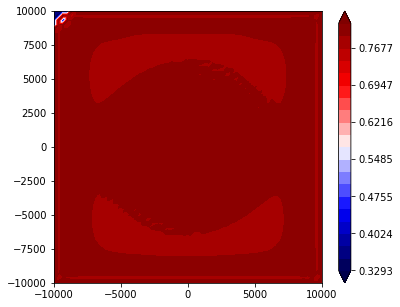

761 35.3058604538
762 35.3058604538
763 35.3058604538
764 35.3058604538
765 35.3058604538
766 35.3058604538
767 35.3058604538
768 35.3058604538
769 35.3058604538
770 35.3058604538
V


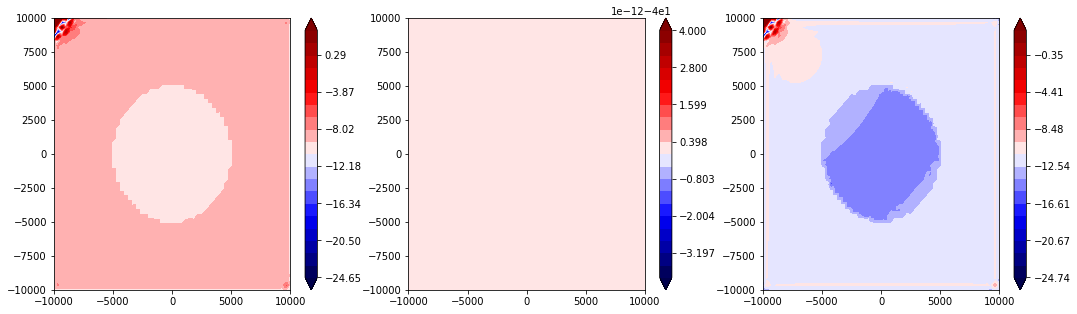

traction


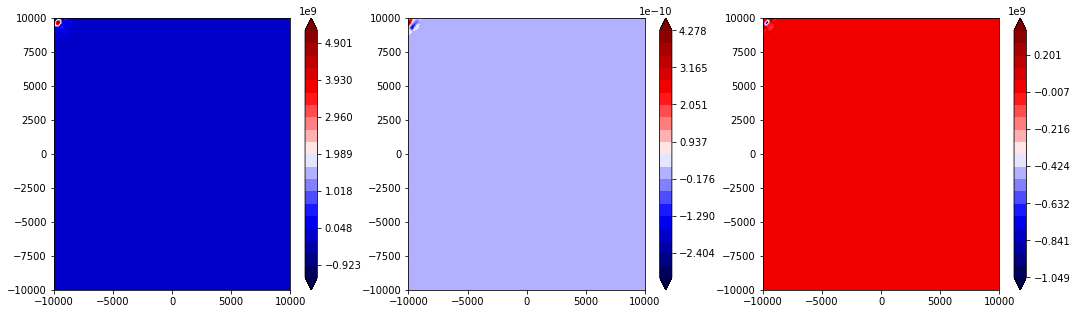

state


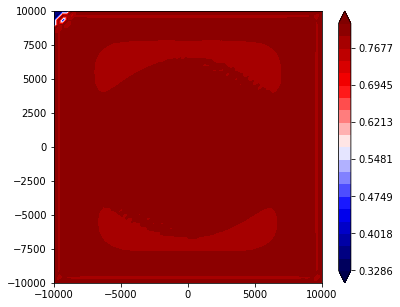

771 35.3058604538
772 35.3058604538
773 35.3058604538
774 35.3058604538
775 35.3058604538
776 35.3058604538
777 35.3058604538
778 35.3058604538
779 35.3058604538
780 35.3058604538
V


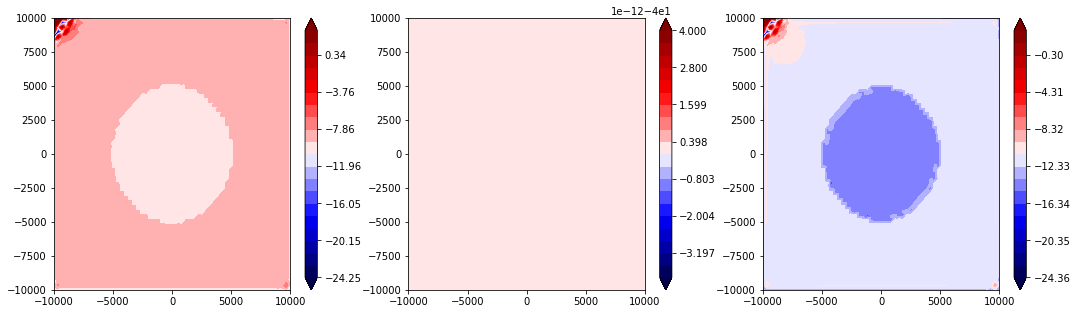

traction


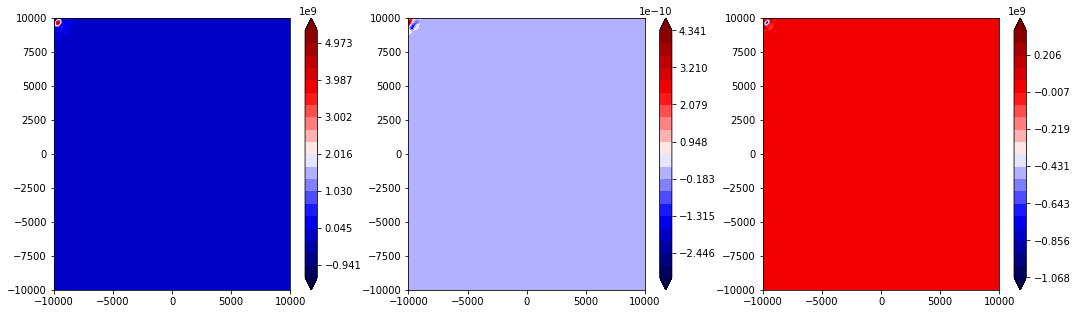

state


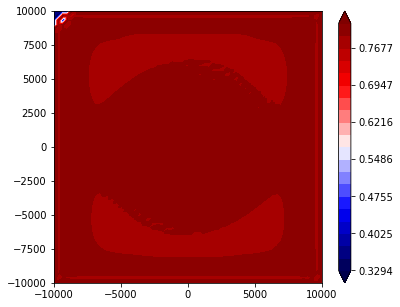

781 35.3058604538
782 35.3058604538
783 35.3058604538
784 35.3058604538
785 35.3058604538
786 35.3058604538
787 35.3058604538
788 35.3058604538
789 35.3058604538
790 35.3058604538
V


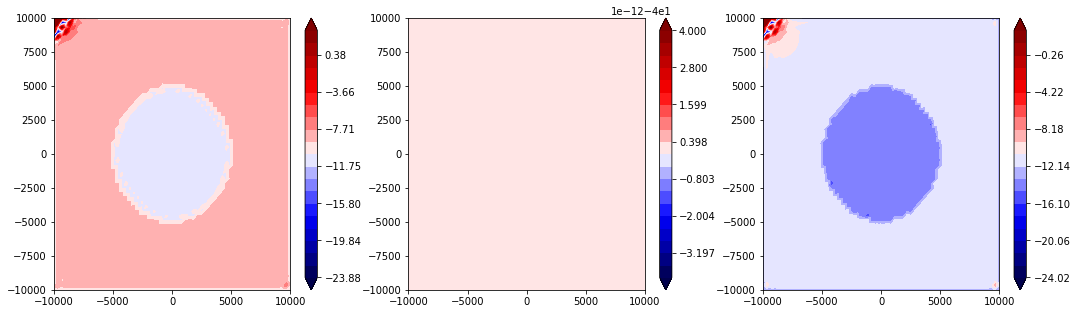

traction


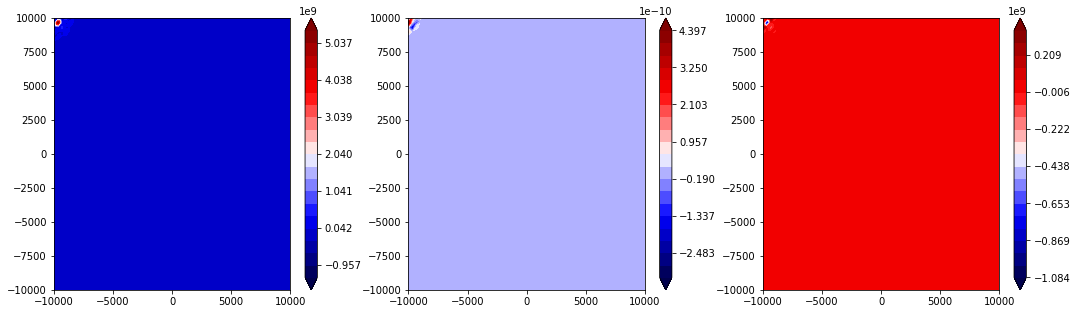

state


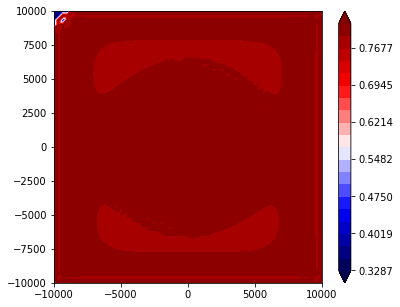

791 35.3058604538
792 35.3058604538
793 35.3058604538
794 35.3058604538
795 35.3058604538
796 35.3058604538
797 35.3058604538
798 35.3058604538
799 35.3058604538
800 35.3058604538
V


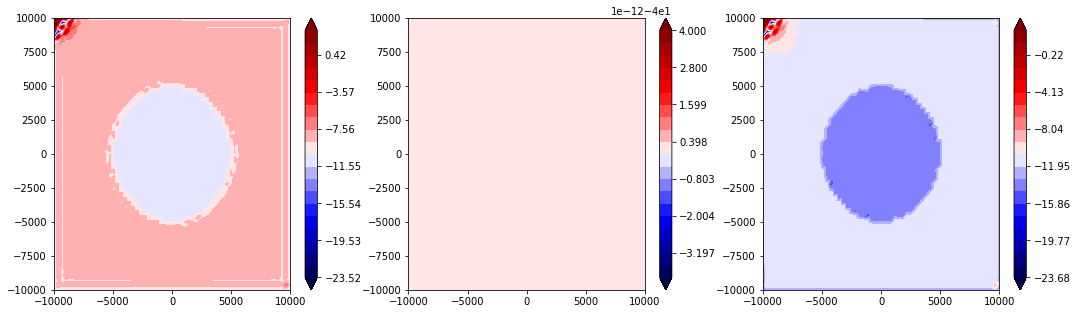

traction


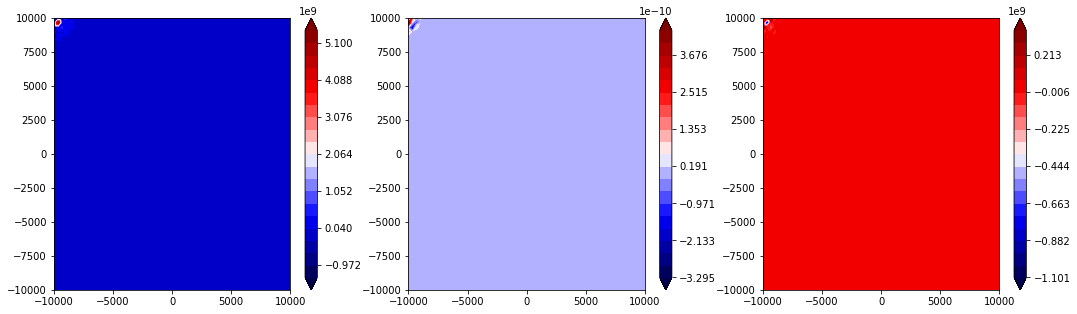

state


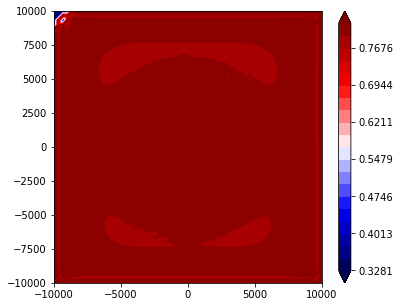

801 35.3058604538
802 35.3058604538
803 35.3058604538
804 35.3058604538
805 35.3058604538
806 35.3058604538
807 35.3058604538
808 35.3058604538
809 35.3058604538
810 35.3058604538
V


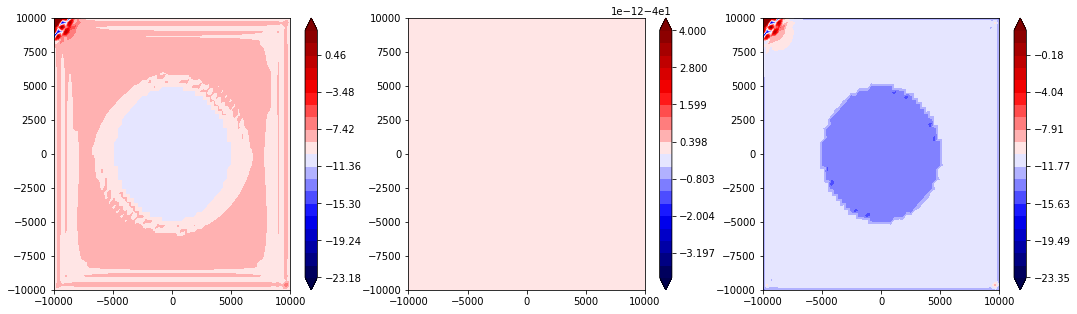

traction


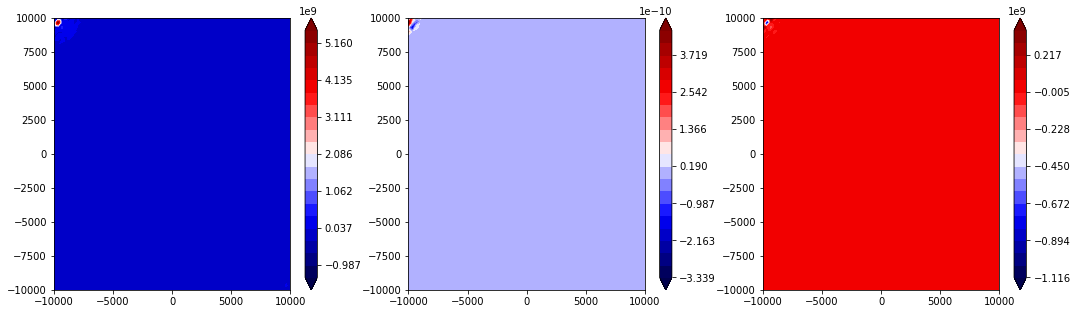

state


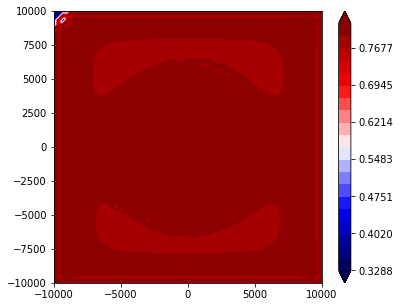

811 35.3058604538
812 35.3058604538
813 35.3058604538
814 35.3058604538
815 35.3058604538
816 35.3058604538
817 35.3058604538
818 35.3058604538
819 35.3058604538
820 35.3058604538
V


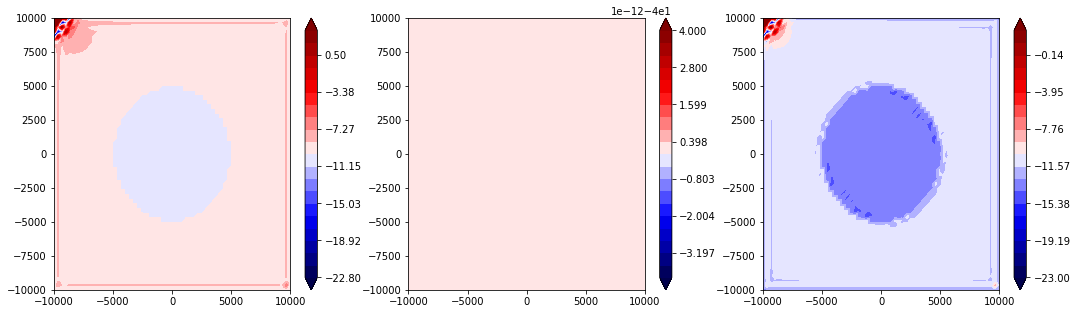

traction


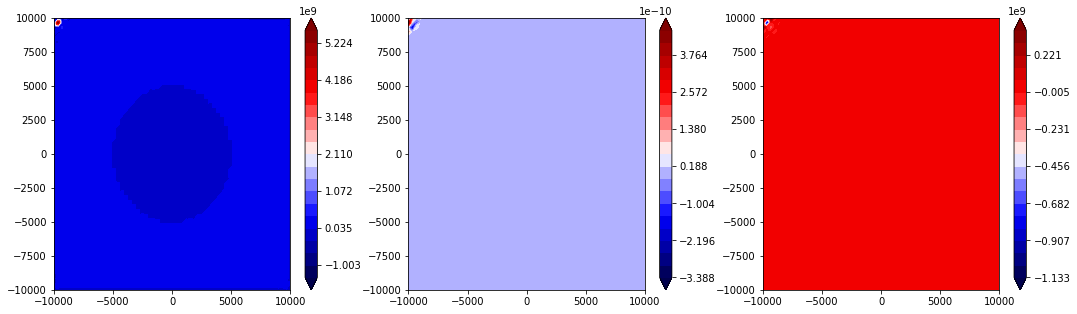

state


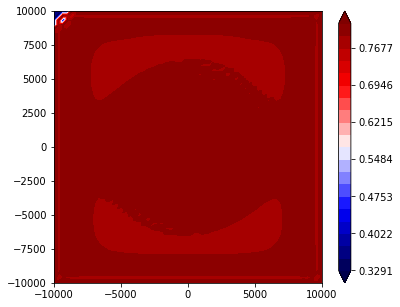

821 35.3058604538
822 35.3058604538
823 35.3058604538
824 35.3058604538
825 35.3058604538
826 35.3058604538
827 35.3058604538
828 35.3058604538
829 35.3058604538
830 35.3058604538
V


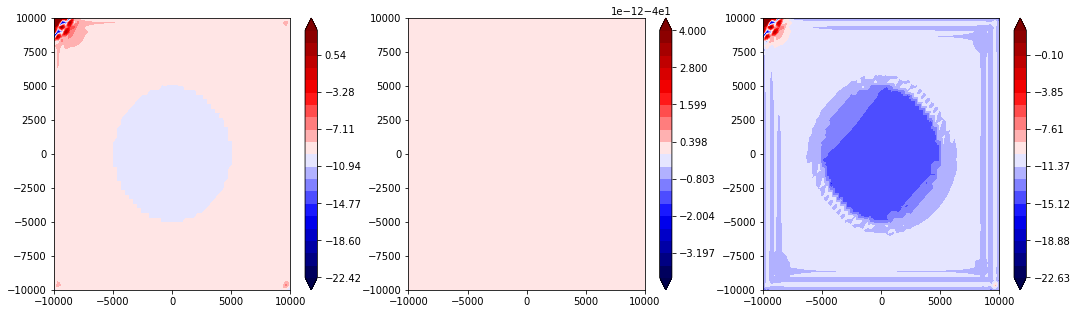

traction


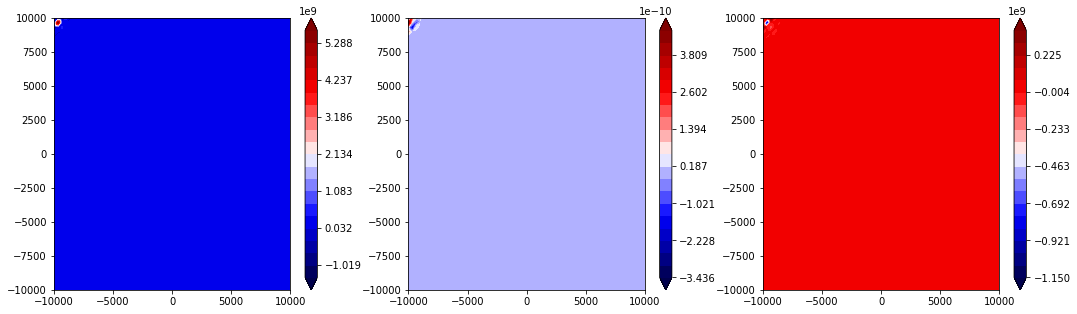

state


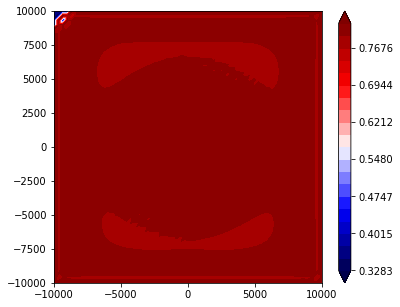

831 35.3058604538
832 35.3058604538
833 35.3058604538
834 35.3058604538
835 35.3058604538
836 35.3058604538
837 35.3058604538
838 35.3058604538
839 35.3058604538
840 35.3058604538
V


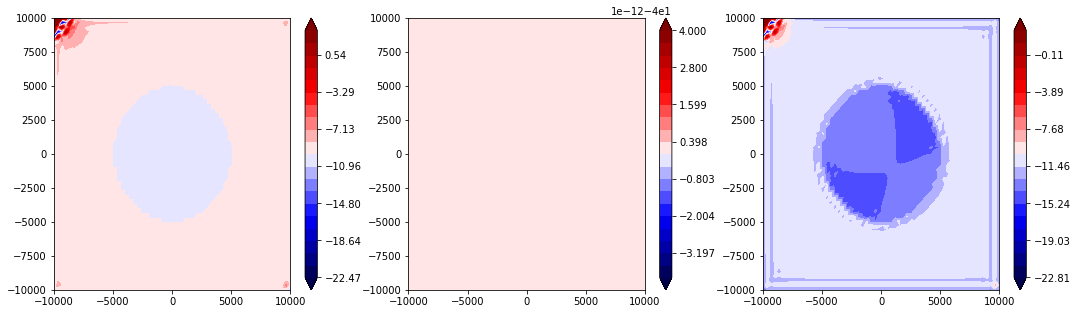

traction


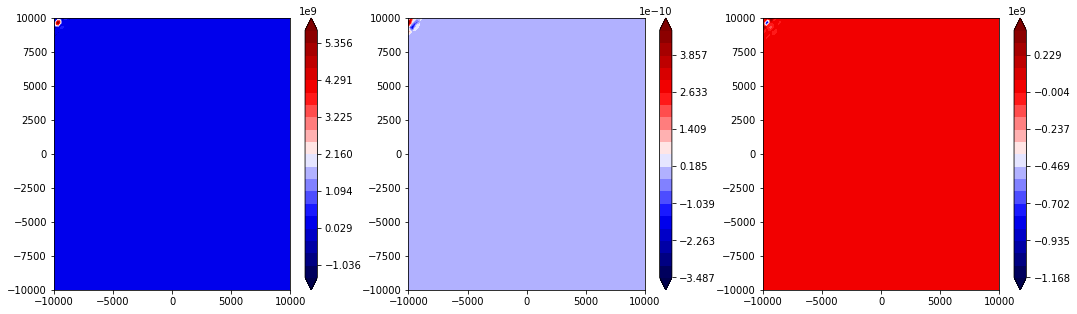

state


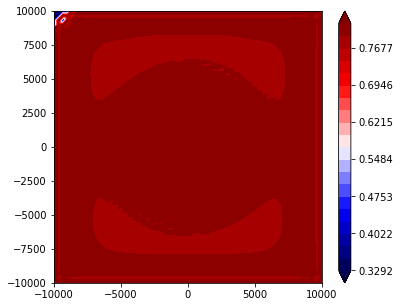

841 35.3058604538
842 35.3058604538
843 35.3058604538
844 35.3058604538
845 35.3058604538
846 35.3058604538
847 35.3058604538
848 35.3058604538
849 35.3058604538
850 35.3058604538
V


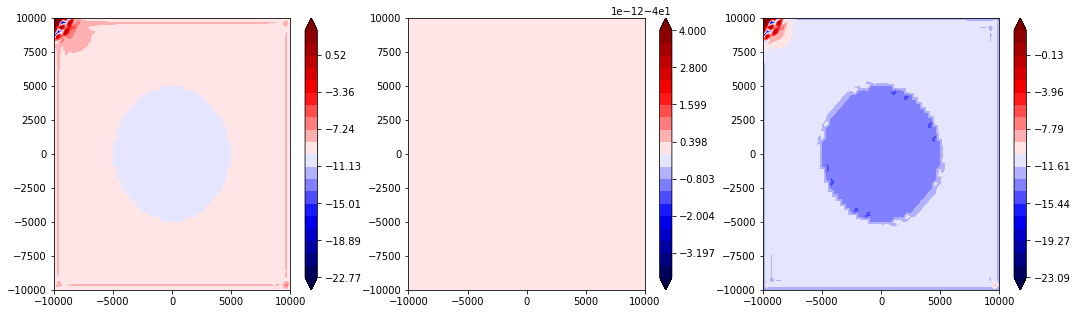

traction


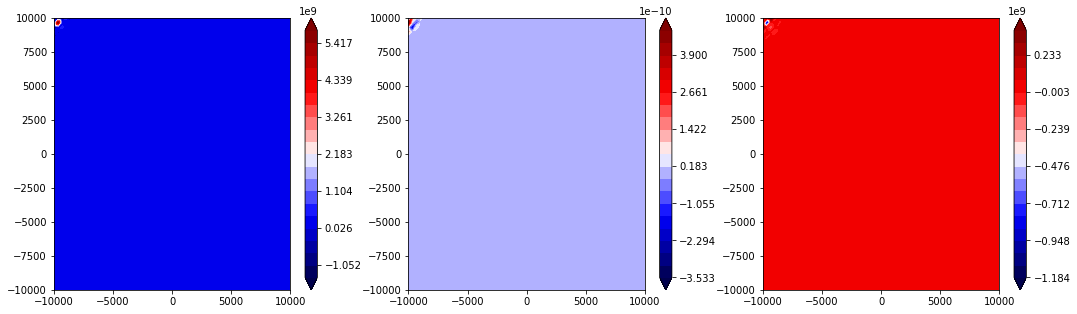

state


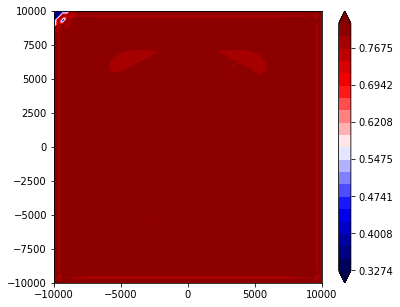

851 35.3058604538
852 35.3058604538
853 35.3058604538
854 35.3058604538
855 35.3058604538
856 35.3058604538
857 35.3058604539
858 35.3058604539
859 35.3058604539
860 35.3058604539
V


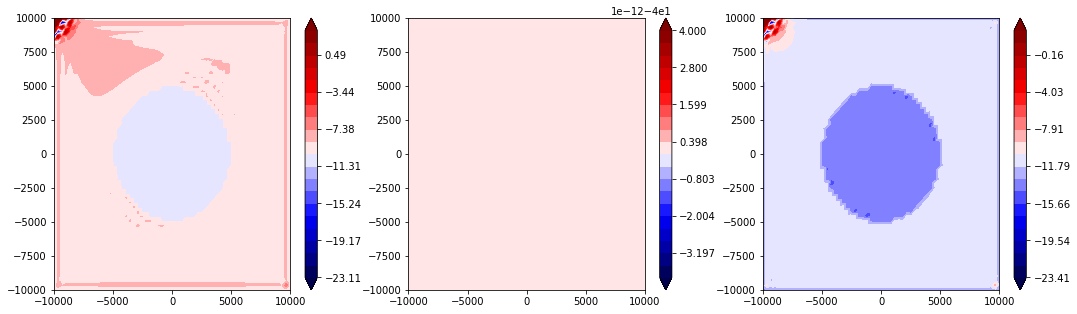

traction


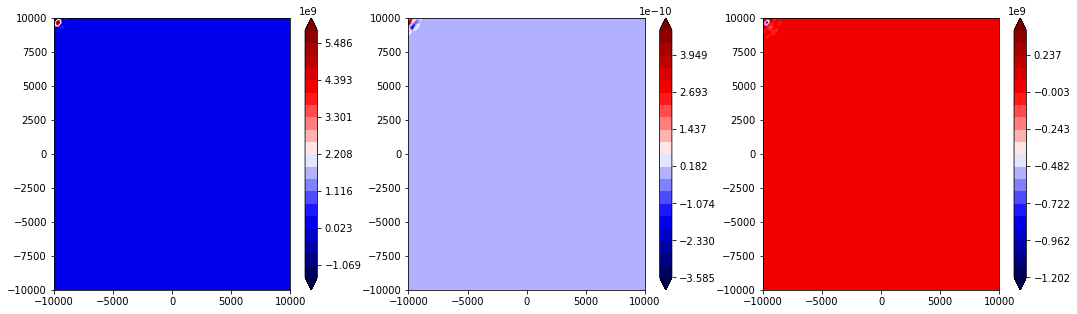

state


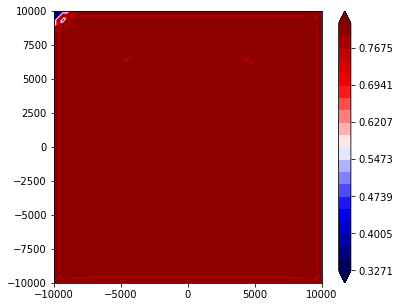

861 35.3058604539
862 35.3058604539
863 35.3058604539
864 35.3058604539
865 35.3058604539
866 35.3058604539
867 35.3058604539
868 35.3058604539
869 35.3058604539
870 35.3058604539
V


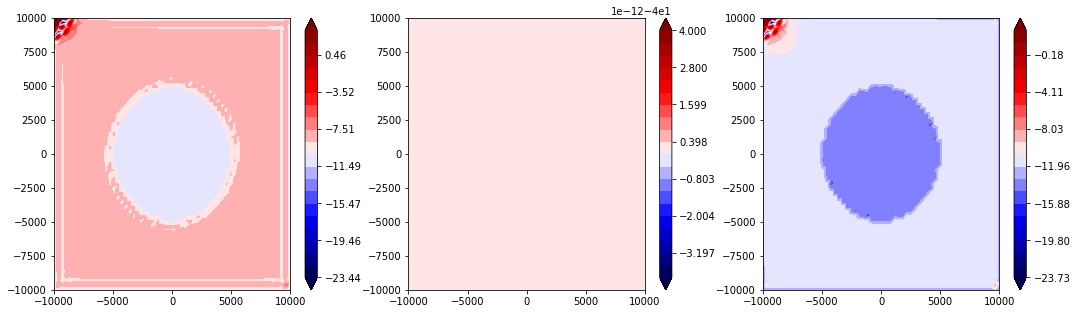

traction


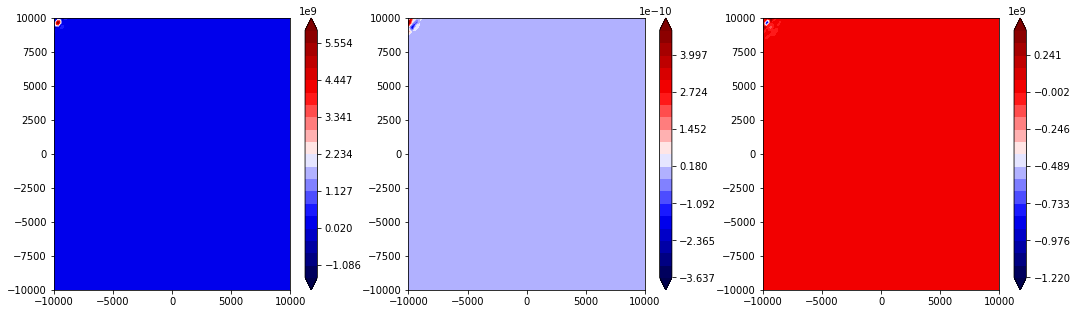

state


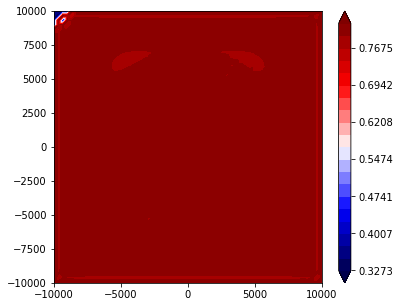

871 35.3058604539
872 35.3058604539
873 35.3058604539
874 35.3058604539
875 35.3058604539
876 35.3058604539
877 35.3058604539
878 35.3058604539
879 35.3058604539
880 35.3058604539
V


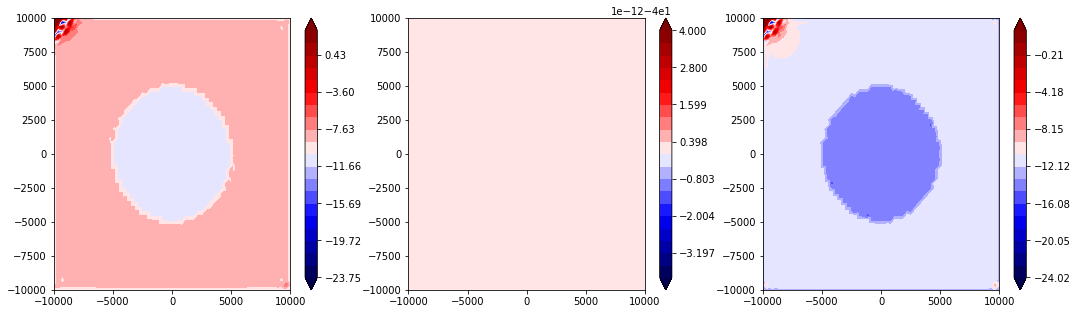

traction


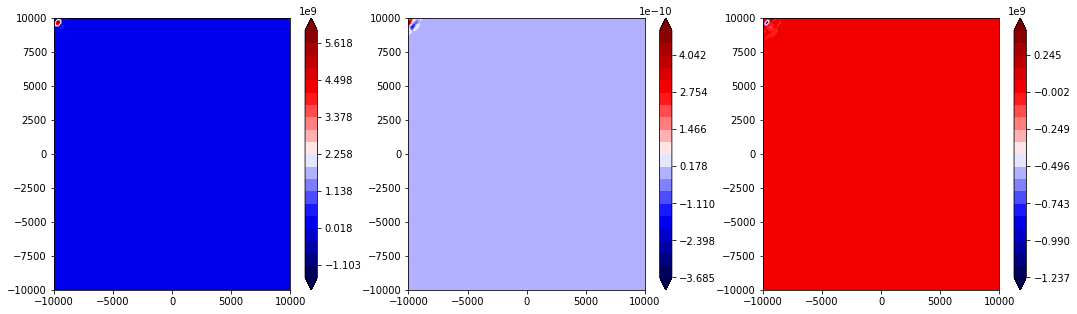

state


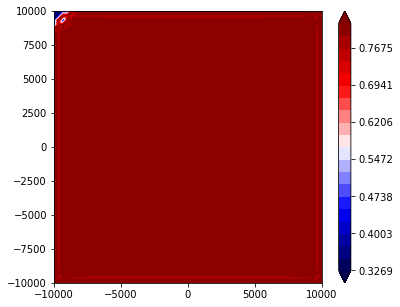

881 35.3058604539
882 35.3058604539
883 35.3058604539
884 35.3058604539
885 35.3058604539
886 35.3058604539
887 35.3058604539
888 35.3058604539
889 35.3058604539
890 35.3058604539
V


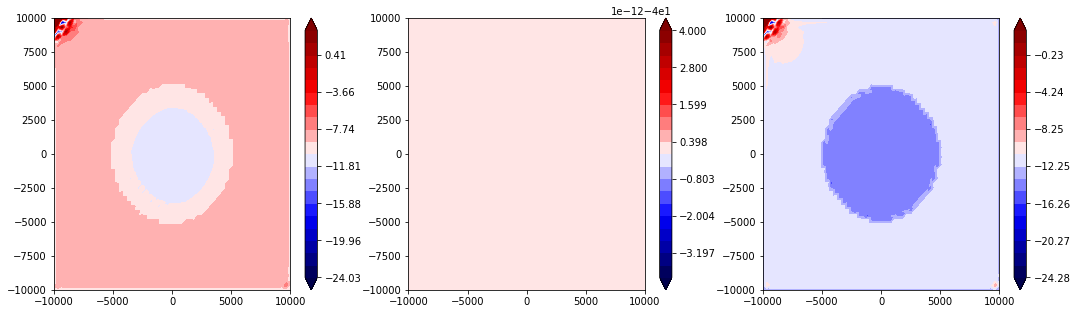

traction


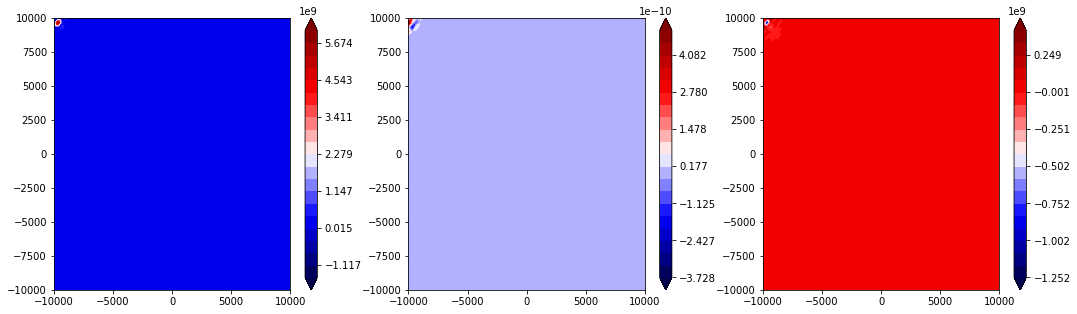

state


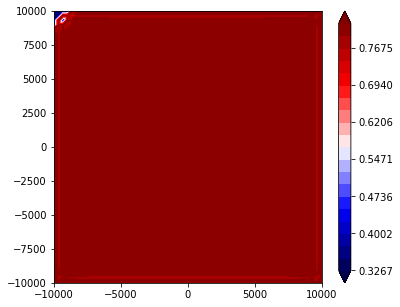

891 35.3058604539
892 35.3058604539
893 35.3058604539
894 35.3058604539
895 35.3058604539
896 35.3058604539
897 35.3058604539
898 35.3058604539
899 35.3058604539
900 35.3058604539
V


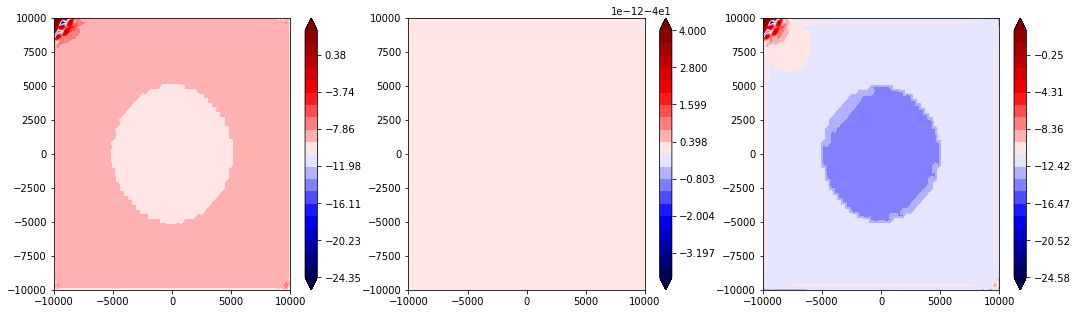

traction


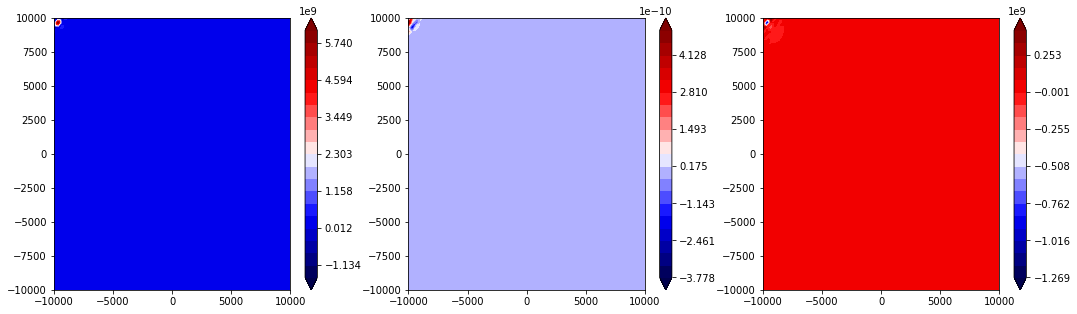

state


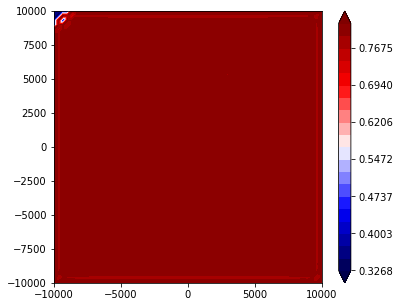

901 35.3058604539
902 35.3058604539
903 35.3058604539
904 35.3058604539
905 35.3058604539
906 35.3058604539
907 35.3058604539
908 35.3058604539
909 35.3058604539
910 35.3058604539
V


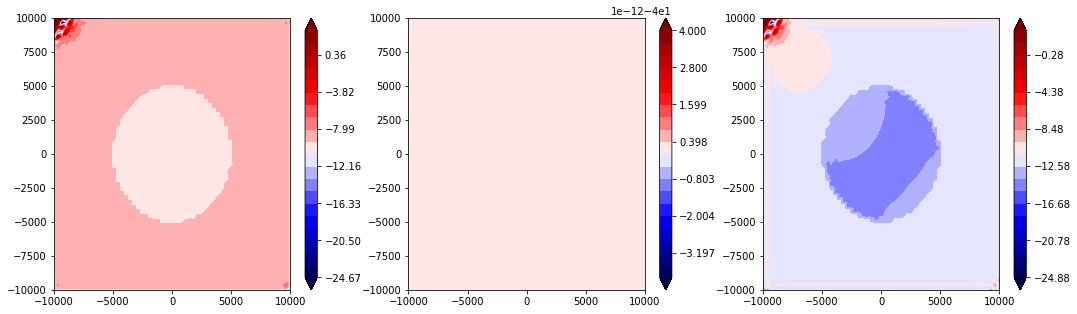

traction


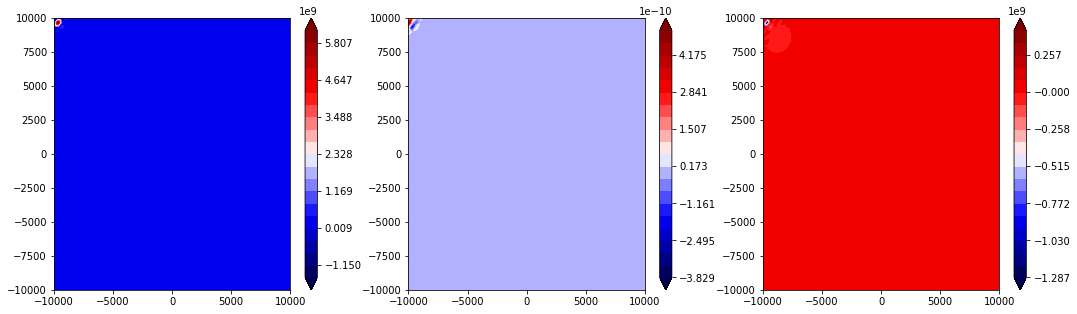

state


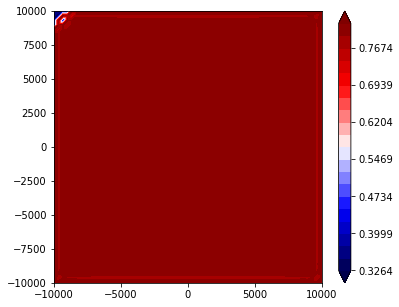

911 35.3058604539
912 35.3058604539
913 35.3058604539
914 35.3058604539
915 35.3058604539
916 35.3058604539
917 35.3058604539
918 35.3058604539
919 35.3058604539
920 35.3058604539
V


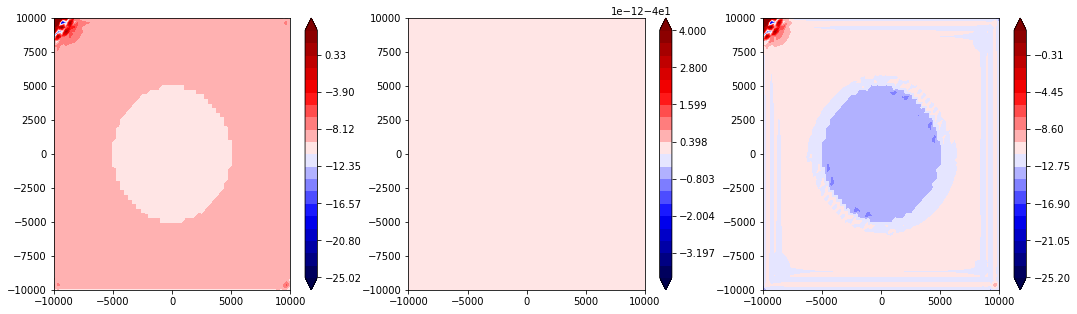

traction


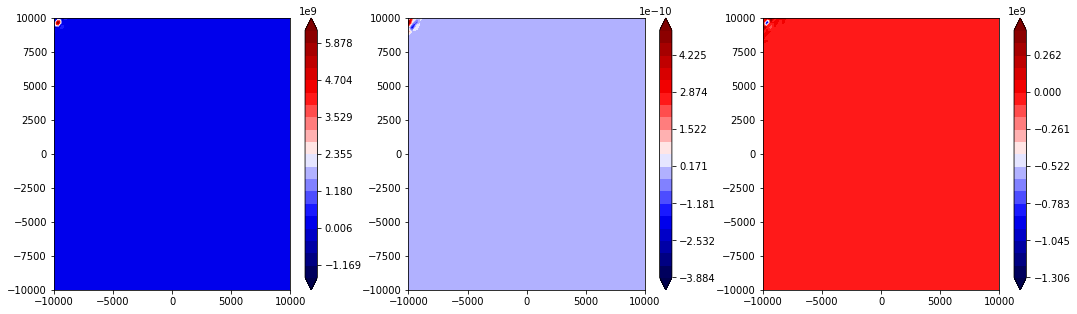

state


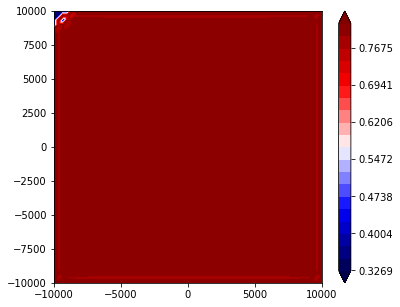

921 35.3058604539
922 35.3058604539
923 35.3058604539
924 35.3058604539
925 35.3058604539
926 35.3058604539
927 35.3058604539
928 35.3058604539
929 35.3058604539
930 35.3058604539
V


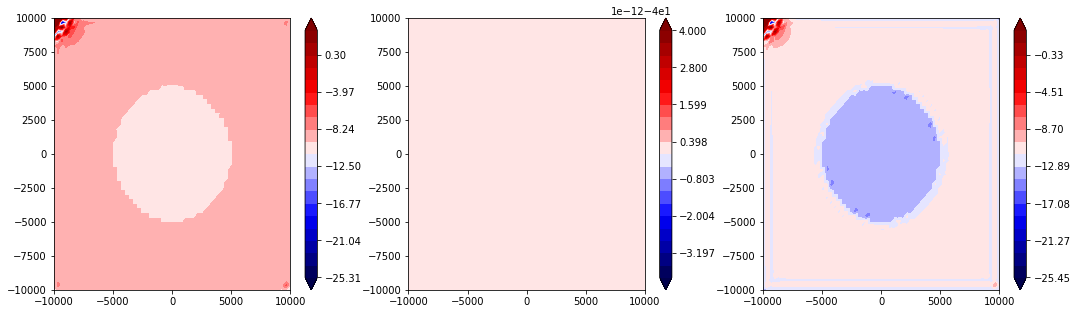

traction


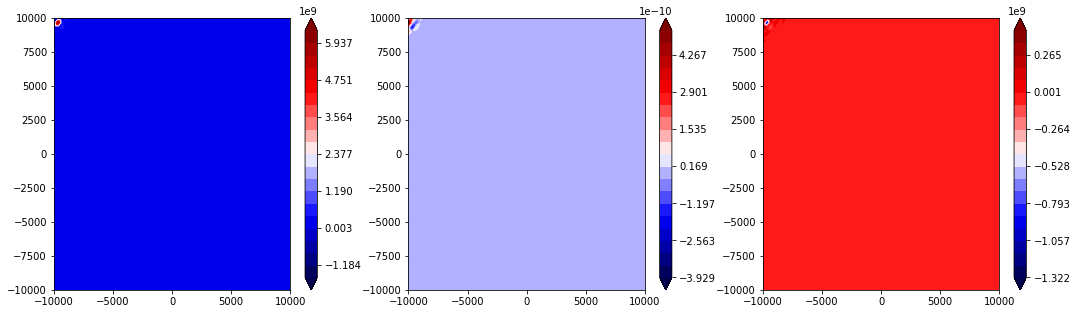

state


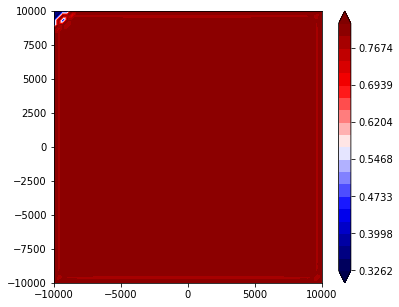

931 35.3058604539
932 35.3058604539
933 35.3058604539
934 35.3058604539
935 35.3058604539
936 35.3058604539
937 35.3058604539
938 35.3058604539
939 35.3058604539
940 35.3058604539
V


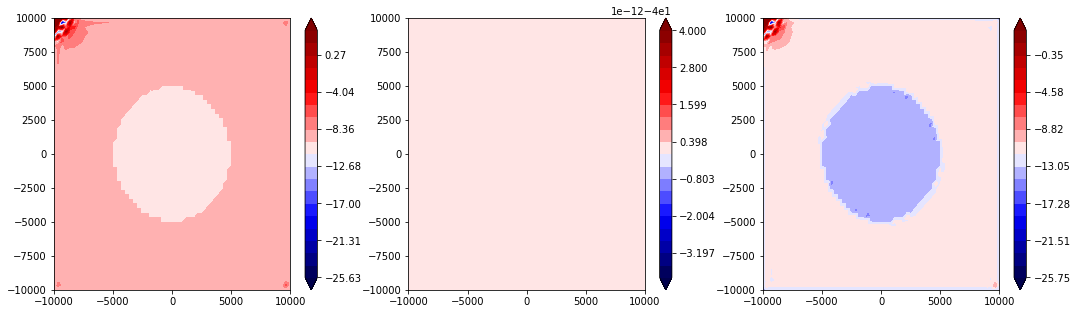

traction


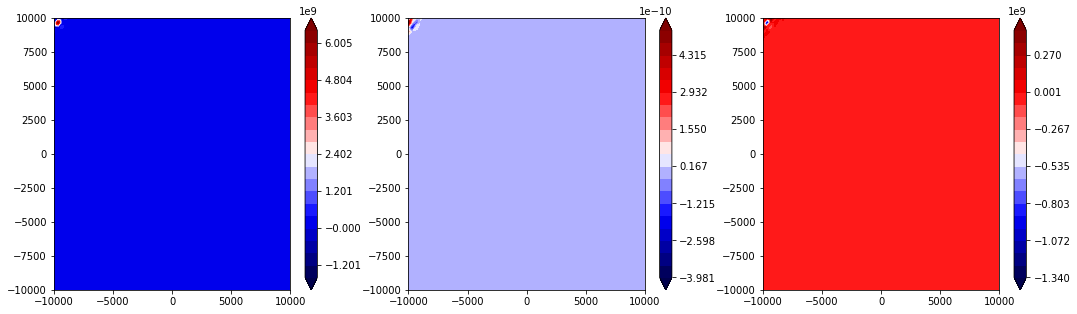

state


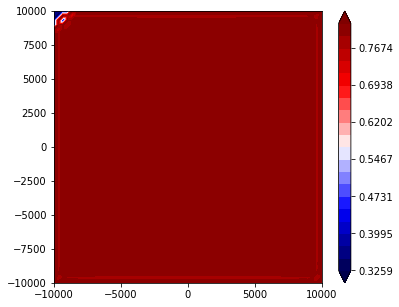

941 35.3058604539
942 35.3058604539
943 35.3058604539
944 35.3058604539
945 35.3058604539
946 35.3058604539
947 35.3058604539
948 35.3058604539
949 35.3058604539
950 35.3058604539
V


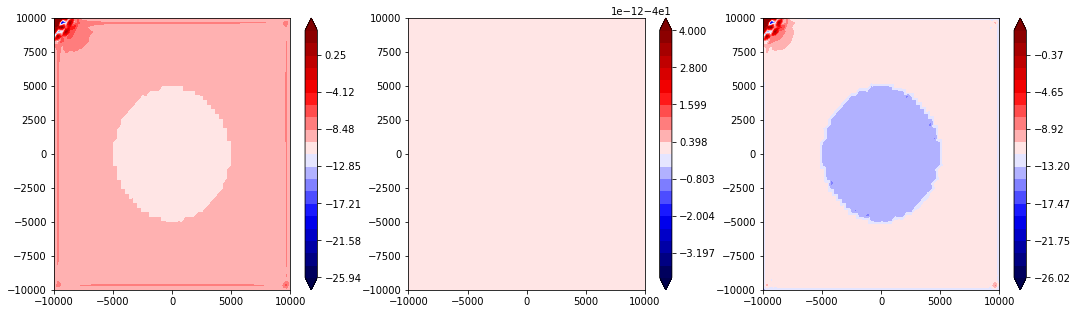

traction


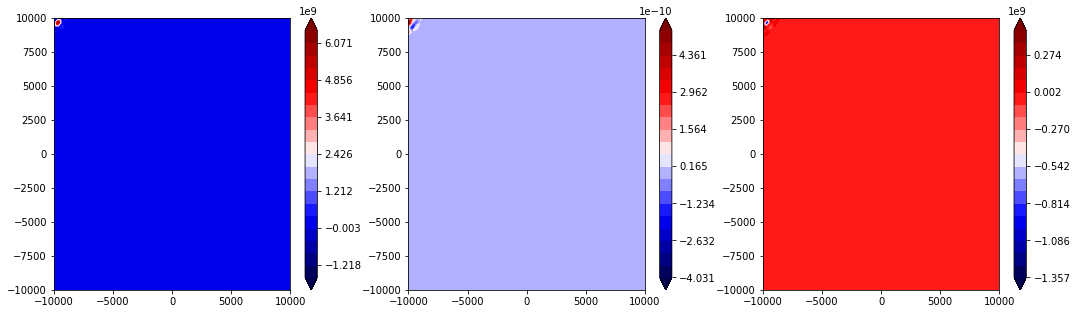

state


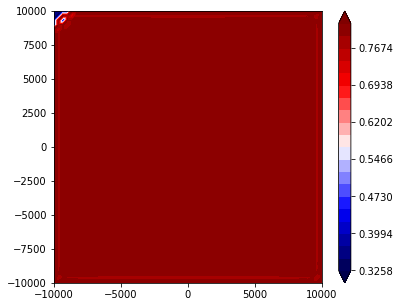

951 35.3058604539
952 35.3058604539
953 35.3058604539
954 35.3058604539
955 35.3058604539
956 35.3058604539
957 35.3058604539
958 35.3058604539
959 35.3058604539
960 35.3058604539
V


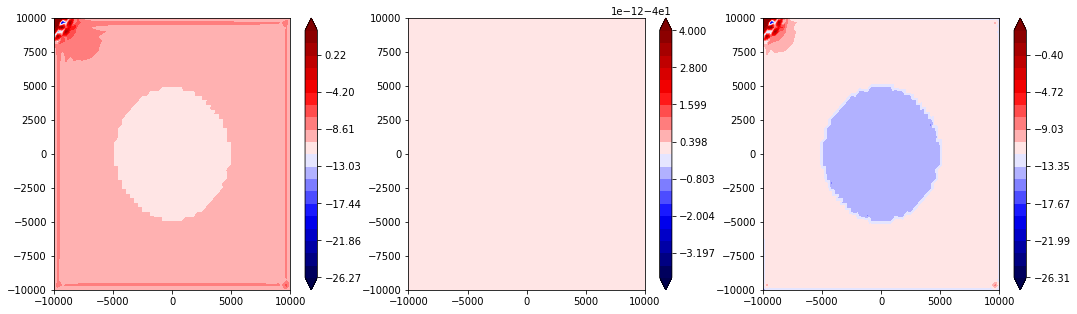

traction


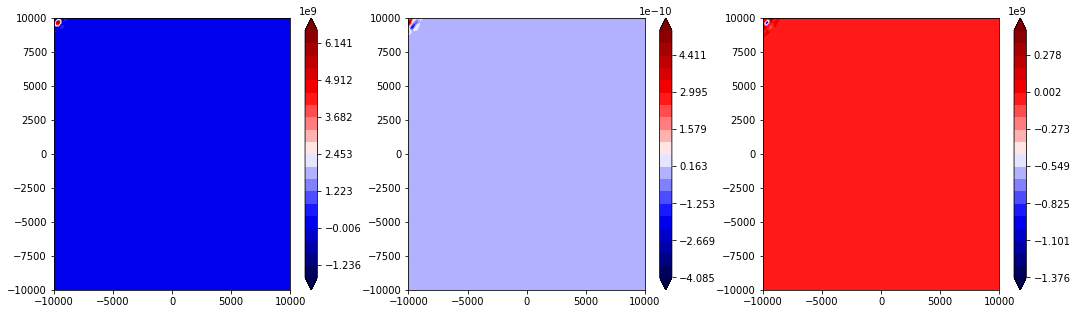

state


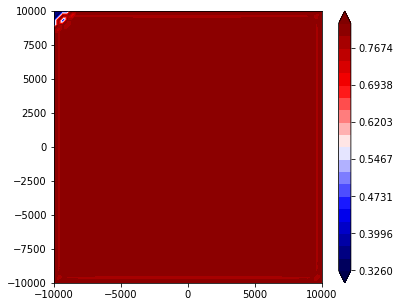

961 35.3058604539
962 35.3058604539
963 35.3058604539
964 35.3058604539
965 35.3058604539
966 35.3058604539
967 35.3058604539
968 35.3058604539
969 35.3058604539
970 35.3058604539
V


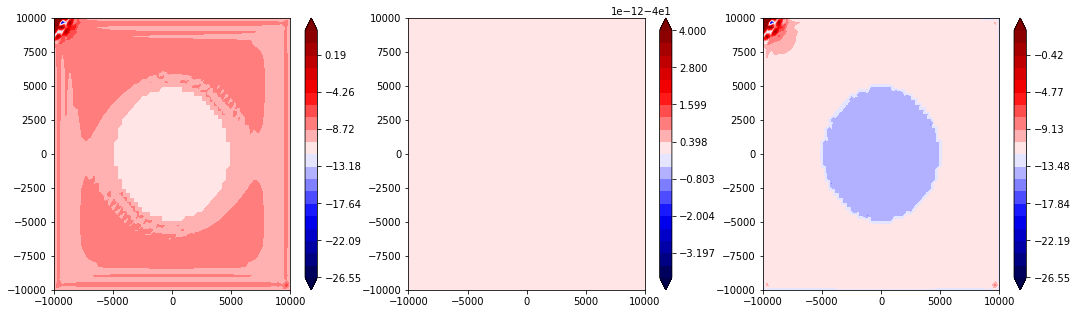

traction


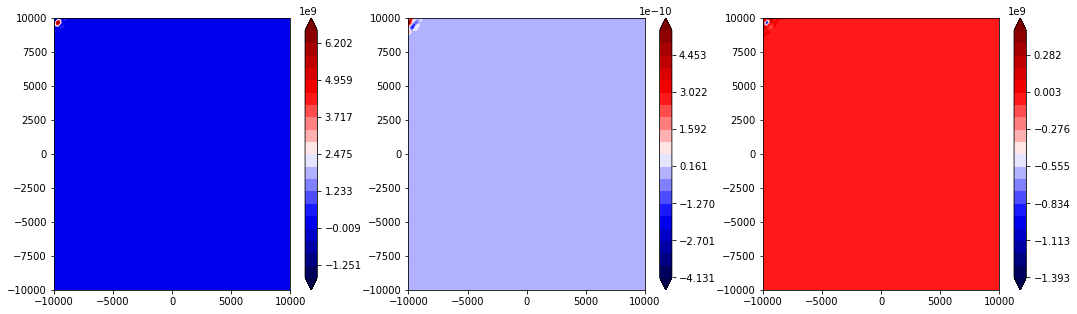

state


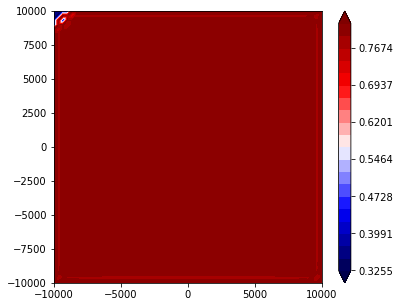

971 35.3058604539
972 35.3058604539
973 35.3058604539
974 35.3058604539
975 35.3058604539
976 35.3058604539
977 35.3058604539
978 35.3058604539
979 35.3058604539
980 35.3058604539
V


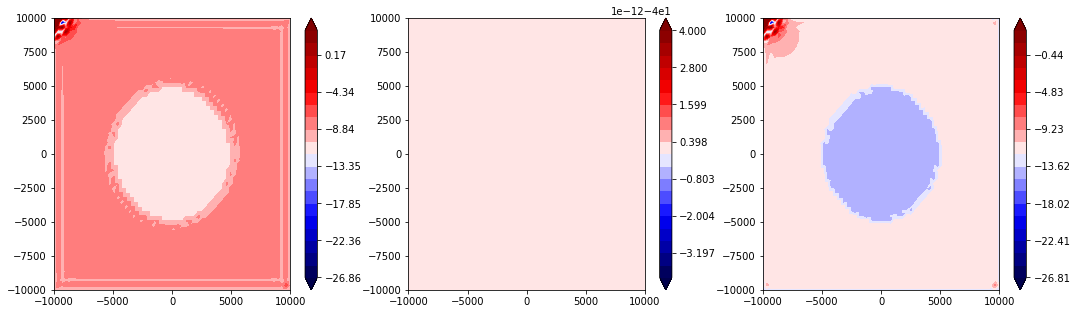

traction


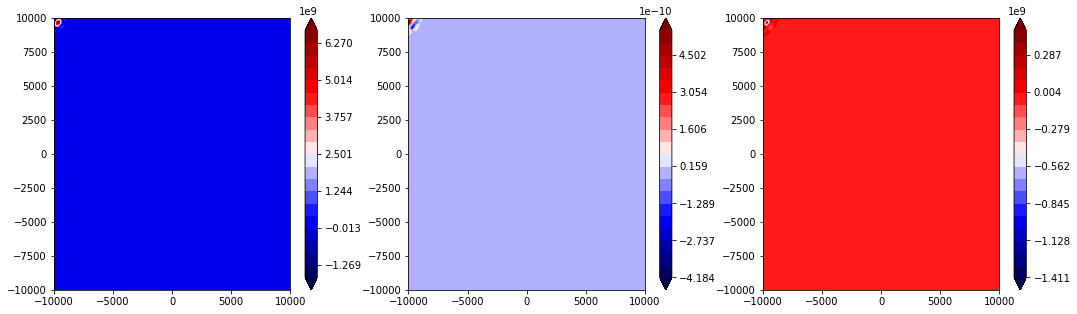

state


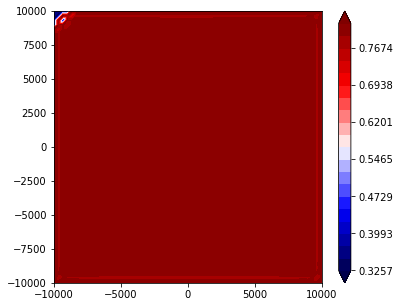

981 35.3058604539
982 35.3058604539
983 35.3058604539
984 35.3058604539
985 35.3058604539
986 35.3058604539
987 35.3058604539
988 35.3058604539
989 35.3058604539
990 35.3058604539
V


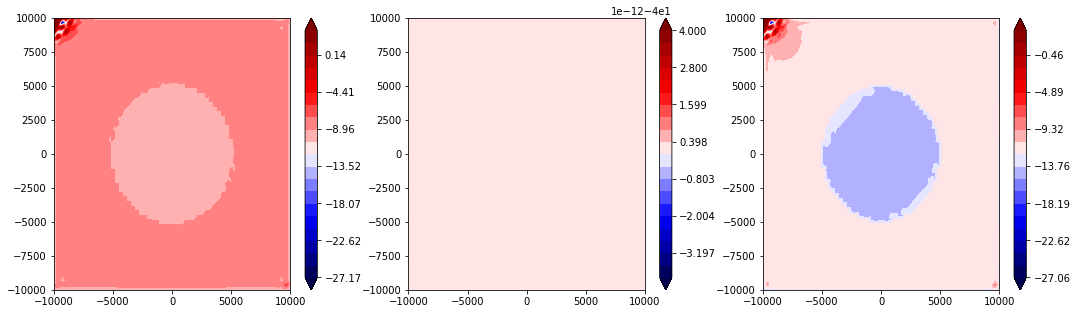

traction


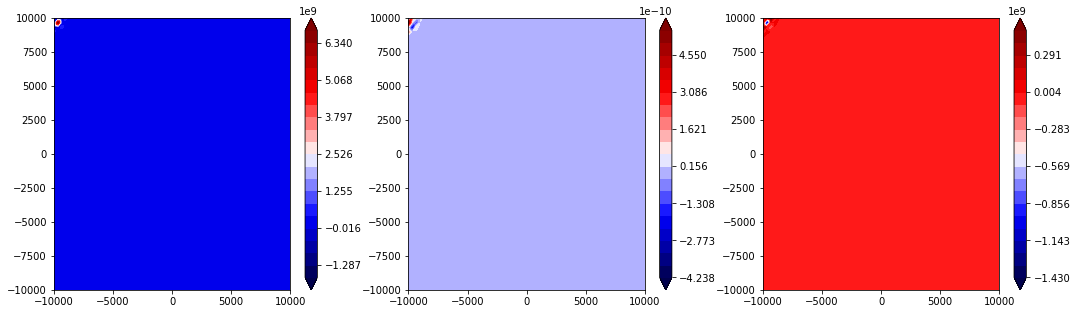

state


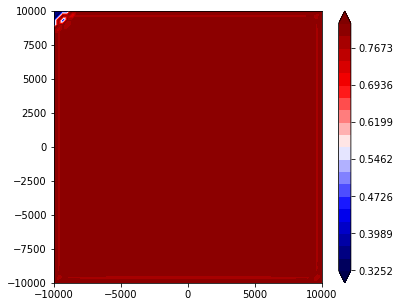

991 35.3058604539
992 35.3058604539
993 35.3058604539
994 35.3058604539
995 35.3058604539
996 35.3058604539
997 35.3058604539
998 35.3058604539
999 35.3058604539
1000 35.3058604539
V


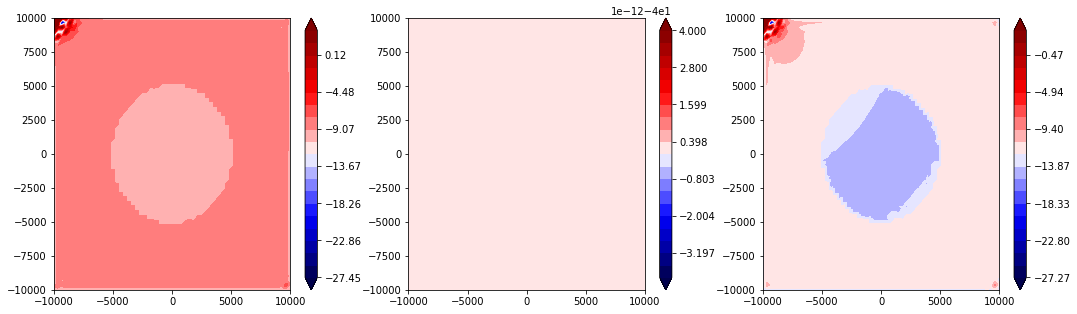

traction


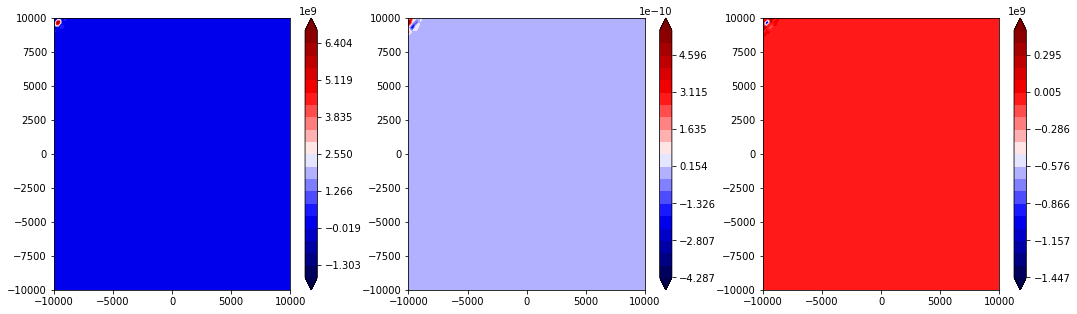

state


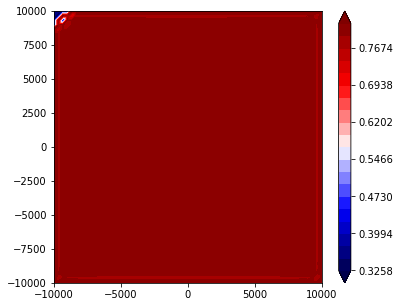

1001 35.3058604539
1002 35.3058604539
1003 35.3058604539
1004 35.3058604539
1005 35.3058604539
1006 35.3058604539
1007 35.3058604539
1008 35.3058604539
1009 35.3058604539
1010 35.3058604539
V


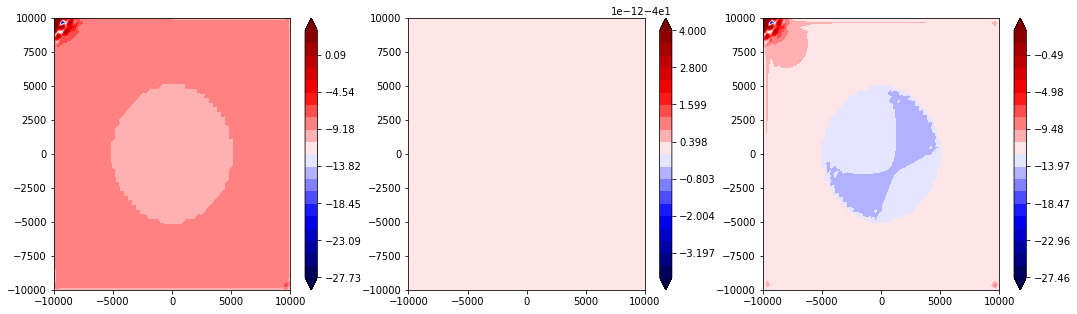

traction


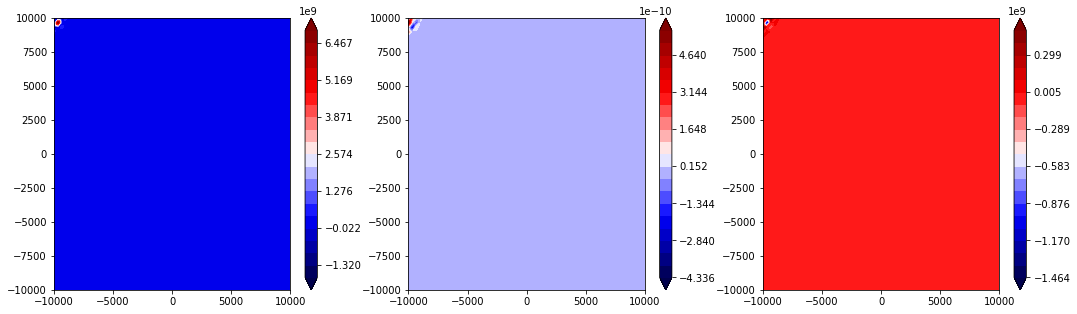

state


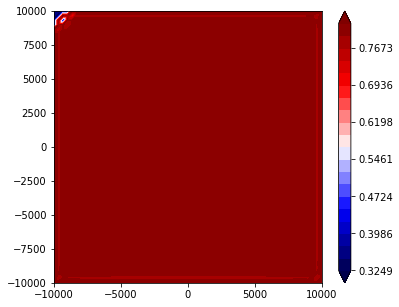

1011 35.3058604539
1012 35.3058604539
1013 35.3058604539
1014 35.3058604539
1015 35.3058604539
1016 35.3058604539
1017 35.3058604539
1018 35.3058604539
1019 35.3058604539
1020 35.3058604539
V


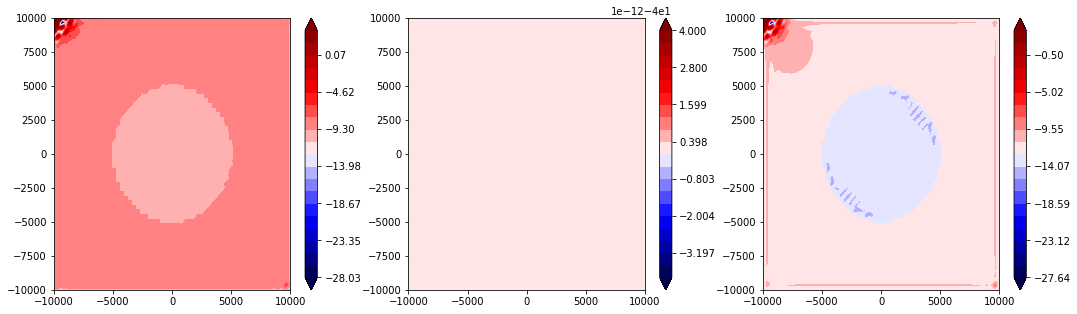

traction


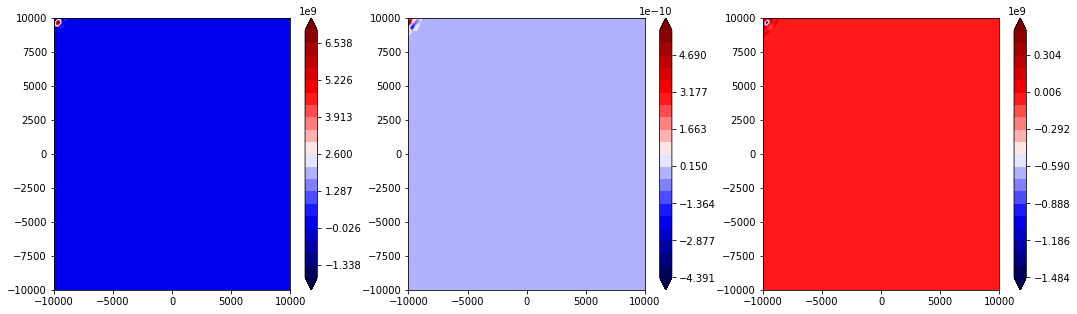

state


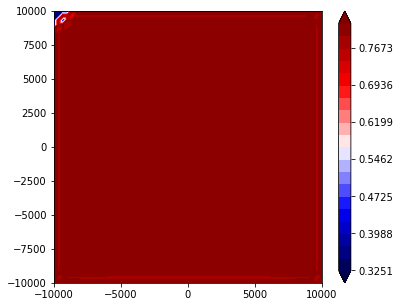

1021 35.3058604539
1022 35.3058604539
1023 35.3058604539
1024 35.3058604539
1025 35.3058604539
1026 35.3058604539
1027 35.3058604539
1028 35.3058604539
1029 35.3058604539
1030 35.3058604539
V


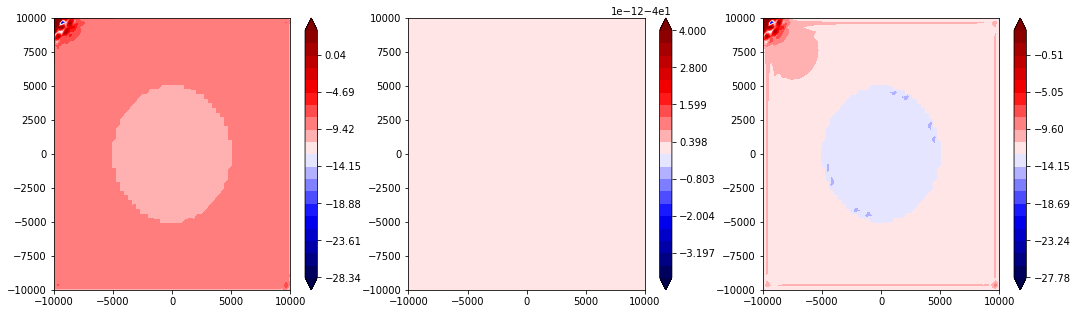

traction


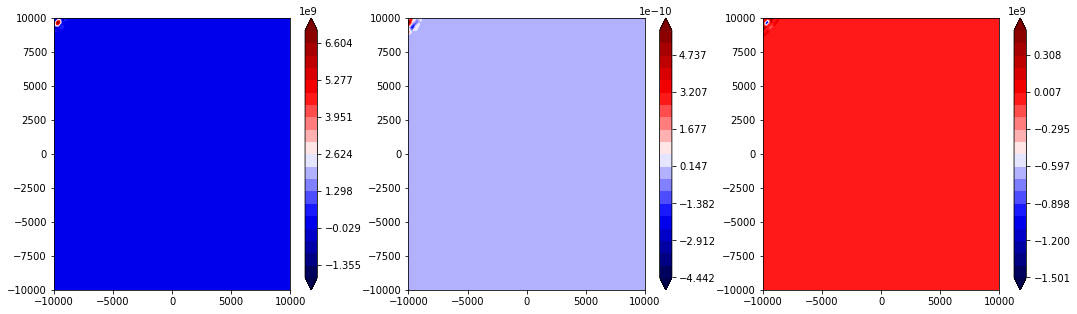

state


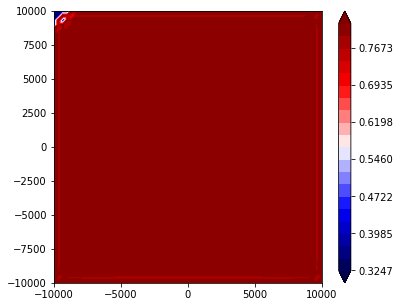

1031 35.3058604539
1032 35.3058604539
1033 35.3058604539
1034 35.3058604539
1035 35.3058604539
1036 35.3058604539
1037 35.305860454
1038 35.305860454
1039 35.305860454
1040 35.305860454
V


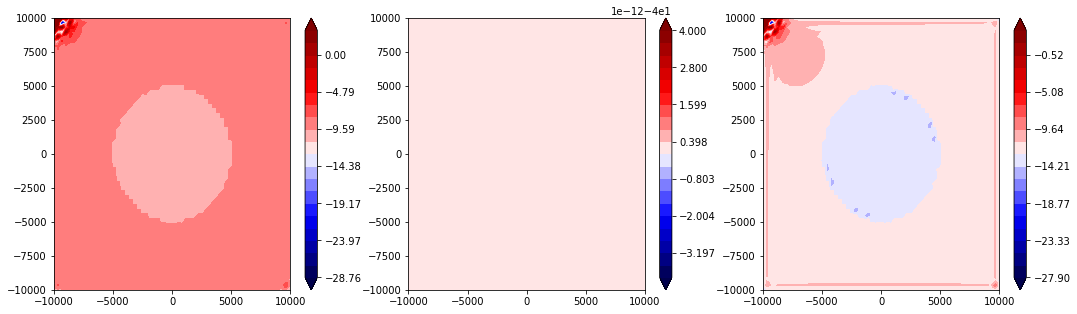

traction


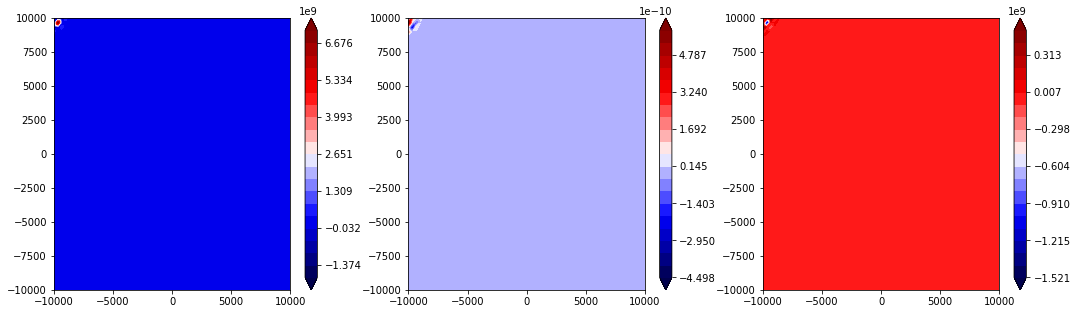

state


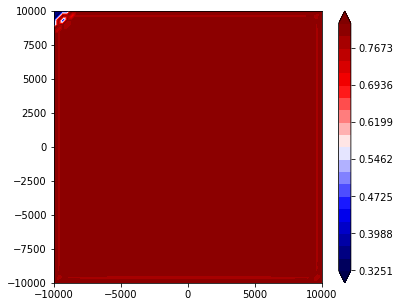

1041 35.305860454
1042 35.305860454
1043 35.305860454
1044 35.305860454
1045 35.305860454
1046 35.305860454
1047 35.305860454
1048 35.305860454
1049 35.305860454
1050 35.305860454
V


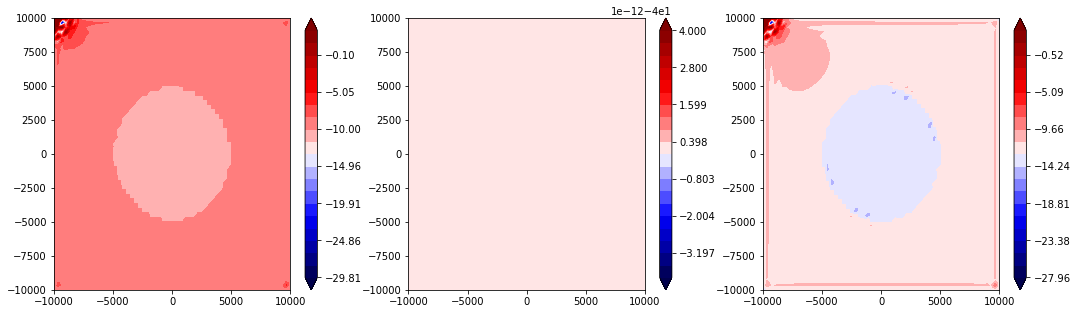

traction


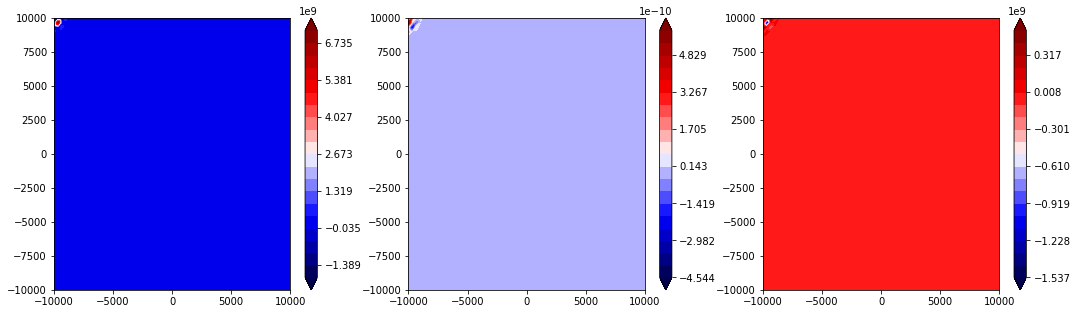

state


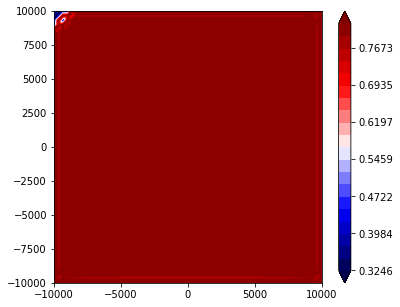

1051 35.305860454
1052 35.305860454
1053 35.305860454
1054 35.305860454
1055 35.305860454
1056 35.305860454
1057 35.305860454
1058 35.305860454
1059 35.305860454
1060 35.305860454
V


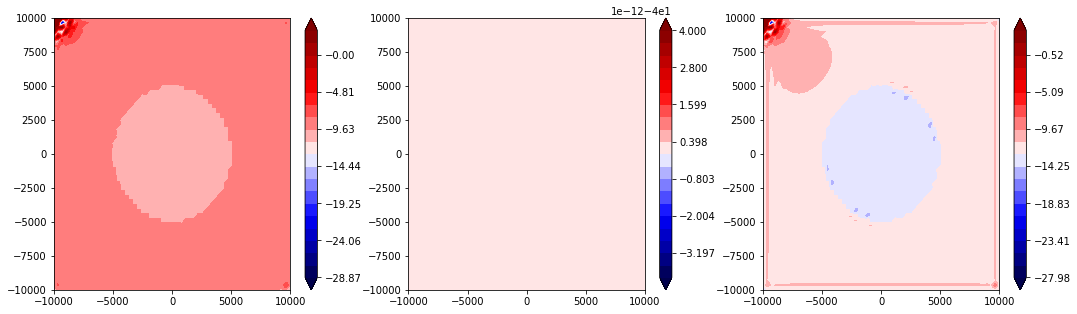

traction


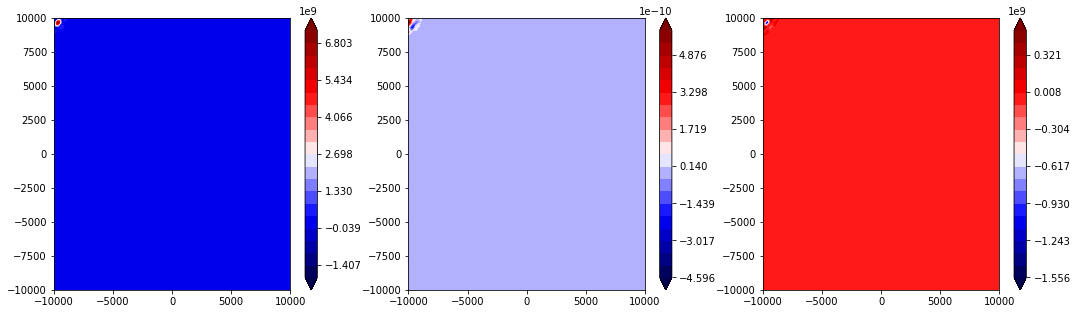

state


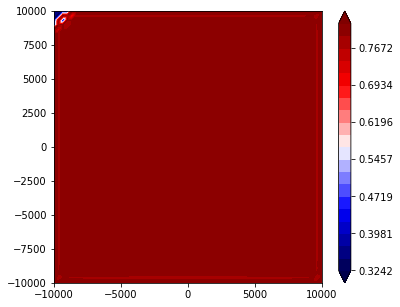

1061 35.305860454
1062 35.305860454
1063 35.305860454
1064 35.305860454
1065 35.305860454
1066 35.305860454
1067 35.305860454
1068 35.305860454
1069 35.305860454
1070 35.305860454
V


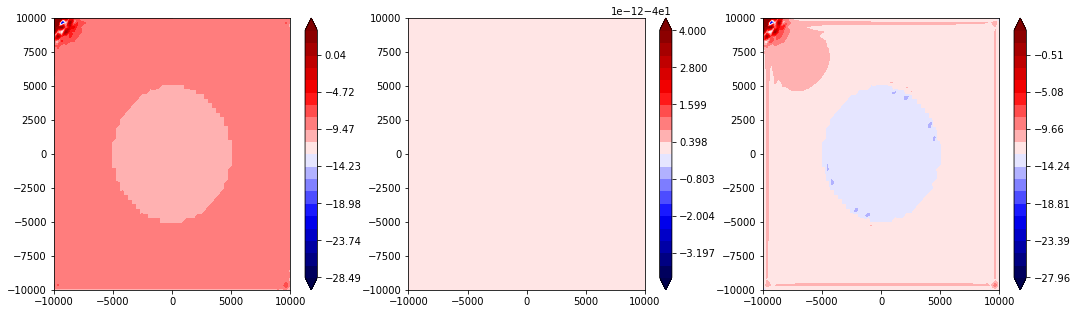

traction


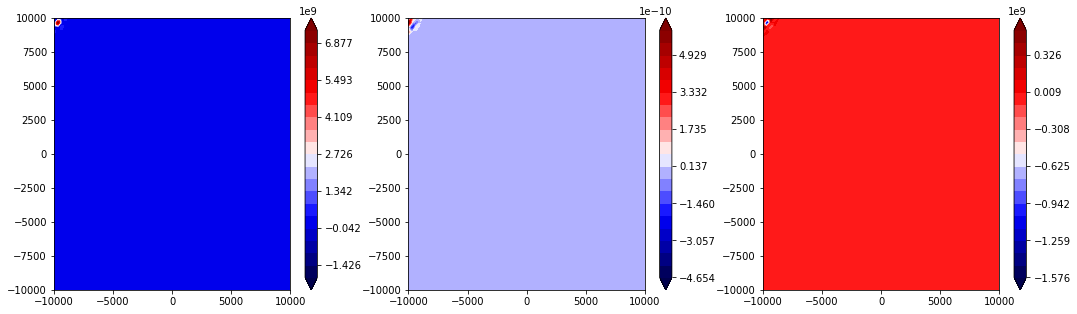

state


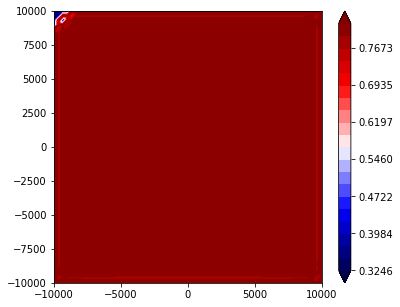

1071 35.305860454
1072 35.305860454
1073 35.305860454
1074 35.305860454
1075 35.305860454
1076 35.305860454
1077 35.305860454
1078 35.305860454
1079 35.305860454
1080 35.305860454
V


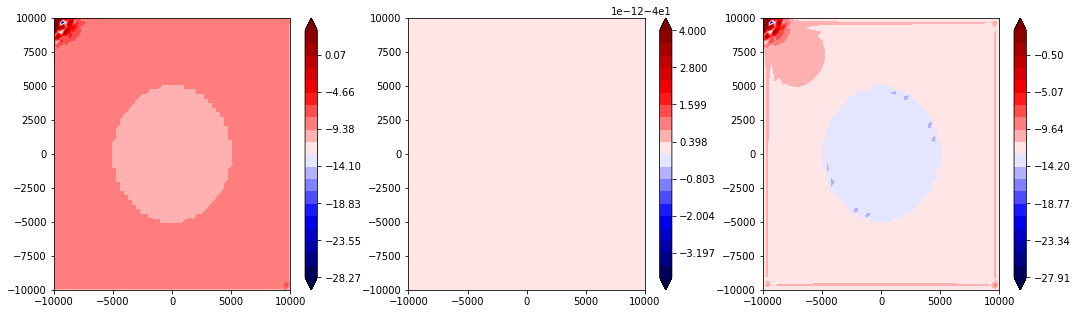

traction


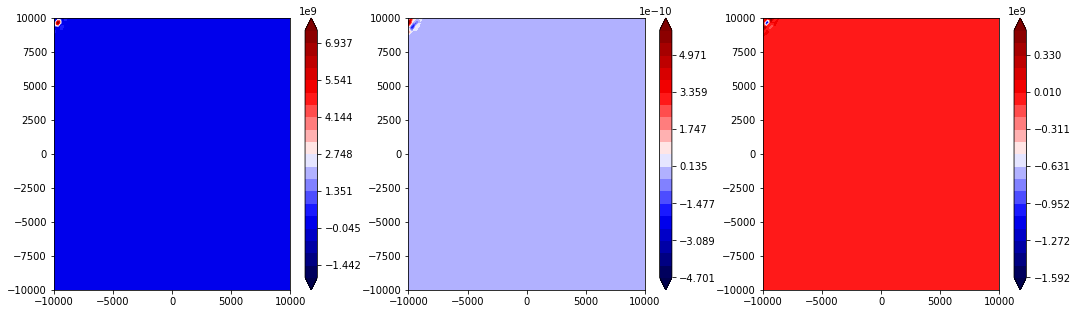

state


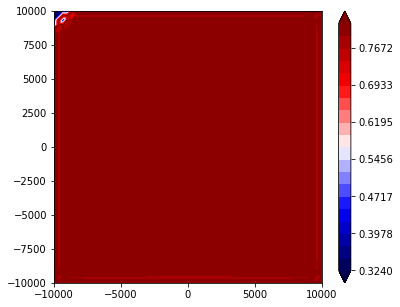

1081 35.305860454
1082 35.305860454
1083 35.305860454
1084 35.305860454
1085 35.305860454
1086 35.305860454
1087 35.305860454
1088 35.305860454
1089 35.305860454
1090 35.305860454
V


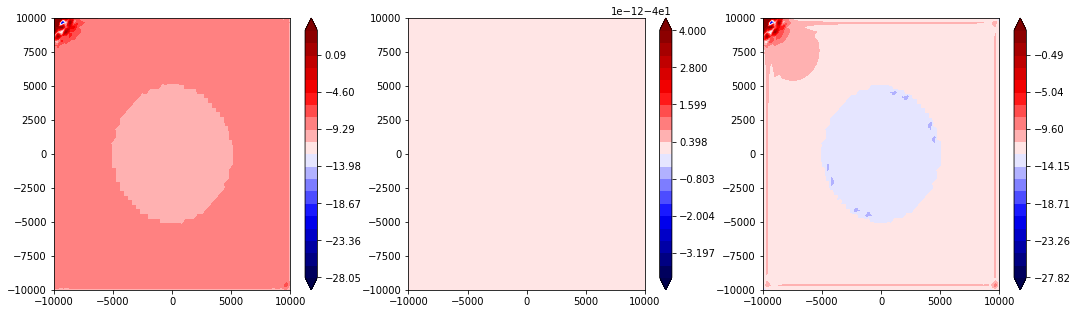

traction


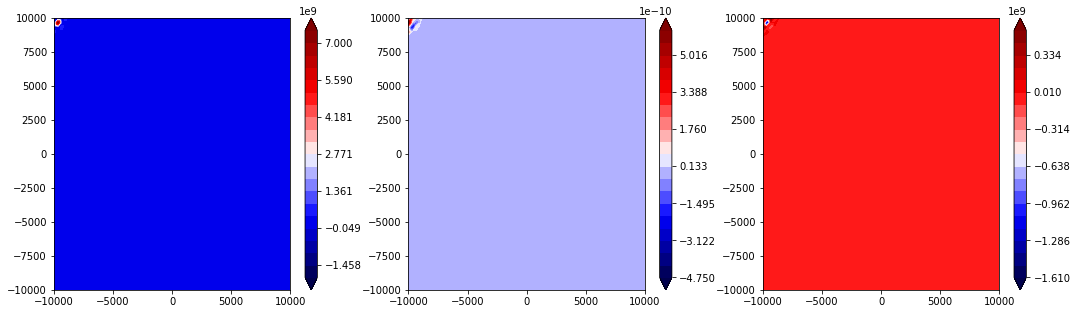

state


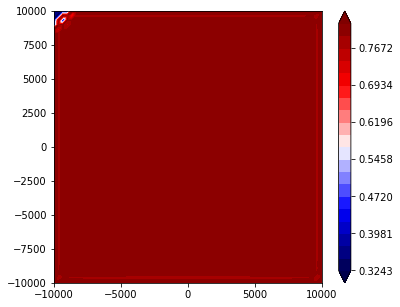

1091 35.305860454
1092 35.305860454
1093 35.305860454
1094 35.305860454
1095 35.305860454
1096 35.305860454
1097 35.305860454
1098 35.305860454
1099 35.305860454
1100 35.305860454
V


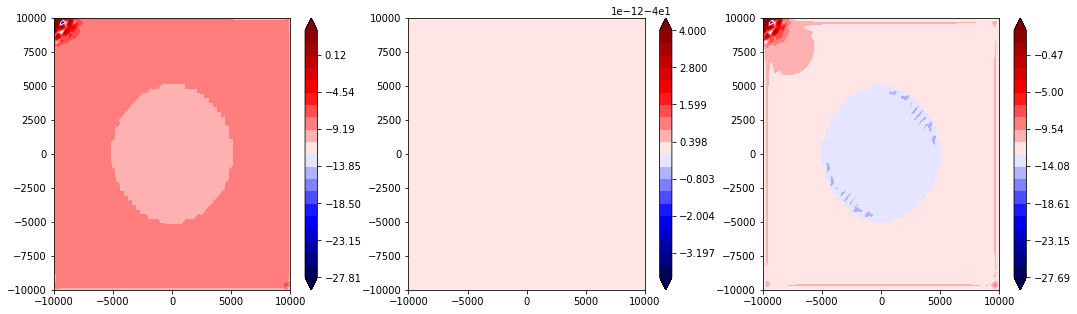

traction


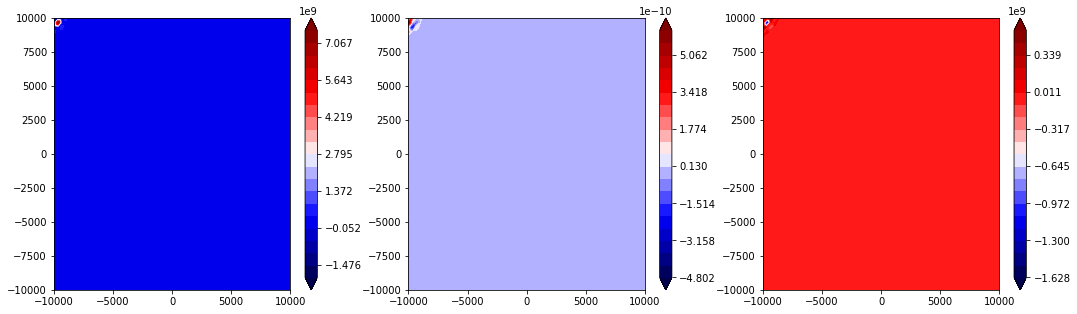

state


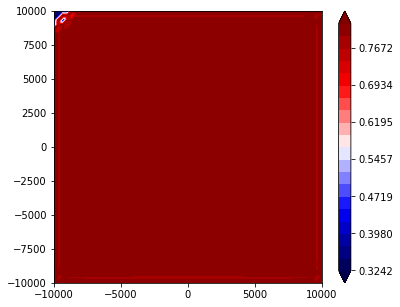

1101 35.305860454
1102 35.305860454
1103 35.305860454
1104 35.305860454
1105 35.305860454
1106 35.305860454
1107 35.305860454
1108 35.305860454
1109 35.305860454
1110 35.305860454
V


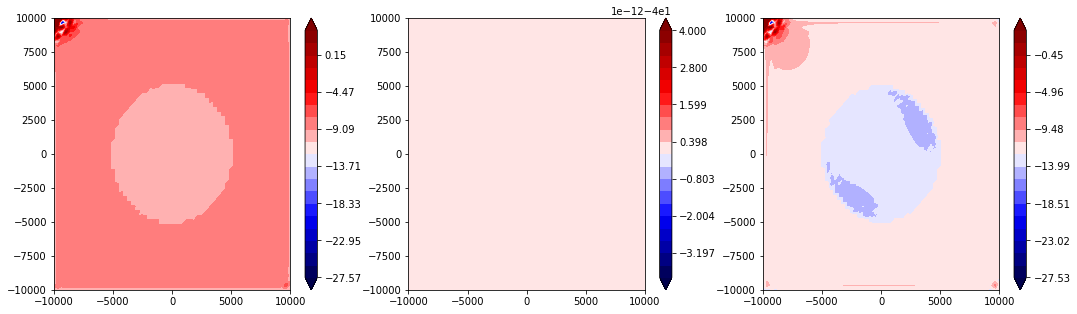

traction


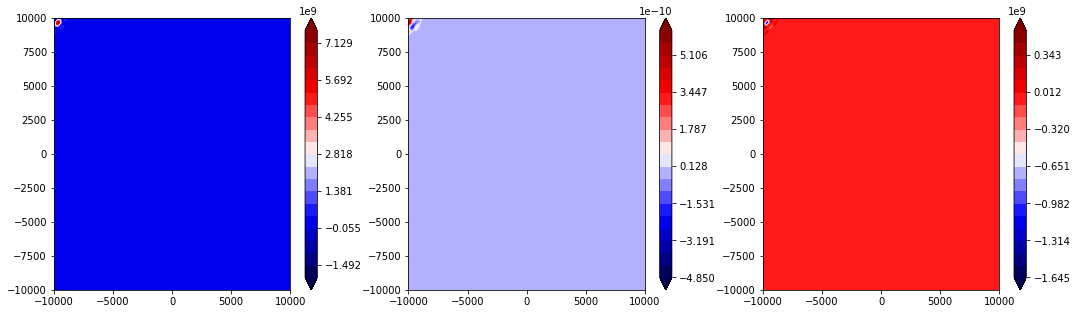

state


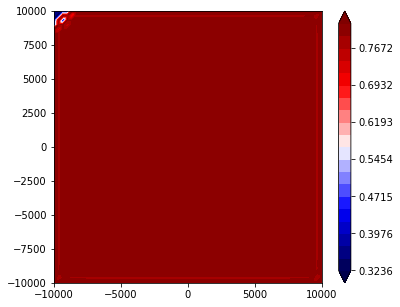

1111 35.305860454
1112 35.305860454
1113 35.305860454
1114 35.305860454
1115 35.305860454
1116 35.305860454
1117 35.305860454
1118 35.305860454
1119 35.305860454
1120 35.305860454
V


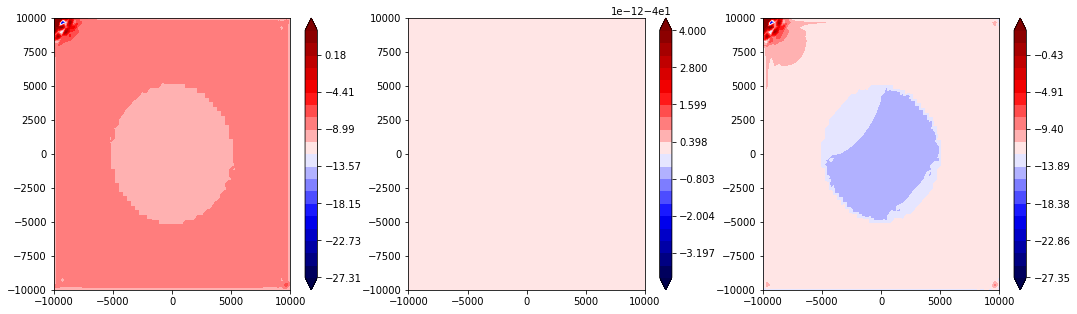

traction


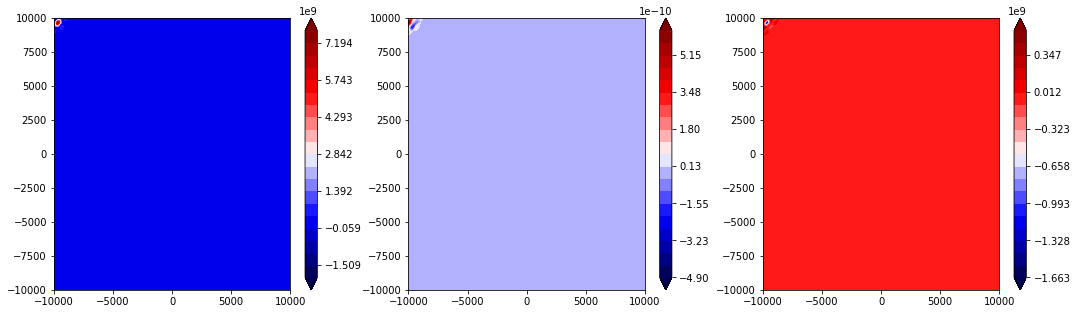

state


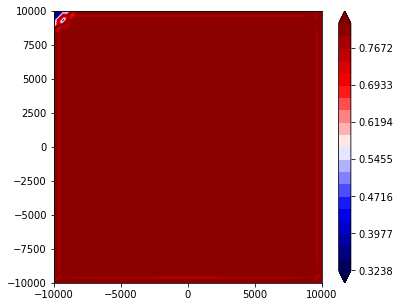

1121 35.305860454
1122 35.305860454
1123 35.305860454
1124 35.305860454
1125 35.305860454
1126 35.305860454
1127 35.305860454
1128 35.305860454
1129 35.305860454
1130 35.305860454
V


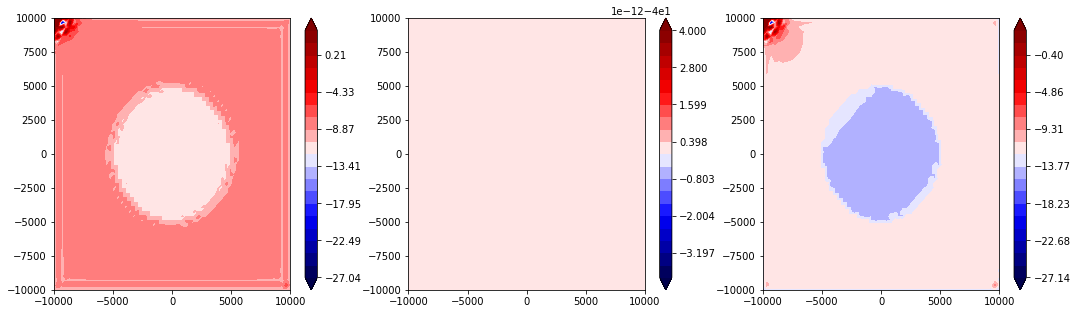

traction


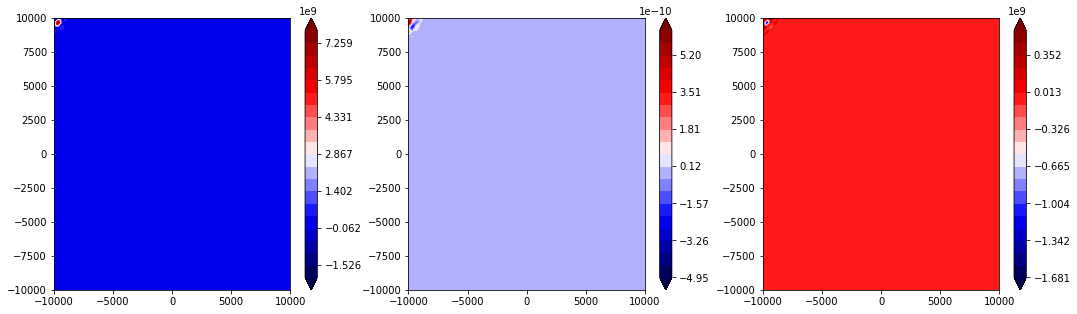

state


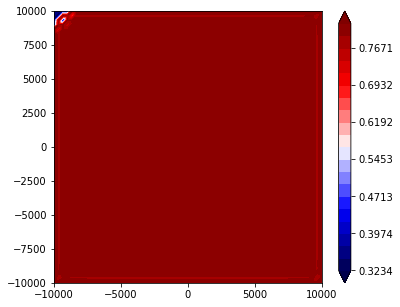

1131 35.305860454
1132 35.305860454
1133 35.305860454
1134 35.305860454
1135 35.305860454
1136 35.305860454
1137 35.305860454
1138 35.305860454
1139 35.305860454
1140 35.305860454
V


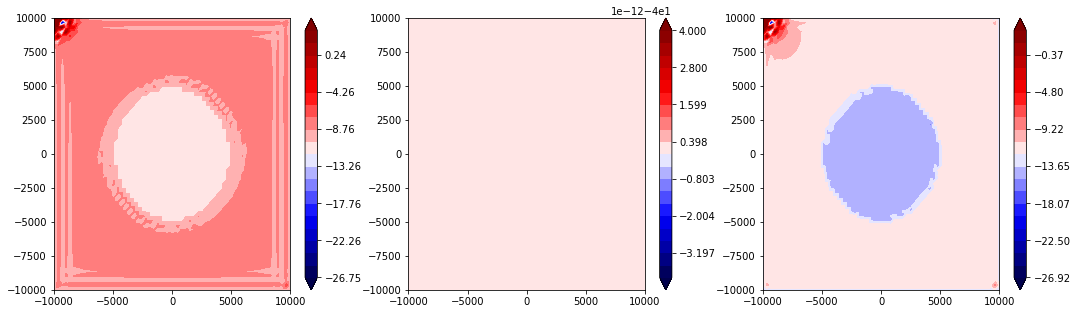

traction


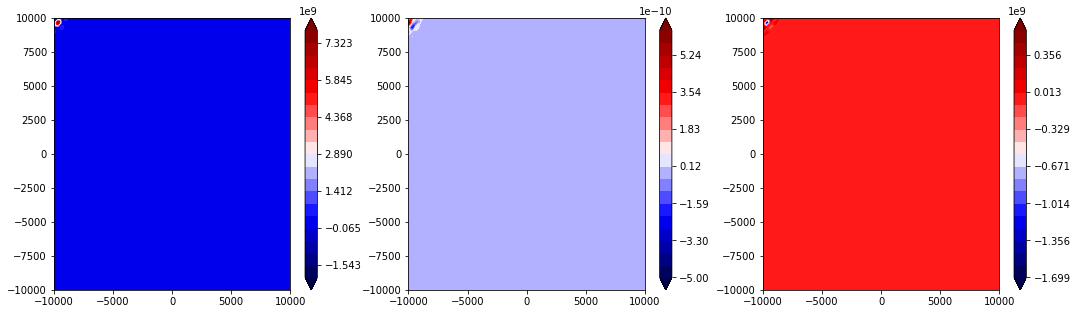

state


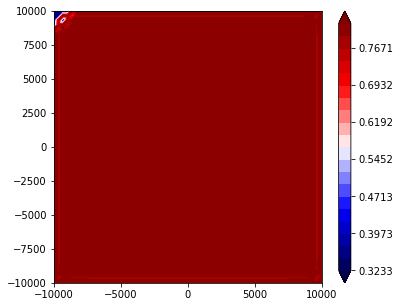

1141 35.305860454
1142 35.305860454
1143 35.305860454
1144 35.305860454
1145 35.305860454
1146 35.305860454
1147 35.305860454
1148 35.305860454
1149 35.305860454
1150 35.305860454
V


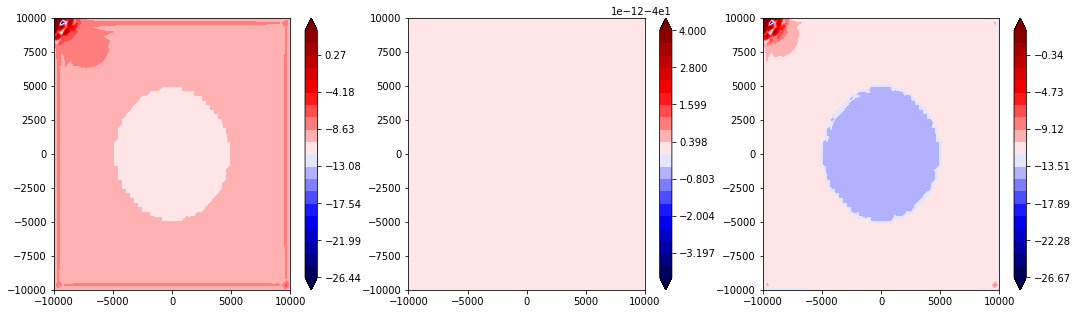

traction


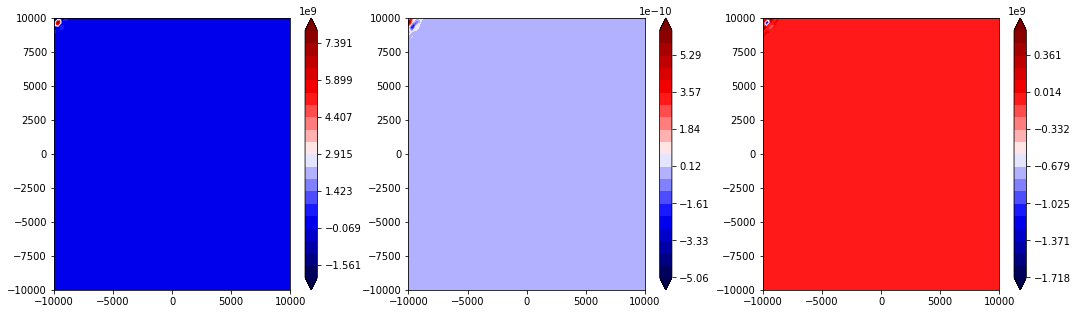

state


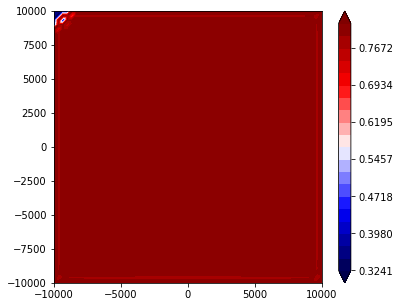

1151 35.305860454
1152 35.305860454
1153 35.305860454
1154 35.305860454
1155 35.305860454
1156 35.305860454
1157 35.305860454
1158 35.305860454
1159 35.305860454
1160 35.305860454
V


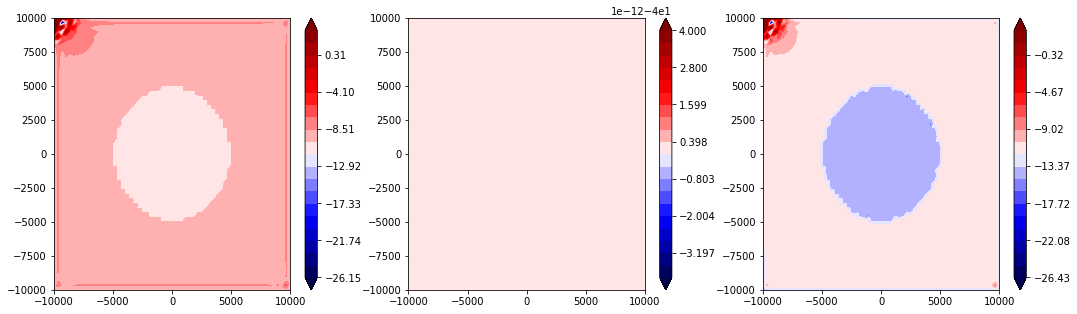

traction


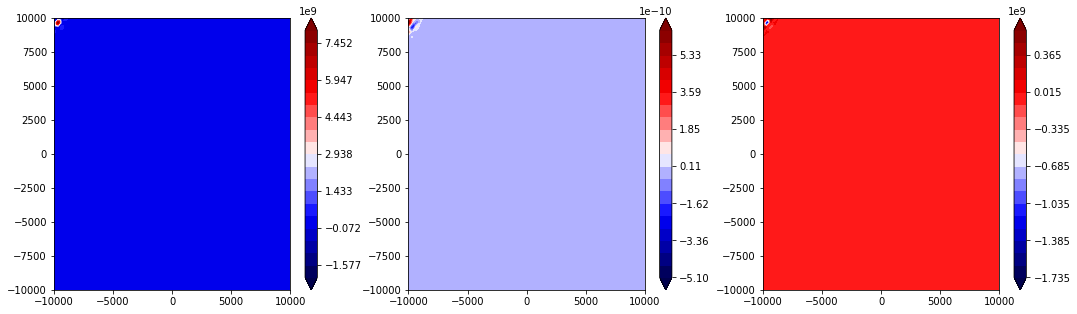

state


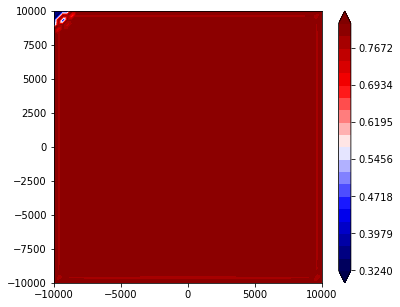

1161 35.305860454
1162 35.305860454
1163 35.305860454
1164 35.305860454
1165 35.305860454
1166 35.305860454
1167 35.305860454
1168 35.305860454
1169 35.305860454
1170 35.305860454
V


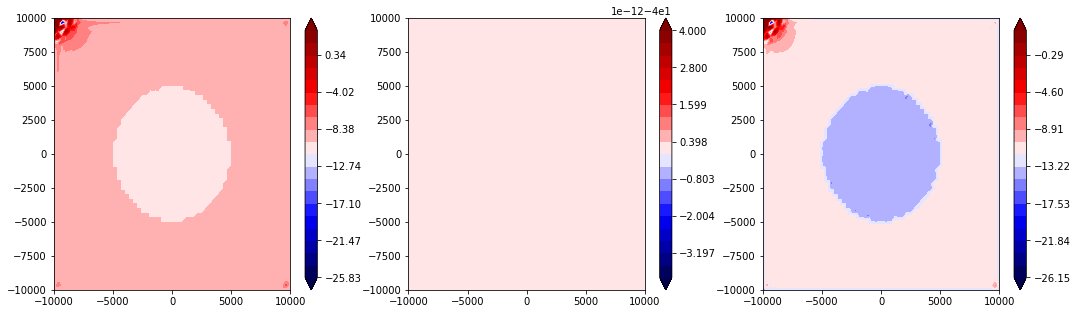

traction


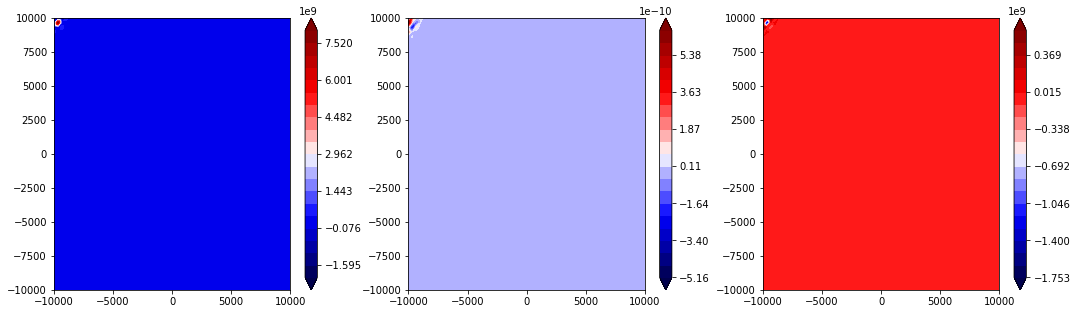

state


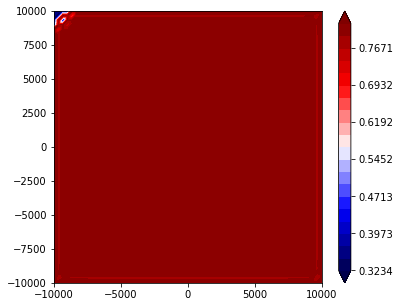

1171 35.305860454
1172 35.305860454
1173 35.305860454
1174 35.305860454
1175 35.305860454
1176 35.305860454
1177 35.305860454
1178 35.305860454
1179 35.305860454
1180 35.305860454
V


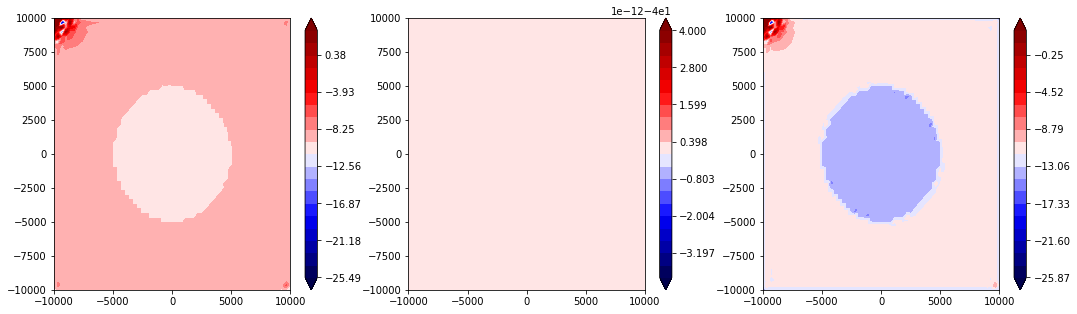

traction


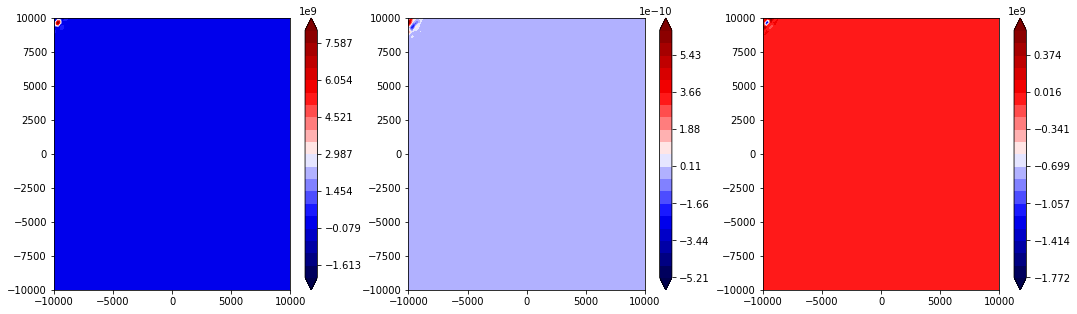

state


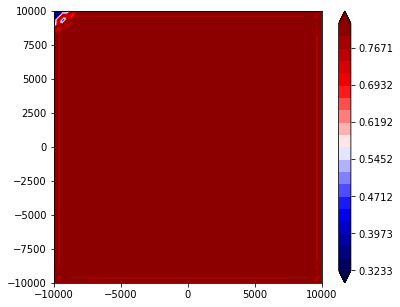

1181 35.305860454
1182 35.305860454
1183 35.305860454
1184 35.305860454
1185 35.305860454
1186 35.305860454
1187 35.305860454
1188 35.305860454
1189 35.305860454
1190 35.305860454
V


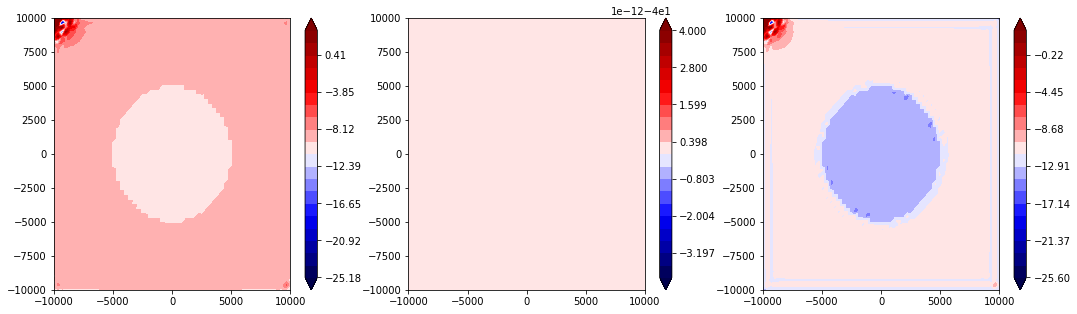

traction


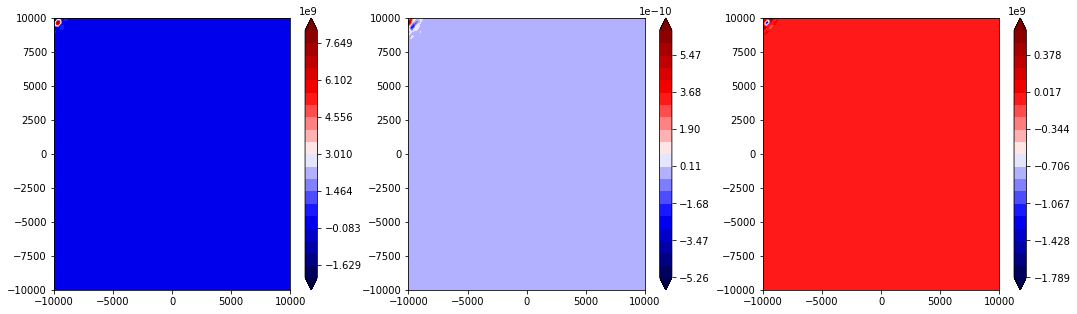

state


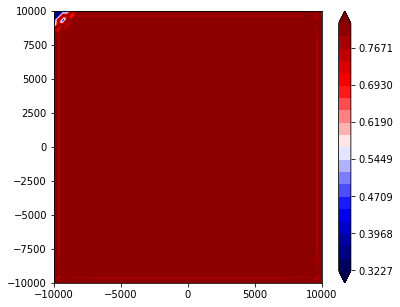

1191 35.305860454
1192 35.305860454
1193 35.305860454
1194 35.305860454
1195 35.305860454
1196 35.305860454
1197 35.305860454
1198 35.305860454
1199 35.305860454
1200 35.305860454
V


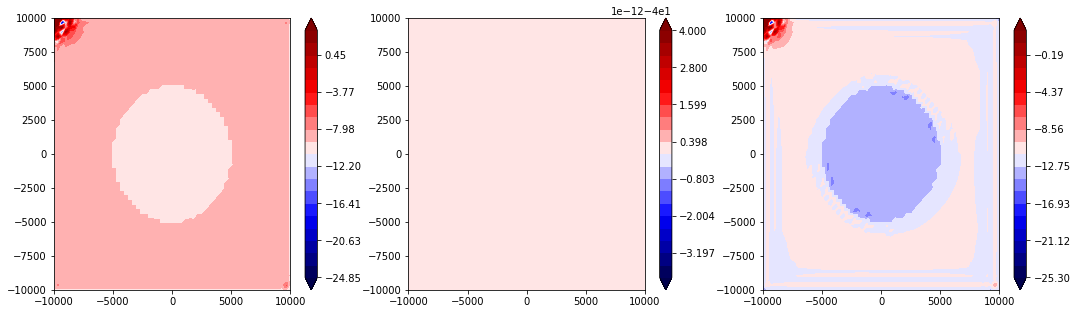

traction


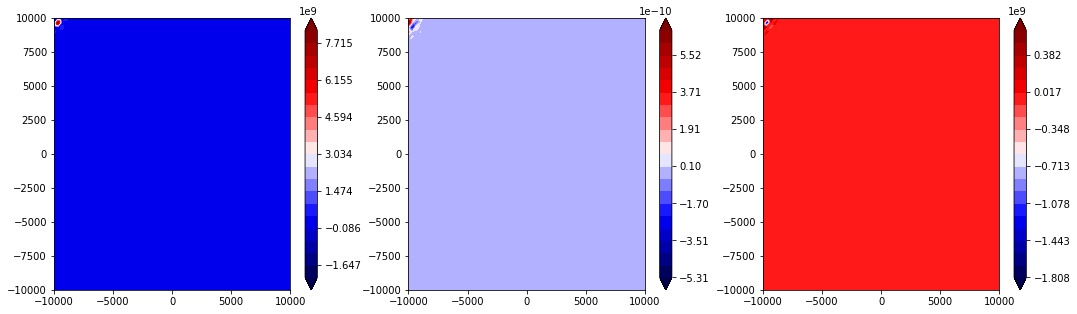

state


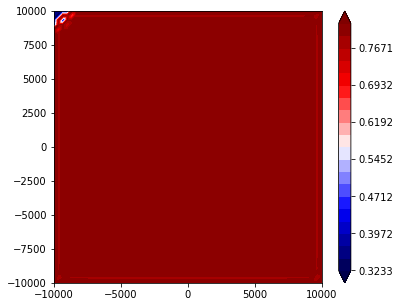

1201 35.305860454
1202 35.305860454
1203 35.305860454
1204 35.305860454
1205 35.305860454
1206 35.305860454
1207 35.305860454
1208 35.305860454
1209 35.305860454
1210 35.305860454
V


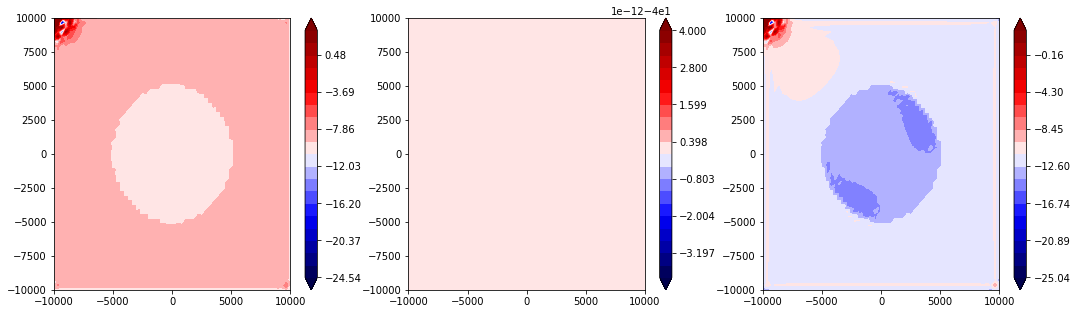

traction


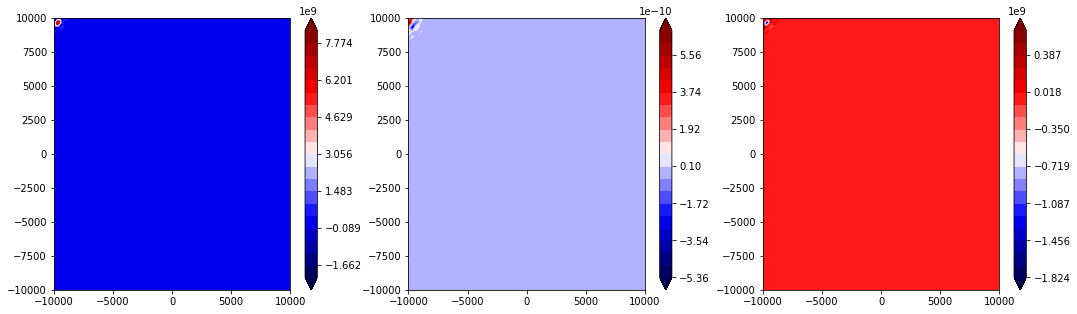

state


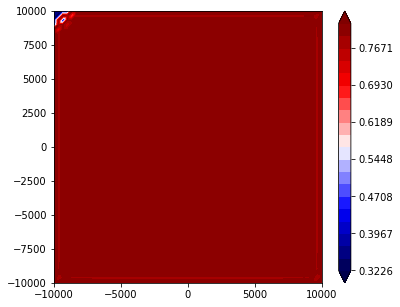

1211 35.305860454
1212 35.305860454
1213 35.305860454
1214 35.305860454
1215 35.305860454
1216 35.305860454
1217 35.305860454
1218 35.305860454
1219 35.305860454
1220 35.305860454
V


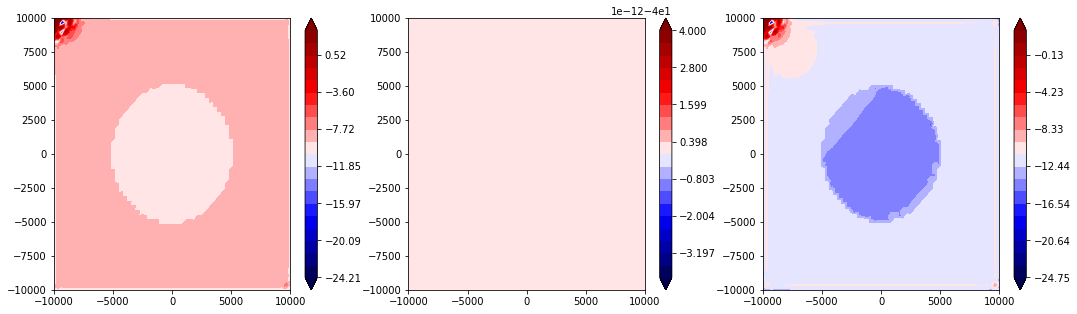

traction


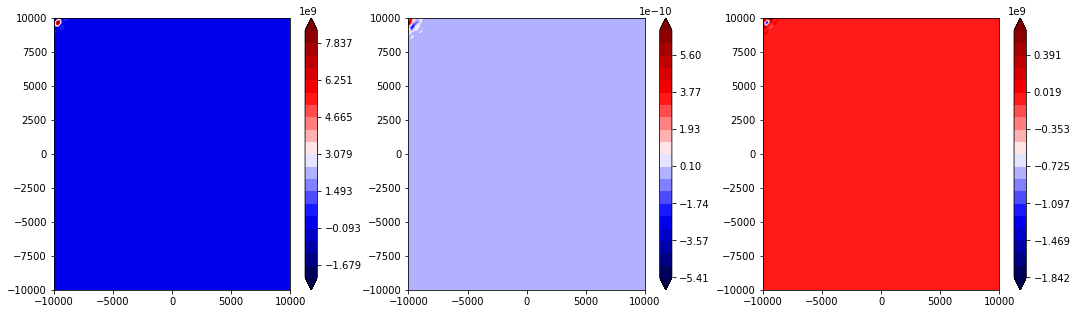

state


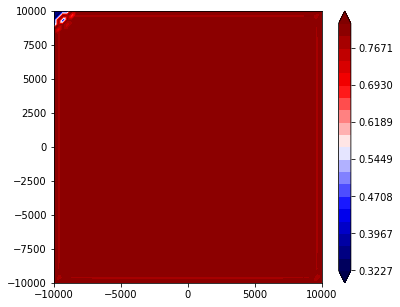

1221 35.305860454
1222 35.305860454
1223 35.305860454
1224 35.305860454
1225 35.305860454
1226 35.305860454
1227 35.305860454
1228 35.305860454
1229 35.305860454
1230 35.305860454
V


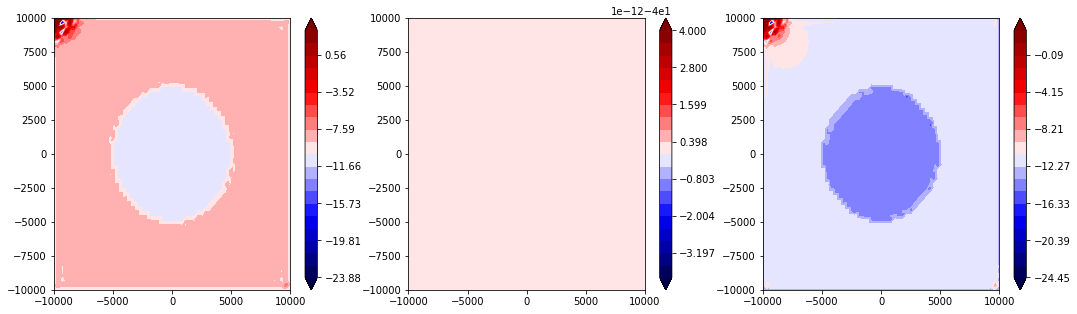

traction


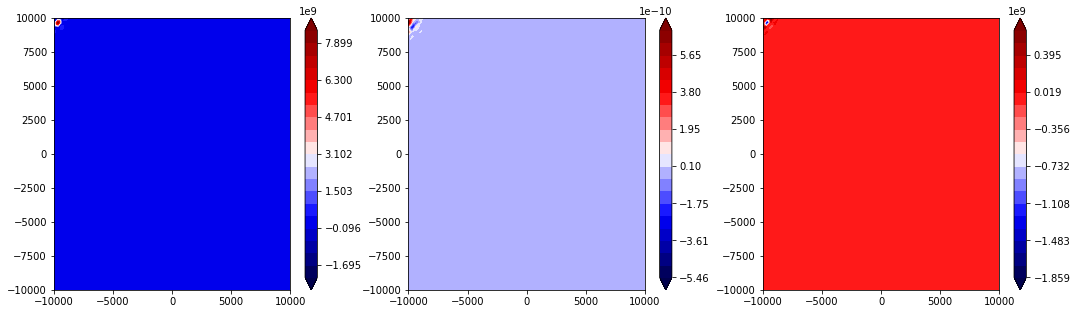

state


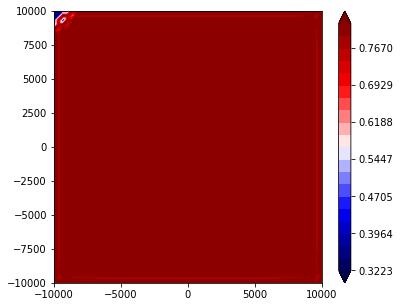

1231 35.305860454
1232 35.305860454
1233 35.305860454
1234 35.305860454
1235 35.305860454
1236 35.305860454
1237 35.305860454
1238 35.305860454
1239 35.305860454
1240 35.305860454
V


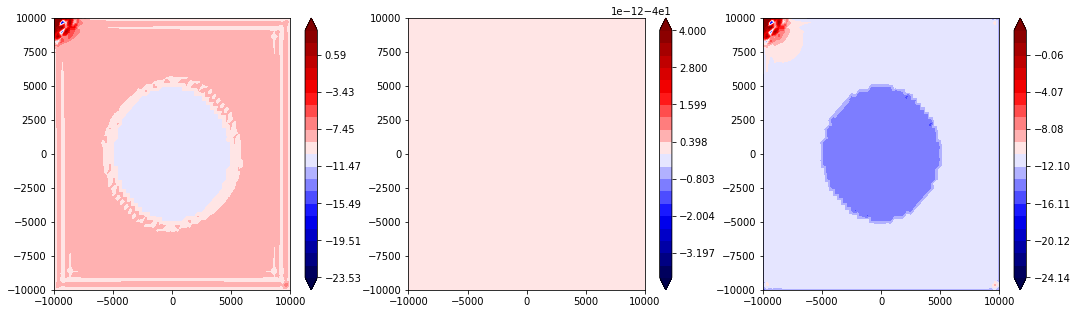

traction


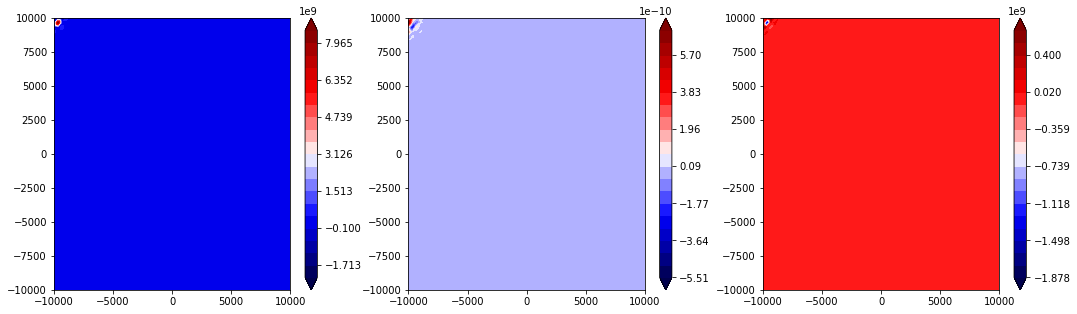

state


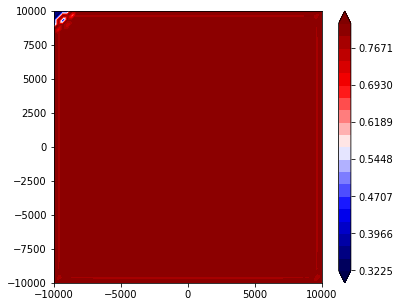

1241 35.305860454
1242 35.305860454
1243 35.305860454
1244 35.305860454
1245 35.305860454
1246 35.305860454
1247 35.305860454
1248 35.305860454


KeyboardInterrupt: 

In [11]:
from tectosaur.util.timer import Timer
h_t = []
h_y = []
siay = 60 * 60 * 24 * 365.25
for i in range(10000):
    assert(integrator.step() == None)
    h_t.append(integrator.t)
    h_y.append(integrator.y.copy())
    print(i, integrator.t / siay)
    if i % 10 == 0:
        plot_setting(integrator.t, integrator.y, qdm, qd_cfg, slip_to_traction)
    if i % 200 == 0:
        np.save('results.npy', np.array([qdm.m, qd_cfg, h_t, h_y], dtype = np.object))